<div style="background-color:	#006096; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Deep Learning - Karaoke Klassificatie</h1>
<b style="color:white">Rogier Gernaat, Vera van Veen, Daan Eising</b>
    </div>

<a name='start'></a>

# Inhoudsopgave
- H1: Importeren van libraries en data inladen
- H2: Expolartory Data Analysis
- H3: LSTM voor audioclips
  - H3.1 Feature engineering
  - H3.2 Modelleren
- H4 LSTM voor songteksten
  - H4.1: Data Preprocessing
  - H4.2: Feature Engineering
  - H4.3: Modelleren
- H5: Transformer voor songteksten
  - H5.1: Data Preprocessing
  - H5.2: Modelleren
- H6: Model naar Keuze
  - H6.1: Modelleren
- H7: Bevindingen
- H8: Conclusie en aanbevelingen
- H9: Bronvermelding


In [39]:
from google.colab import drive
import os
import librosa as lr
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow as tf
from transformers import RobertaTokenizer
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.layers import Normalization, Reshape, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
import seaborn as sns
from IPython.display import Audio
import warnings
import pathlib
warnings.filterwarnings('ignore')

#Imports van een later moment:
from tensorflow.keras.layers import Normalization, Reshape,Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split

import pathlib
import tensorflow as tf
import librosa as lr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
import os


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Hoofdstuk 1: Importeren van libraries en data inladen </strong></h2>
</div>

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Data/test.csv")

In [9]:
test

filename                                             lyrics
0    test.00000.wav  [Instrumental Intro]\n(Radio)\n(Radio)\n[Verse...
1    test.00001.wav  [Verse 1]\nThere's an old Kodak camera in my d...
2    test.00002.wav  [Intro]\nSo curious, so curious\n\n[Verse 1]\n...
3    test.00003.wav  [Intro]\nWhere do I take this pain of mine\nI ...
4    test.00004.wav  [Verse 1]\nBaby's into runnin' around, hangin'...
..              ...                                                ...
124  test.00124.wav  Heaven must be missing an angel\nMissing one a...
125  test.00125.wav  [Verse 1]\nLaura and Tommy were lovers\nHe wan...
126  test.00126.wav  [Chorus: Agnetha & Frida, Benny & Björn]\nIf y...
127  test.00127.wav  [Chorus]\nLegalize it\nAnd don't criticize it\...
128  test.00128.wav  [Verse 1]\nWell, in North Carolina, way back i...

[129 rows x 2 columns]

In [10]:
train

filename                                             lyrics  genre
0    blues.00001.wav  I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...  blues
1    blues.00002.wav  (John Lee Hooker)\nThink twice before you go, ...  blues
2    blues.00003.wav  [Intro, Spoken]\n...A little thing I'm going t...  blues
3    blues.00005.wav  Sugar mama, sugar mama, sugar mama please come...  blues
4    blues.00006.wav  My baby left me this morning\nPeople just arou...  blues
..               ...                                                ...    ...
532   rock.00094.wav  [Chorus]\nDon’t stop\nIsn’t it funny how you s...   rock
533   rock.00096.wav  [Verse 1]\nHer hair, soft drifted snow\nDeath ...   rock
534   rock.00097.wav  [Verse 1]\nYour knuckles whiten on the wheel\n...   rock
535   rock.00098.wav  [Verse 1]\nYou know it\nYou show it\nAnd the t...   rock
536   rock.00099.wav  [Verse 1]\nA girl consumed by fire\nWe all kno...   rock

[537 rows x 3 columns]

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Test Audio Data Inladen </strong></h2>
</div>

In [11]:
#Lijsten aanmaken voor de data
audio_data = []
sample_freqs = []
wav_names = []


target_length = 22050 * 30
test_audio = "/content/drive/MyDrive/Colab_Notebooks/Data/Test"


#Elk audio bestand processen
for file in os.listdir(test_audio):
    if file.endswith(".wav"):
        file_path = os.path.join(test_audio, file)
        data, sample_rate = lr.load(file_path, sr=None)

        wav_names.append(file)

        # Audio afkappen of aanvullen
        if len(data) > target_length:
            # Data afkappen
            data = data[:target_length]
        elif len(data) < target_length:
            # Aanvullen met nullen
            padding = target_length - len(data)
            data = np.pad(data, (0, padding), mode='constant')

        # Data toevoegen
        audio_data.append(data)
        sample_freqs.append(sample_rate)

# Omzetten naar een numpy-array
test_audio_data = np.stack(audio_data, axis=0)
sample_freqs = np.array(sample_freqs)

# Een voorbeeld weergeven
print(test_audio_data[:5])


[[-0.23202515 -0.23168945 -0.1979065  ...  0.12741089  0.04037476
   0.04598999]
 [ 0.24969482  0.38006592  0.30645752 ... -0.03051758  0.00689697
   0.00094604]
 [-0.01864624 -0.03515625 -0.0078125  ...  0.07119751  0.07769775
   0.07794189]
 [-0.00378418  0.04263306  0.04504395 ... -0.3274536  -0.4189453
  -0.35238647]
 [-0.13223267 -0.15200806  0.03436279 ... -0.12509155 -0.12841797
  -0.09817505]]


In [12]:
random_index = np.random.choice(len(test_audio_data), size=1, replace=False)
clip = test_audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]

#Naam audio bestand weergeven
print(wav_names[int(random_index)])

#Audio bestand afspelen
Audio(data=clip, rate=sfreq)

test.00029.wav


<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Train Audio Data Inladen </strong></h2>
</div>

In [13]:


SECONDS = 30
SAMPLE_FREQUENCY = 22050
base_dir = "/content/drive/MyDrive/Colab_Notebooks/Data/Train"

# Lijsten voor audio data per genre
genre_audio_data = {}
genre_sample_freqs = {}
genre_wav_names = {}

# Target length instellen van de audio clip, Hierbij willen we de volledige 30 seconden
target_length = SAMPLE_FREQUENCY * SECONDS

# Loop over alle submappen in de Train map
for genre_dir in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_dir)

    # Controleren of het een map is
    if os.path.isdir(genre_path):
        # Lijsten voor dit genre initialiseren
        genre_audio_data[genre_dir] = []
        genre_sample_freqs[genre_dir] = []
        genre_wav_names[genre_dir] = []

        # Loop over alle audiobestanden in deze map
        for file in os.listdir(genre_path):
            if file.endswith(".wav"):
                file_path = os.path.join(genre_path, file)
                data, sample_rate = lr.load(file_path, sr=None)

                #Audio afkappen of aanvullen
                if len(data) > target_length:
                    #Afkappen
                    data = data[:target_length]
                elif len(data) < target_length:
                    #Aanvullen
                    padding = target_length - len(data)
                    data = np.pad(data, (0, padding), mode='constant')

                # Data toevoegen aan de lijsten voor dit genre
                genre_audio_data[genre_dir].append(data)
                genre_sample_freqs[genre_dir].append(sample_rate)
                genre_wav_names[genre_dir].append(file)

# Omzetten naar een numpy array per genre
for genre in genre_audio_data:
    genre_audio_data[genre] = np.stack(genre_audio_data[genre], axis=0)
    genre_sample_freqs[genre] = np.array(genre_sample_freqs[genre])

# Voorbeeld tonen
for genre, audio_data in genre_audio_data.items():
    print(f"{genre} audio data:", audio_data[:1])


reggae audio data: [[0.01037598 0.00775146 0.03887939 ... 0.003479   0.00271606 0.01290894]]
pop audio data: [[-0.12844849 -0.10952759 -0.06726074 ... -0.31436157 -0.31103516
  -0.34777832]]
rock audio data: [[ 0.11206055  0.1816101   0.16653442 ... -0.05014038 -0.09091187
  -0.04901123]]
metal audio data: [[ 0.0395813   0.02209473 -0.01251221 ...  0.17980957  0.08520508
   0.02230835]]
hiphop audio data: [[ 0.22296143  0.18984985  0.12454224 ... -0.2227478  -0.25894165
  -0.269989  ]]
blues audio data: [[ 0.01290894  0.00811768 -0.00445557 ... -0.23309326 -0.18496704
  -0.1531372 ]]
disco audio data: [[ 0.09420776  0.09906006  0.0581665  ... -0.12139893 -0.15167236
  -0.18341064]]
country audio data: [[0.1643982  0.04977417 0.08407593 ... 0.         0.         0.        ]]


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Maak van elk van de Genres een aparte variable waarin de muziek data in word bewaard:</strong>
</div>



In [14]:
blues_data = genre_audio_data["blues"]
country_data = genre_audio_data["country"]
disco_data = genre_audio_data["disco"]
hiphop_data = genre_audio_data["hiphop"]
metal_data = genre_audio_data["metal"]
pop_data = genre_audio_data["pop"]
reggae_data = genre_audio_data["reggae"]
rock_data = genre_audio_data["rock"]

genre_data = {
    'blues': blues_data,
    'country': country_data,
    'disco': disco_data,
    'hiphop': hiphop_data,
    'metal': metal_data,
    'pop': pop_data,
    'reggae': reggae_data,
    'rock': rock_data
}

# Concatenate all de genre data in 1 grote array
all_genre_data = np.concatenate(list(genre_data.values()), axis=0)





<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Testen of het werkt:</strong>
</div>


In [15]:
random_index = np.random.choice(len(rock_data), size=1, replace=False)
clip = rock_data[random_index][0]
sfreq = sample_freqs[random_index][0]

#Naam tonen bestand
print(genre_wav_names["rock"][int(random_index)])


#Afspelen audio clip
Audio(data=clip, rate=sfreq)

rock.00087.wav


<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Hoofdstuk 2: Expolartory Data Analysis </strong></h2>
</div>

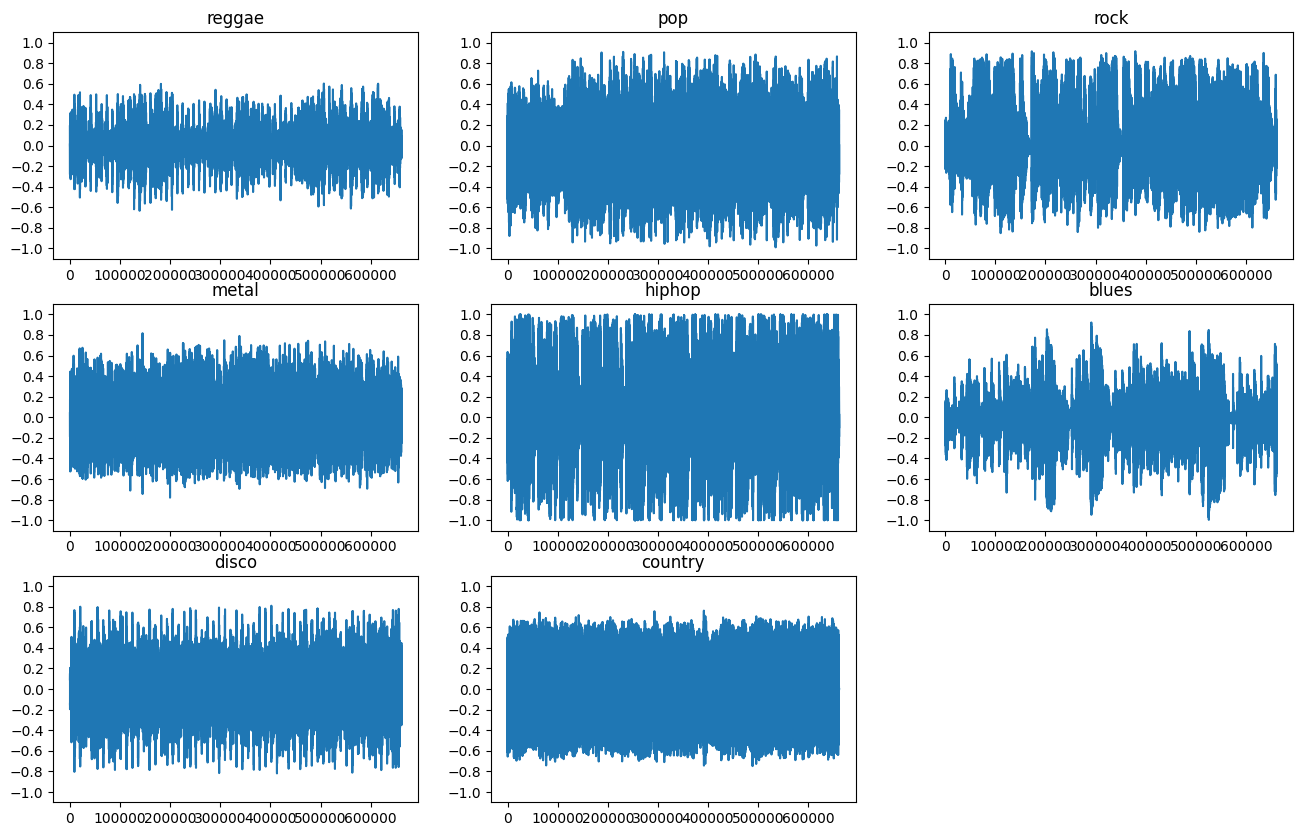

In [16]:
# Definieer label_names
label_names = {"blues": 0, "country": 1, "disco": 2, "hiphop": 3, "metal": 4, "pop": 5, "reggae": 6, "rock": 7}

# Definieer voorbeelden van elk genre voor EDA
example_audio = []
example_labels = []

for genre, audio_data in genre_audio_data.items():
    # Selecteer de eerste audio van elk genre
    example_clip = audio_data[0]

    # Voeg het voorbeeld toe aan de lijst met voorbeeldaudio en de bijbehorende label aan de lijst met voorbeeldlabels
    example_audio.append(example_clip)
    example_labels.append(label_names[genre])

# Zet de lijsten om naar numpy arrays
example_audio = np.array(example_audio)
example_labels = np.array(example_labels)

# EDA-code uitvoeren
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = min(rows * cols, len(example_audio))
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(list(label_names.keys())[list(label_names.values()).index(example_labels[i])])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

plt.show()

**Blues**

Hierboven worden de audiogolven van elk muziekgenre weergegeven, te beginnen met blues. Bluesmuziek staat bekend om zijn kalmte en rustig tempo, en dat is duidelijk te zien in de golven. Er zijn veel pieken en dalen, en de golfbewegingen blijven meestal binnen het bereik van -0.6 tot 0.6. Wanneer de golven boven de nul uitkomen, betekent dit dat het geluid een hogere amplitude heeft en dus luider is. Aan de andere kant, wanneer de golven onder nul gaan, betekent dit dat het geluid zachter is. Deze rustige en gestage golfpatronen weerspiegelen het typische gevoel van bluesmuziek.

**Country**

In de audiogolven van countrymuziek zien we minder variatie in amplitude over tijd in vergelijking met bluesmuziek. De golfpatronen blijven doorgaans tussen 0.6 en -0.6, wat betekent dat de amplitude binnen een beperkt bereik blijft. Een opvallend verschil tussen blues en country is de mate van variatie. Waar bij blues meer pieken en dalen te zien zijn, vertonen de golven van countrymuziek een constanter patroon.

**Disco**

In de audiogolven van disco zien we een constant patroon, meestal binnen het bereik van -0.4 tot 0.4. Maar, in tegenstelling tot countrymuziek, stijgen de pieken en dalen van de disco-golven verder boven dit constante patroon uit, vaak tot 0.8 en -0.8. Deze pieken en dalen die verder reiken dan het constante patroon kunnen wijzen op een energieker geluid. De hogere pieken suggereren luide passages in de muziek, terwijl de diepere dalen rustigere momenten kunnen vertegenwoordigen. Over het algemeen geeft dit patroon een gevoel van dynamiek en ritme aan de disco-muziek.

**HipHop**

Deze visualisatie van HipHop toont eerst een constant bereik tussen 0.6 en -0.6, vergelijkbaar met countrymuziek. Daarna worden de pieken en dalen veel sterker en gaan ze zelfs voorbij de 1 en onder de -1. Dit betekent dat hiphopmuziek vaak rustige stukken heeft, gevolgd door luide en dynamische delen. De diepe dalen zijn de rustigere momenten, terwijl de hoge pieken de luide en energieke delen van de muziek laten zien. Dit patroon draagt bij aan het ritmische en levendige karakter van hiphopmuziek.

**Metal**

Nu, laten we naar metal kijken. In deze visualisatie zien we een constant bereik tussen 0.4 en -0.4. Dit betekent dat metalmuziek over het algemeen luider is dan bijvoorbeeld blues of country, maar niet zo dynamisch als bijvoorbeeld hiphop. De constante golfvorm suggereert een voortdurende en intense geluidssterkte, wat kenmerkend is voor het genre. De relatief beperkte variatie in amplitude suggereert een consistent en krachtig geluid dat typerend is voor metal.

**Pop**

Laten we eens kijken naar popmuziek. In tegenstelling tot de eerdere genres, zien we hier geen constant patroon. De golfvormen variëren tussen 0.1 en -0.1, maar we zien ook pieken en dalen tot 1 en -1. Dit kan duiden op een gevarieerd geluid met zowel zachte als luide passages. Popmuziek staat erom bekend dynamisch en levendig te zijn, met wisselende volumes en intensiteit. Deze variatie in amplitude kan verschillende elementen van popmuziek weerspiegelen, zoals de opbouw van het nummer, het gebruik van instrumenten en de vocale stijl.

**Reggae**

Laten we eens kijken naar reggaemuziek. Hier zien we een constant patroon met golfvormen tussen 0.2 en -0.2. Dit constante niveau wordt gevolgd door pieken en dalen die variëren tussen 0.6 en -0.6. Dit kan worden geassocieerd met de karakteristieke ritmes van reggaemuziek. Het constante patroon kan de steady groove weerspiegelen die vaak te vinden is in reggaenummers. De daaropvolgende pieken en dalen kunnen wijzen op accenten of syncopatie die kenmerkend zijn voor reggaeritmes, waardoor de muziek een swingend en dansbaar gevoel krijgt.

**Rock**

Bij rockmuziek zien wij ten eerst een constant patroon tussen 0.6 en -0.6, waarbij ook pieken en dalen boven op het constante patroon verschijnen, variërend van 1 tot -1. Na ongeveer 1/3 van het nummer verandert het patroon volledig. Het constante patroon verdwijnt en er zijn alleen nog maar pieken en dalen zichtbaar, variërend tussen 0.6 en -0.6. Dit kan de overgang naar een luider en intenser deel van het nummer markeren, wat typerend is voor veel rocknummers.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Spectrogram</strong>
</div>


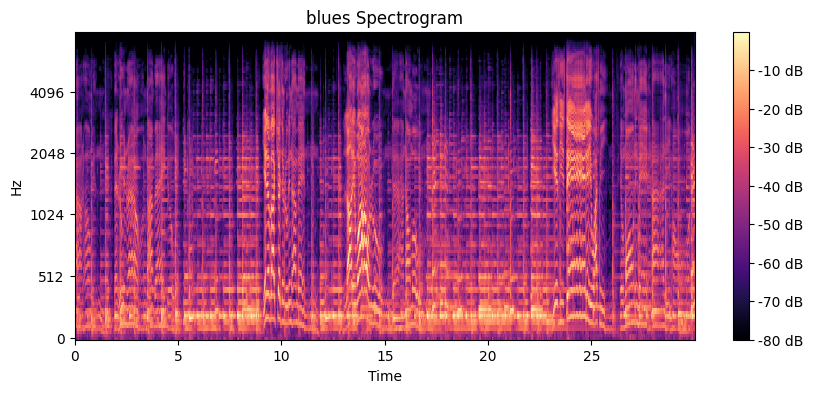

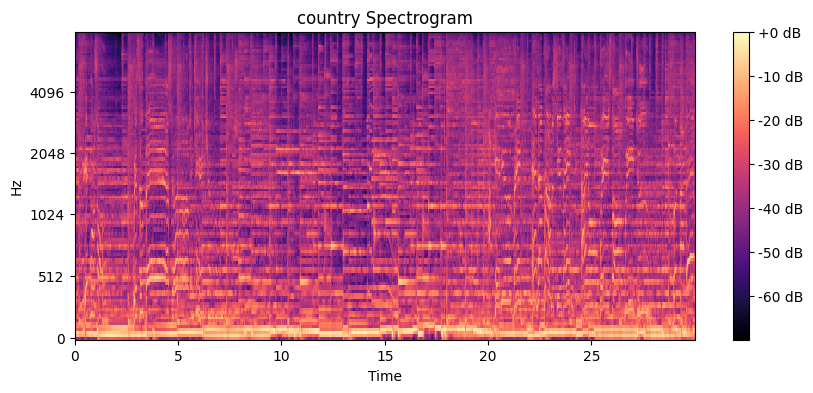

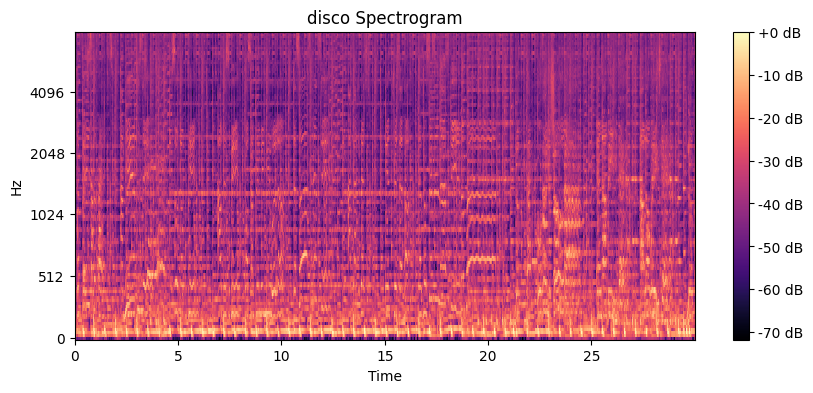

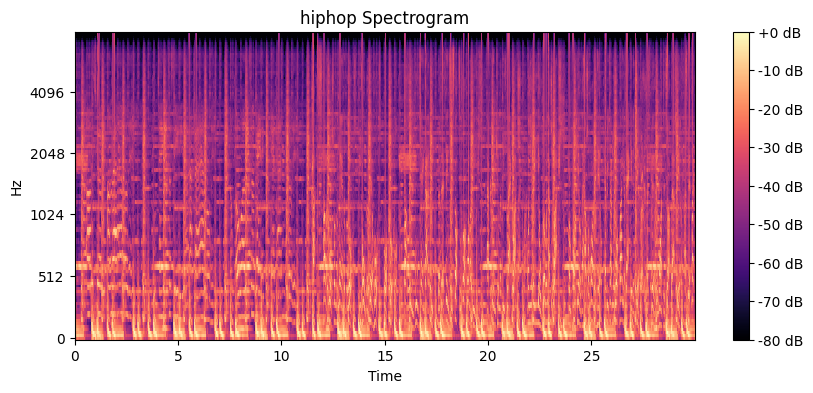

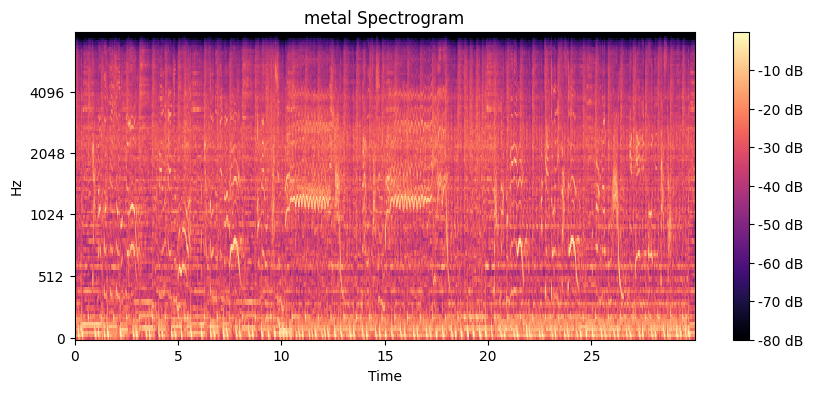

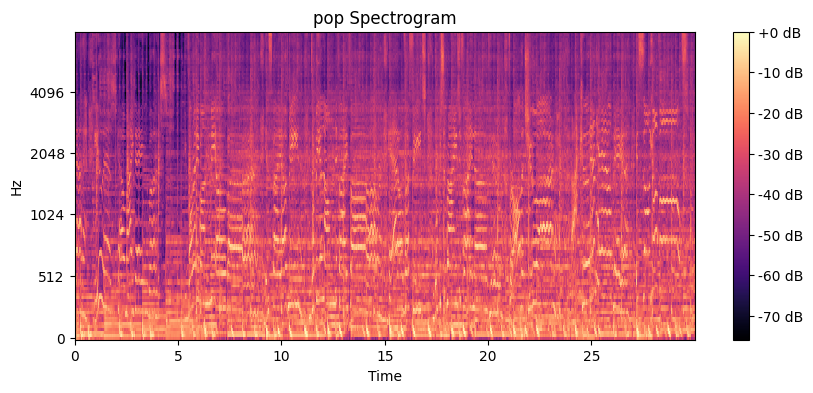

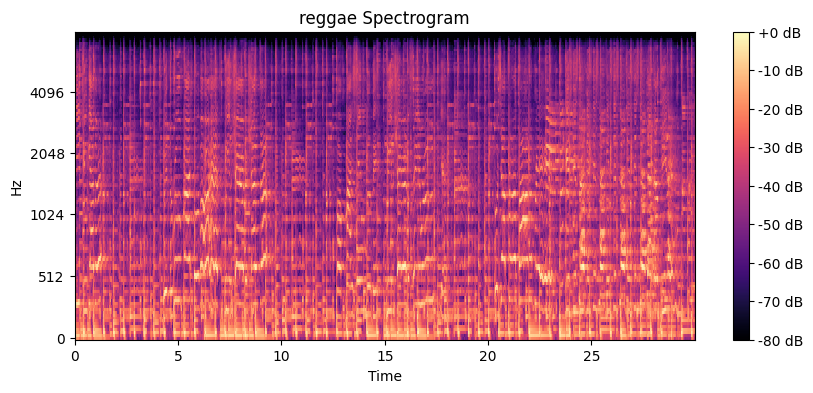

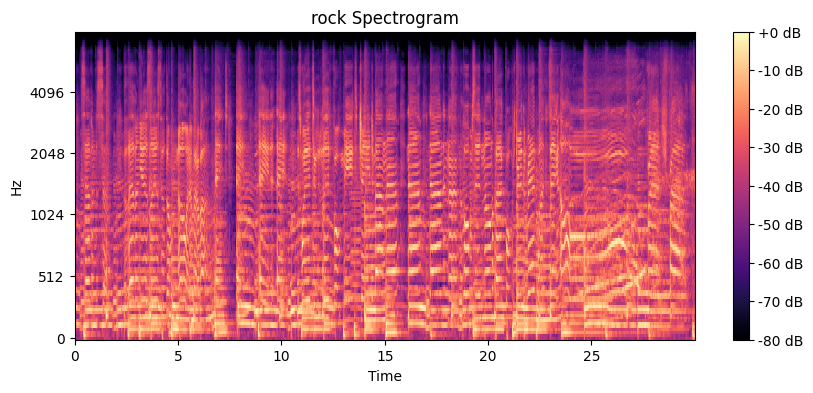

In [17]:


def plot_spectrogram(audio_data, sample_rate, genre):
    """
    Plot een spectrogram van de audio data.

    Parameters:
        audio_data (ndarray): De audiogegevens.
        sample_rate (int): De sample rate van de audio.
        genre (str): Het genre van de audio.

    Returns:
        None
    """
    plt.figure(figsize=(10, 4))
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{genre} Spectrogram')
    plt.show()


# Voorbeeldaudiobestand per genre
genres = ["blues", "country", "disco", "hiphop", "metal", "pop", "reggae", "rock"]

for genre in genres:
    audio_data = genre_audio_data[genre][0]
    sample_rate = genre_sample_freqs[genre][0]
    plot_spectrogram(audio_data, sample_rate, genre)


De spectrogrammen bieden een diepgaande kijk op de frequentie- en tijdskenmerken van verschillende muziekgenres. Laten we eens kijken naar hoe de spectrogrammen van verschillende genres eruit zien en wat ze ons vertellen:

**Blues**

Het spectrogram van bluesmuziek toont een geleidelijke afname van geluidssterkte naarmate de frequentie toeneemt. Dit betekent dat het geluid voornamelijk geconcentreerd is in lagere frequentiebereiken, wat typerend is voor bluesmuziek. De lagere geluidssterkte in hogere frequentiegebieden draagt bij aan de kalmte en zachtheid van het genre.

**Country**

Vergelijkbaar met blues, toont het spectrogram van countrymuziek ook een afname van geluidssterkte bij hogere frequenties, maar deze afname is minder steil. Dit suggereert dat countrymuziek helderder en levendiger klinkt dan bluesmuziek, met meer nadruk op hogere frequentiegebieden.

**Disco**

Het spectrogram van disco vertoont een gelijkenis met countrymuziek, maar met minder aanwezigheid van geluiden in het middelste frequentiebereik. Dit kan wijzen op een nadruk in disco op lage en hoge frequenties, terwijl middelhoge frequenties minder prominent aanwezig zijn.

**HipHop**

De lage frequenties in het spectrogram van hiphopmuziek vertonen een gematigd geluidsniveau, wat kan worden geassocieerd met baslijnen. De pieken in het middenfrequentiebereik kunnen corresponderen met drums of beats, terwijl de hogere frequenties waarschijnlijk gerelateerd zijn aan vocalen of melodische elementen.

**Metal**

Het brede frequentiebereik in het spectrogram van metalmuziek, met een gematigd geluidsniveau over het hele spectrum, weerspiegelt de complexiteit en dichtheid van de instrumentatie in metalnummers. Dit geeft de volle en rijke geluidsproductie weer die kenmerkend is voor dit genre.

**Pop**

Het spectrogram van popmuziek laat een typisch patroon zien, met een gematigd geluidsniveau in lagere frequenties, zoals basgeluiden en drums, en een lager geluidsniveau in hogere frequenties, zoals zang en melodieën. Dit weerspiegelt de productiestijl van popmuziek, waarbij ritmische elementen prominenter aanwezig zijn dan melodische elementen.

**Reggae**

Het spectrogram van reggaemuziek vertoont overeenkomsten met popmuziek, maar met een verhoogde geluidssterkte in het middenfrequentiebereik. Dit kan wijzen op een verhoogde aanwezigheid van ritmische en melodische elementen, wat kenmerkend is voor reggaemuziek.

**Rock**

Het spectrogram van rockmuziek vertoont een overgang van een gelijkmatig geluidsniveau over het gehele frequentiebereik naar lagere geluidsniveaus in bepaalde frequentiegebieden. Deze verandering kan duiden op een overgang naar meer gevarieerde instrumentatie en harmonische structuren binnen het genre.

In alle spectrogrammen kunnen we de unieke geluidssignaturen van elk genre zien, wat ons een dieper inzicht geeft in hun muzikale kenmerken en productiestijlen.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>MFCC</strong>
</div>

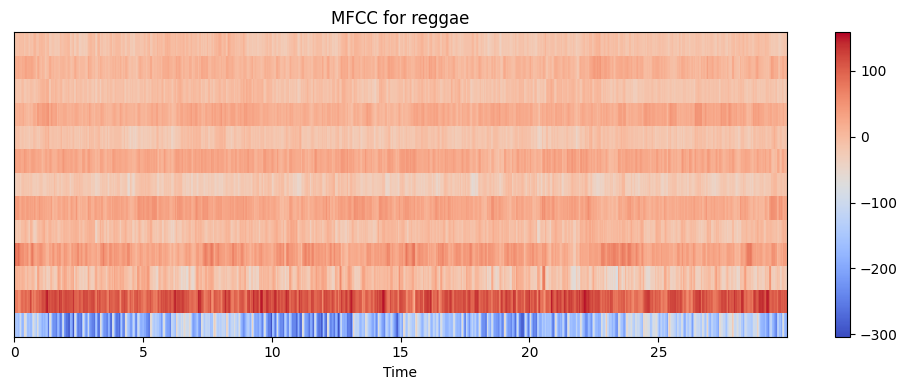

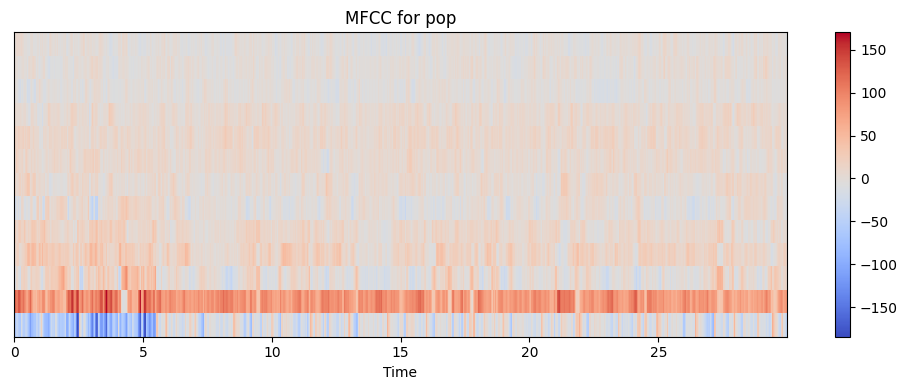

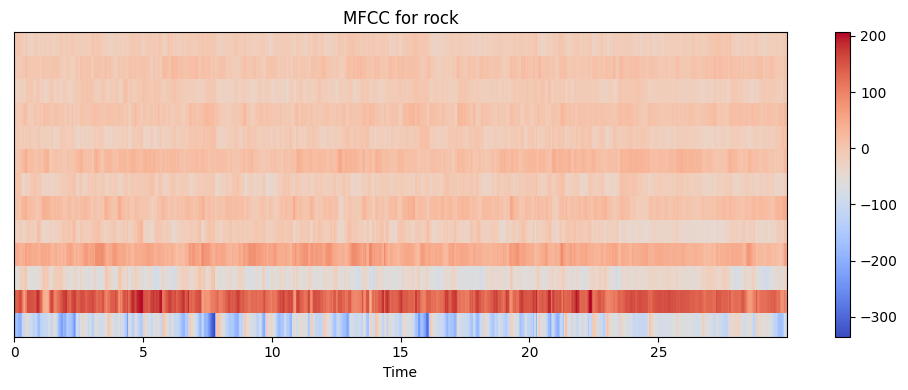

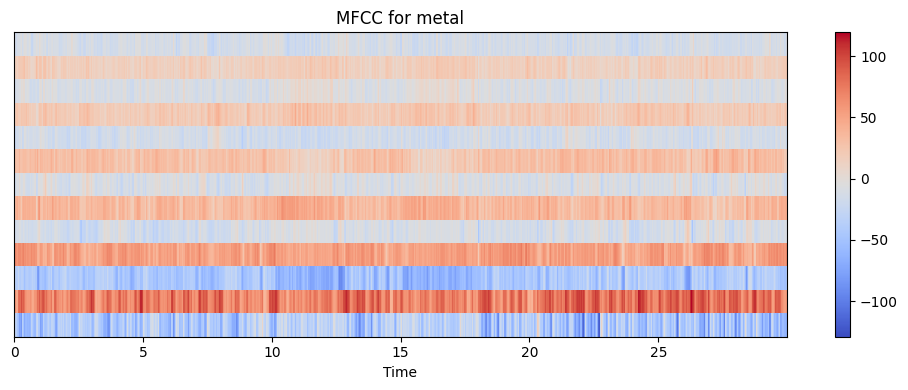

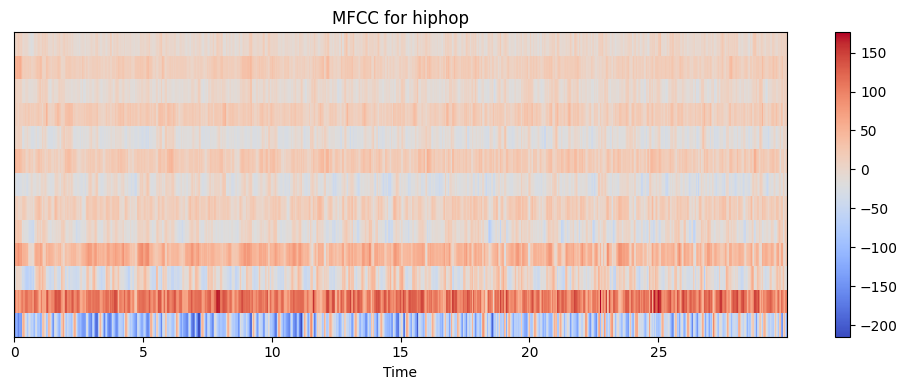

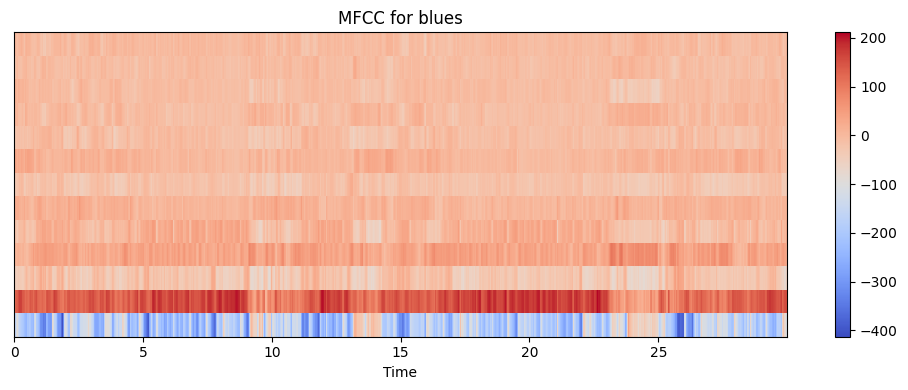

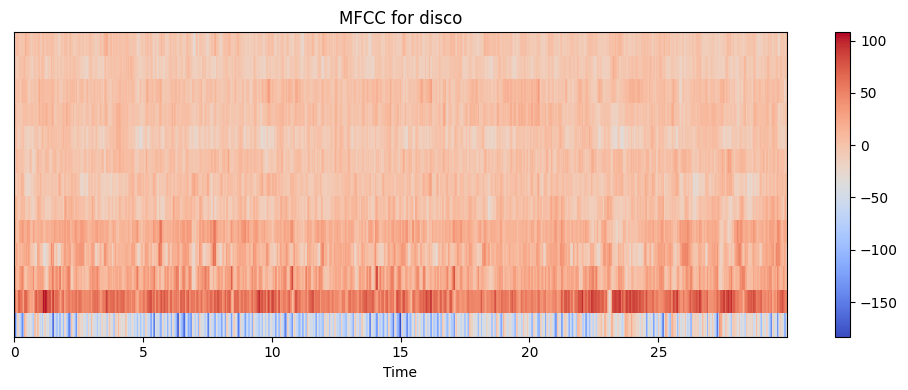

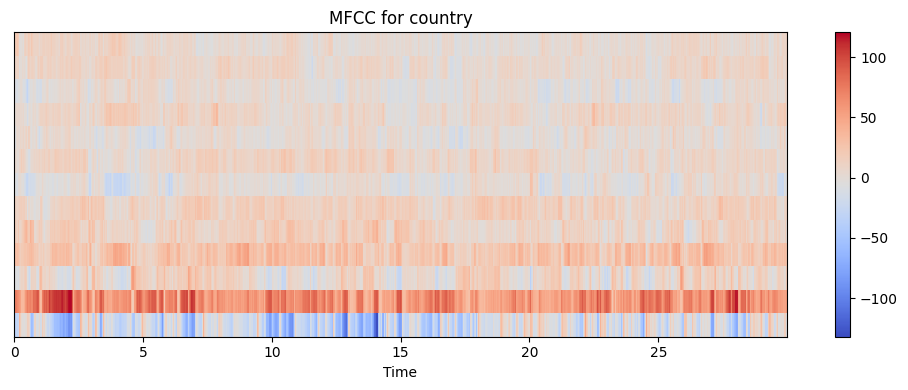

In [18]:


# Functie om MFCC's te berekenen en te plotten voor een specifiek genre
def plot_mfcc_for_genre(genre_audio_data, genre_sample_freqs, genre_name):
    example_audio_data = genre_audio_data[genre_name][0]
    example_sample_rate = genre_sample_freqs[genre_name][0]
    plot_mfcc(example_audio_data, example_sample_rate, genre_name)

# Functie om MFCC's te berekenen en te plotten
def plot_mfcc(audio_data, sample_rate, genre_name):
    # Bereken MFCC's
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

    # Plot MFCC's
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC for {genre_name}')
    plt.tight_layout()
    plt.show()

# Loop over elk genre en genereer MFCC-plots
for genre_name in genre_audio_data.keys():
    plot_mfcc_for_genre(genre_audio_data, genre_sample_freqs, genre_name)


In de visualisaties van de MFCC's (Mel-Frequency Cepstral Coefficients) zien we interessante patronen die kenmerkend zijn voor verschillende muziekgenres.

**Blues**

De bluesvisualisatie toont een nadruk op lagere frequenties, die worden vertegenwoordigd door de blauwe balkjes. Dit past goed bij het genre, waarin de basgitaar een prominente rol speelt. Hogere frequenties, mogelijk afkomstig van instrumenten zoals elektrische gitaren, worden weergegeven door de donkerrode balkjes. De concentratie van balkjes rond de 0 suggereert de aanwezigheid van vocale frequenties, wat typerend is voor de vocale expressie in bluesmuziek.

**Country**

Voor countrymuziek zien we een vergelijkbare trend, maar met een iets andere verdeling. De lagere balkjes vertegenwoordigen nog steeds basgeluiden, maar we zien ook donkerdere rode balkjes die hogere frequenties weergeven, zoals die van melodieën van bijvoorbeeld violen of banjo's. Stemfrequenties, essentieel voor de harmonieën in countrymuziek, worden weergegeven door de lichtblauwe balkjes.

**Disco**

Discomuziek vertoont een opvallende nadruk op ritme en percussie, zoals te zien is aan de donkere blauwe balkjes die lagere frequenties vertegenwoordigen. De lichtere blauwe balkjes vertegenwoordigen hogere frequenties, zoals die van melodieën en instrumenten zoals synthesizers en gitaren. Stemgeluiden zijn ook aanwezig, aangezien zang een belangrijk element is in discosongs.

**HipHop**

Bij hip-hop zien we diepe basgeluiden en ritmesecties weergegeven door lagere balkjes, terwijl hogere frequenties, zoals die van drumbeats en melodieën, worden vertegenwoordigd door rode balkjes. De variatie in frequenties weerspiegelt de complexe en ritmische aard van hip-hopmuziek.

**Metal**

Metal visualiseert een krachtig geluid met diepe basgeluiden, agressieve drums en intense gitaarmelodieën. De verschillende kleuren en hoogtes van de balkjes vertegenwoordigen de diversiteit aan instrumenten en geluiden die typisch zijn voor dit genre.

**Pop**

Popmuziek laat een evenwichtige mix zien van lagere en hogere frequenties, wat overeenkomt met de diverse geluiden en stijlen die vaak in popliedjes te horen zijn. Baslijnen en percussie worden vertegenwoordigd door lagere balkjes, terwijl hogere balkjes melodieën en vocale harmonieën aanduiden.

**Reggae**

Reggaemuziek toont diepe basgeluiden en percussieritmes, aangevuld met hogere frequenties van instrumenten zoals gitaren en keyboards. Stemgeluiden zijn prominent aanwezig, wat de nadruk op zang en harmonie in reggaemuziek weerspiegelt.

**Rock**

Tenslotte, rockmuziek wordt gekenmerkt door zware baslijnen, scherpe gitaarpartijen en energieke percussie. Deze elementen worden weerspiegeld in de frequentiepatronen van de visualisatie, waarbij lagere balkjes de bas- en ritmesecties vertegenwoordigen, terwijl hogere balkjes de gitaarpartijen en vocale harmonieën aanduiden.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Fast Fourier Transform</strong>
</div>


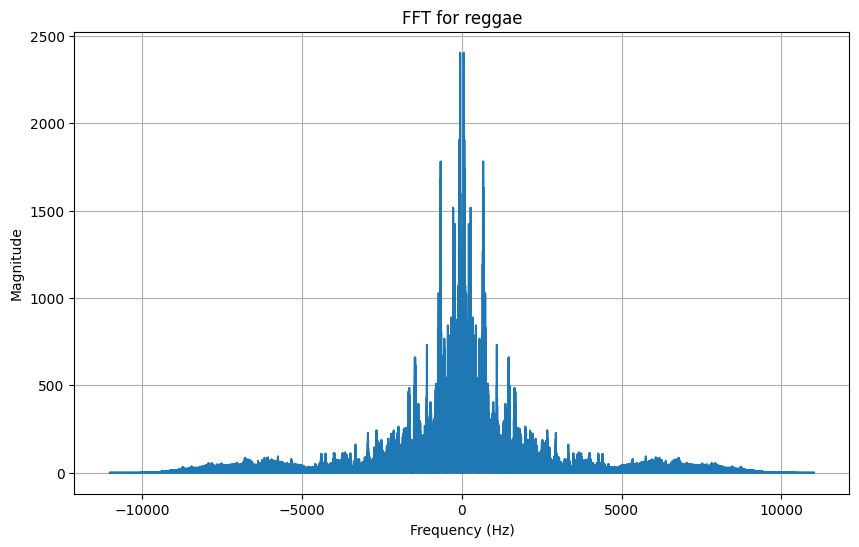

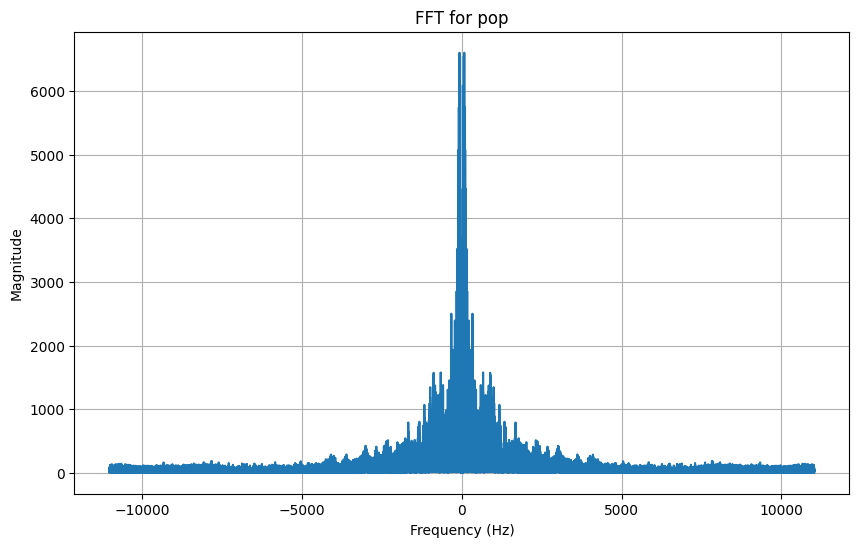

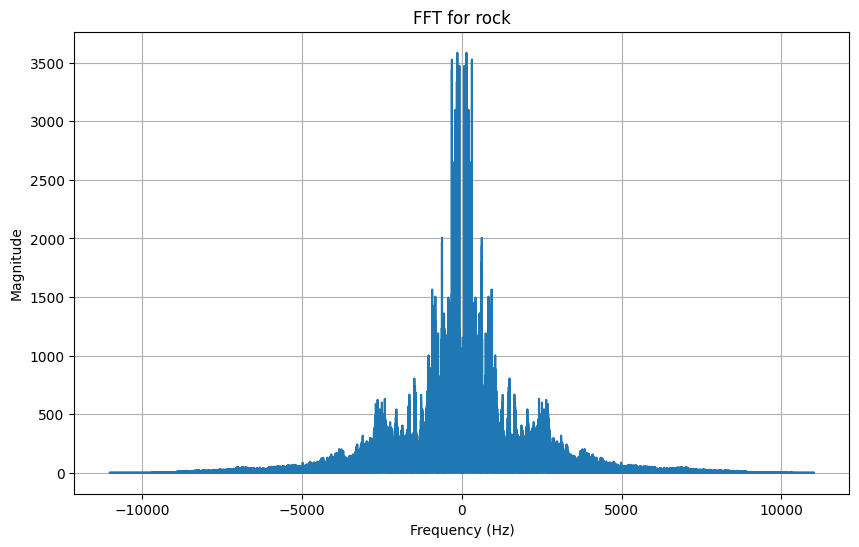

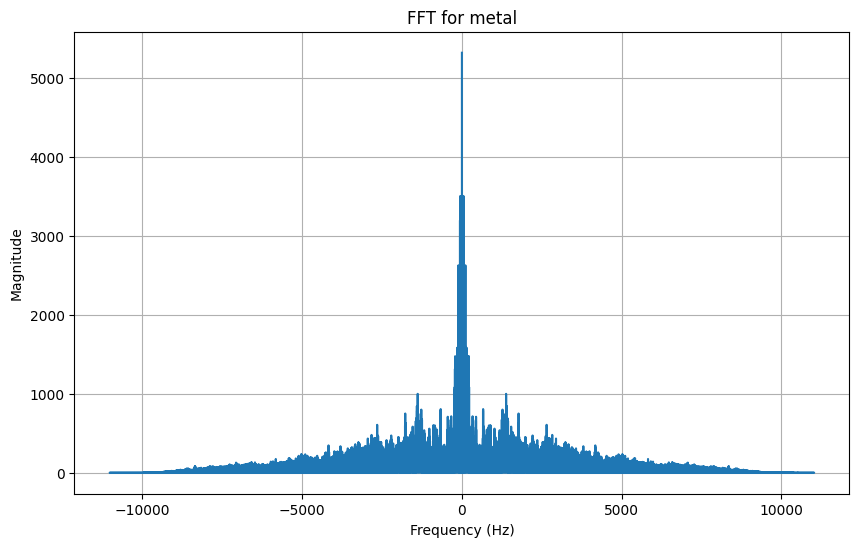

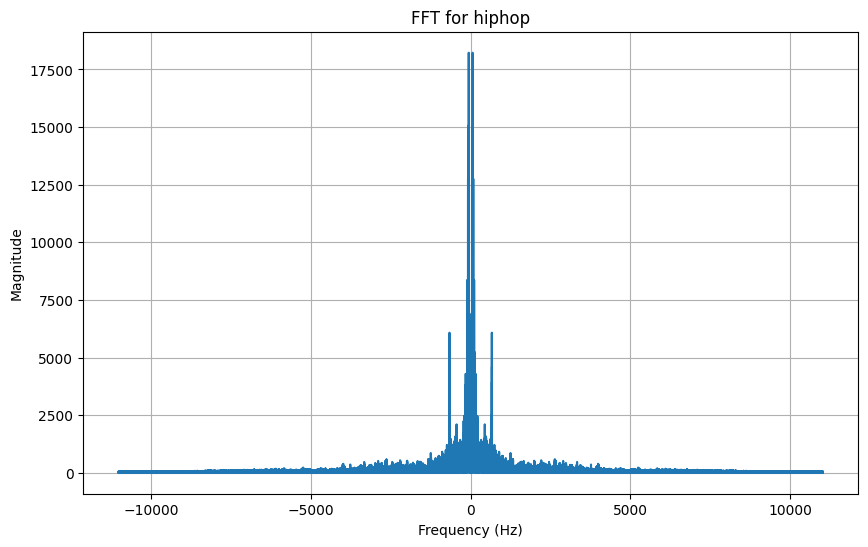

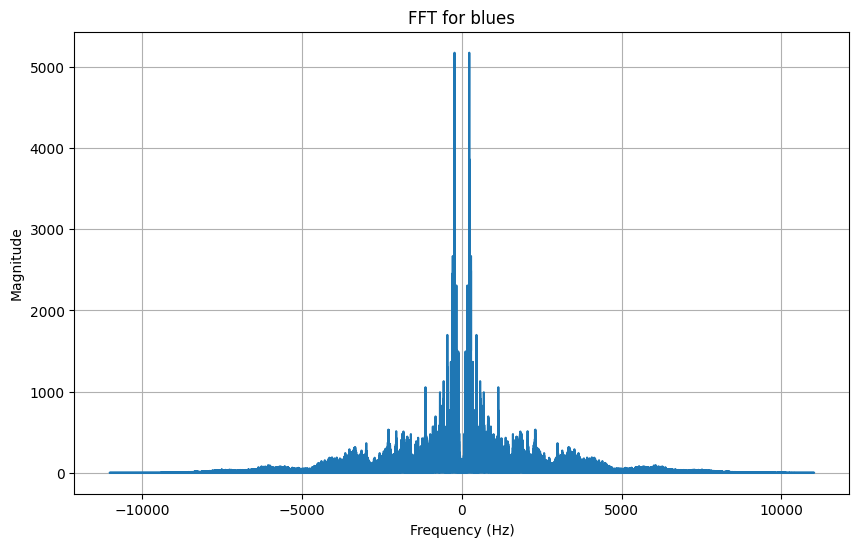

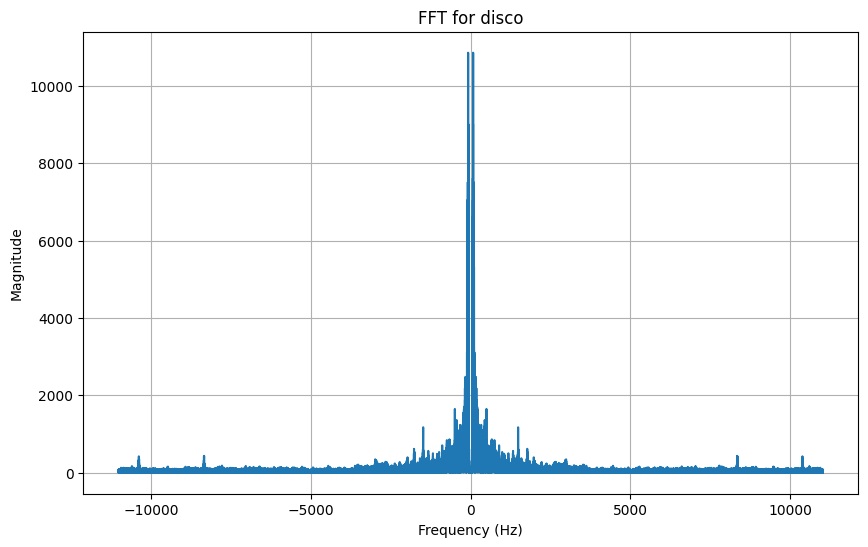

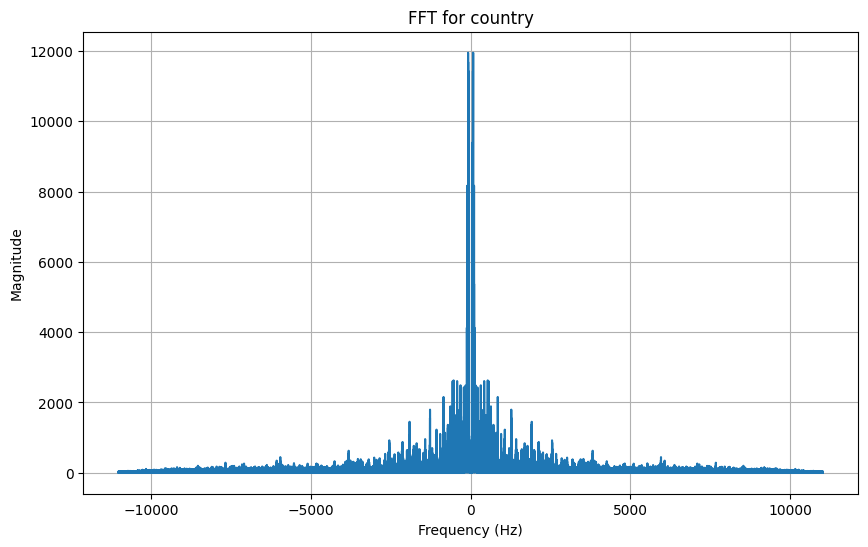

In [19]:


def compute_fft(audio_data, sample_rate):
    """
    Functie om de FFT (Fast Fourier Transform) te berekenen voor audiogegevens.

    Parameters:
        audio_data (ndarray): De audiogegevens.
        sample_rate (int): De sample rate van de audio.

    Returns:
        tuple: Een tuple bestaande uit frequenties en de FFT-uitvoer.
    """
    fft_output = np.fft.fft(audio_data)
    frequencies = np.fft.fftfreq(len(fft_output), 1 / sample_rate)

    return frequencies, fft_output


# Loop over each genre and compute FFT
for genre_name, audio_data in genre_audio_data.items():
    # Take the first audio sample from each genre
    example_audio_data = audio_data[0]
    example_sample_rate = genre_sample_freqs[genre_name][0]

    # Compute FFT
    frequencies, fft_output = compute_fft(example_audio_data, example_sample_rate)

    # Plot FFT
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, np.abs(fft_output))
    plt.title(f"FFT for {genre_name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()


<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Hoofdstuk 3: LSTM voor audioclips</strong></h2>
</div>

BRON: Stukken uit de les van week 7 (LSTM_voor_timeseries_data_–_classificatie_van_audioclips, 2024)



<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Beschrijving</strong>
</div>

We laden de data in een andere manier in dan we hiervoor hebben gedaan in het bestand. We verdelen de data niet op de traditionele train_test_split methode. Maar verdelen het in train en validation data. Deze data word gerunt in een redelijk kleine batchsize zodat het minder lang duurt bij het runnen van het model

In [20]:
data_dir = pathlib.Path("/content/drive/MyDrive/Colab_Notebooks/Data/Train")

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=8,
    validation_split=0.2,
    seed=0,
    output_sequence_length=30*22050,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [21]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)
train_ds.element_spec

(TensorSpec(shape=(None, 661500, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

We halen de data terug naar een kleinere dimensie met de methode squeeze.

In [22]:
def squeeze(audio, labels=None):
    audio = tf.squeeze(audio, axis=-1)
    if labels is not None:
        return audio, labels
    else:
        return audio

In [23]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [24]:
for audio, label in train_ds.take(1):
    print("Shape van audio:", audio.shape)
    print("Shape van label:", label.shape)

Shape van audio: (8, 661500)
Shape van label: (8,)


In [25]:
train_ds = train_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Hoofdstuk 3.1: Feature Engineering</strong></h2>
</div>


In [26]:
def get_spectrogram(waveform):
    """
    Converteert de waveform naar een spectrogram via een STFT (Short-Time Fourier Transform).

    Parameters:
        waveform (Tensor): De invoer waveform.

    Returns:
        Tensor: Het spectrogram van de waveform.
    """
    # Convert de waveform naar een spectrogram via een STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)

    # Verkrijg de magnitude van de STFT (gebruik tf.abs).
    spectrogram = tf.abs(spectrogram)

    # Voeg een `channels` dimensie toe, zodat het spectrogram kan worden gebruikt
    # als invoerdata die lijkt op een afbeelding met convolutielagen (die verwachten
    # vorm (`batch_size`, `height`, `width`, `channels`)).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram


In [27]:
def make_spec_ds(ds):
    """
    Creëert een dataset van spectrogrammen uit een dataset van audio samples.

    Parameters:
    -----------
    ds: tf.data.Dataset
        De dataset van audio samples.

    Returns:
    --------
    tf.data.Dataset
        Dataset van spectrogrammen.
    """
    def map_func(audio, *args):
        """
        Map functie om audio samples naar spectrogrammen te converteren.

        Parameters:
        -----------
        audio: Tensor
            Audio waveform.
        *args: tuple
            Extra argumenten, indien aanwezig.

        Returns:
        --------
        tuple of Tensor
            Als er extra argumenten zijn, wordt een tuple geretourneerd met
            het spectrogram en het eerste extra argument. Anders wordt alleen
            het spectrogram geretourneerd.
        """
        spectrogram = get_spectrogram(audio)
        if len(args) > 0:
            return spectrogram, args[0]
        else:
            return spectrogram
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [28]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

display(train_spectrogram_ds)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 2582, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
train_spectrogram_ds =train_spectrogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

display(train_spectrogram_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2582, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Beschrijving</strong>
</div>

We maken als feature spectrogrammen van de audio golven. Dit gebruiken we om van de spectrogrammen weer de MFCCS afteleiden. De make_spec functie en codeline hierboven zorgen ervoor dat het wordt aangepast op onze data

In [30]:
for audio_batch, label_batch in train_spectrogram_ds.take(1):
    print("Shape of an audio sample:", audio_batch[0].shape)

Shape of an audio sample: (2582, 257, 1)


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Maken van de MFFCS</strong>
</div>
bron: functie van de les

In [31]:
def spectrogram_to_mfcc(spectrograms, num_mel_bins=128, num_coefficients=20, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the MFCCs with shape (batch_size, num_frames, num_coefficients).
    """
    # Remove the last dimension (channel dimension, if it's 1)
    spectrograms = tf.squeeze(spectrograms, axis=-1)

    # Compute Mel spectrograms
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    # Shape tuning for the mel spectrograms as expected
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))

    # Logarithmic scaling
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]

    return mfccs

In [32]:
def make_MFCC_ds(ds):
    """
    Convert a spectrogram dataset into a dataset of Mel-frequency cepstral coefficients (MFCCs).

    Parameters:
    ds (tf.data.Dataset): The input spectrogram dataset.

    Returns:
    --------
    tf.data.Dataset: The dataset of MFCCs.
    """
    def map_func(spectrogram, *args):
        mfcc = spectrogram_to_mfcc(spectrogram)
        if len(args) > 0:
            return mfcc, args[0]
        else:
            return mfcc
    return ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
train_MFCC_ds = make_MFCC_ds(train_spectrogram_ds)
val_MFCC_ds = make_MFCC_ds(val_spectrogram_ds)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Beschrijving</strong>
</div>

Hierboven maken we van de eerder gedefineerde spectrogrammen, MFCCS per audio clip. Dit geeft nogmeer informatie over de audio clips en zorgt ervoor dat het model duidelijkere patronen kan herkennen

In [34]:
for example_MFCC, example_MFCC_labels in train_MFCC_ds.take(1):
    break

display(example_MFCC)

<tf.Tensor: shape=(8, 2582, 20), dtype=float32, numpy=
array([[[-2.2488632e+01,  8.9831918e-01, -2.2716100e+00, ...,
         -7.7504212e-01,  4.0743998e-01,  7.9173183e-01],
        [-2.3655714e+01,  3.0385430e+00, -3.2976022e+00, ...,
         -3.3972216e-01,  4.7949174e-01, -4.1209042e-02],
        [-2.2391365e+01,  1.2953576e+00, -3.5237527e+00, ...,
         -3.6398482e-01, -2.2902820e-01,  3.1744063e-01],
        ...,
        [-1.4003166e+01,  3.5691684e-01, -4.1937971e+00, ...,
         -1.6797739e-01,  3.0442637e-01,  1.1760650e+00],
        [-1.6399899e+01,  1.7041435e+00, -4.8247743e+00, ...,
          4.5927522e-01,  2.5317660e-01,  9.4309881e-02],
        [-1.7669575e+01,  1.0505618e+00, -1.7076080e+00, ...,
          1.3080732e+00, -1.5577561e-01,  6.3021101e-02]],

       [[-3.5448814e+01,  1.0292784e+01, -5.1607089e+00, ...,
         -1.2700999e-01, -7.7737665e-01,  1.4292161e+00],
        [-3.6776321e+01,  9.8504076e+00, -5.1179390e+00, ...,
         -1.1806717e+00, -3.

In [35]:
train_MFCC_ds = train_MFCC_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

display(train_MFCC_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2582, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
for audio_batch, label_batch in train_MFCC_ds.take(1):
    print("Shape of an audio sample:", audio_batch[0].shape)

Shape of an audio sample: (2582, 20)


In [37]:
val_MFCC_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2582, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# <a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Hoofdstuk 3.2: Modelleren</strong></h2>
</div>

In [40]:
input_shape = example_MFCC.shape[1:]

model= models.Sequential([
    layers.Input(shape=input_shape),
    Bidirectional(LSTM(128, return_sequences=True,)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True,)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(32, return_sequences=True,)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(16, return_sequences=False,)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 2582, 256)         152576    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 2582, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 2582, 256)         1024      
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 2582, 128)         164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 2582, 128)         0         
                                                        

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Model Architechtuur</strong>
</div>

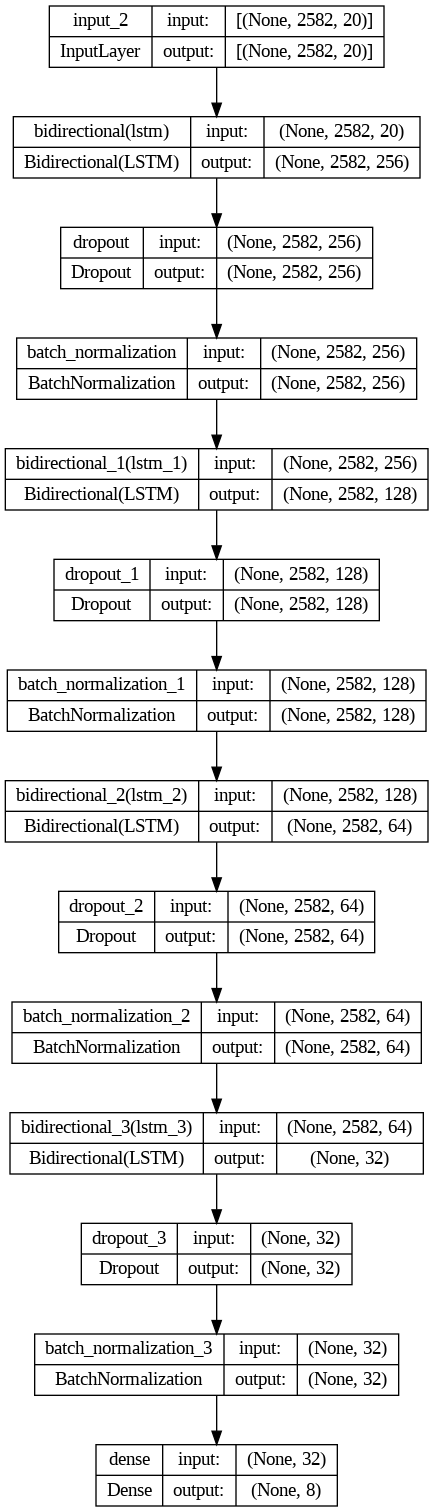

In [41]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Model Trainen</strong>
</div>

In [42]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])
history = model.fit(train_MFCC_ds, epochs=25, validation_data=val_MFCC_ds, batch_size=30)

![afbeelding.png](data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABSAAAAMGCAYAAADiMCoAAAAgAElEQVR4Xuy9P6hWx7f/v7+FKY4WEhARlG8ECYgJCiIkqYKkEcQizUGuQQi3j8UpJNaGU9jYS0CixWlSiGAjkpBLriAf0Mu1E05AQUTzIYXaWHx/rCe/9WTOuGZmzd7zPM8+57yeRjx79vx5zZp/771m5v/83//7f/9fxw8CEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAwAwI/B8EyBlQJUoIQAACEIAABCAAAQhAAAIQgAAEIAABCEBgQgABEkOAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEZkYAAXJmaIkYAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQQIDEBiAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAIGZEUCAnBlaIoYABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQQILEBCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAYGYEECBnhpaIIQABCEAAAhCAAAQgAAEIQAACEIAABCAAgS0pQB49erRbWVnpHj9+3K2uri6slg8cONBdunSpe/369SQ//CAAAQhAAAIQgAAEIAABCEAAAhCAAAQgsN0IIEDOsMZPnz7dLS8vd2tra93t27dnmBJRQwACEIAABCAAAQhAAAIQgAAEIAABCEBgnAQGCZDnz5/vzpw5Y5bs1q1b3fXr1xdS6ll5QGp537592125cqV79OhRtnwSZteuXd3ly5e7p0+fbggr4uS5c+cmf7tx44YpUF68eLE7ceLE9L319XXTk1LSOXjw4DTcgwcPFur5uZBKJ1EIQAACEIAABCAAAQhAAAIQgAAEIACBURJoIkAuUmy0qLYWIDW+Fy9eTJLbu3dvUYBM5UG3ZUs8z58/7w4fPmwKkCIq7t+/f/pMBctnz55NRUiNa+fOndP8qEiKCDnK9kamIAABCEAAAhCAAAQgAAEIQAACEIDAtiMwcwFShbi7d+92+/btm3r0pbwIvd58sXdgKLiF4p/UqHoRej0XQytQke+///u/Jx6dkj+PACn5O3LkyHtCpbz/6tWriYeihDl27Nh7AqSKjXfu3NngRSri4qlTp6bh4/9rvlNpbzvrpsAQgAAEIAABCEAAAhCAAAQgAAEIQAACCycwNwFyaWmpe/ny5WQ7svzkchb56fZkFQ3fvHkz/VvO62/37t0bhLsLFy50T548mWxl1risNIdeCOMRIL2Xz6QESEtA1Dj37NnTqdhqbfEOyz42z9SFWzsZgAAEIAABCEAAAhCAAAQgAAEIQAACEJg7gbkJkKGwKKWMvfdSXnuxSJfy+gvJWWKmPG/hGegRIL2Xz6QEyFhY1PKIwCpepCKiXr169b0btlWwvX//fnf8+PGF3wI+d2smQQhAAAIQgAAEIAABCEAAAhCAAAQgAIHREWgiQMalevfu3dQ7MXUWYrjN+N69e+95RGqc8Xbk3MUu+k4qzXkJkJ48qiBqbcEO3z958uR027VceiOeo5YAGZZN4l5ZWUGAHF1zI0MQgAAEIAABCEAAAhCAAAQgAAEIQGD7EWgiQOa2+tYIkNb2aBUgHz582N28efM9rz+ryhYpQIZnXpZuAS95QMolNYcOHZqeIxlu7Q49IIVBeNt260t4tl+zoMQQgAAEIAABCEAAAhCAAAQgAAEIQAACrQhsGgFSL2TxeBcuUoCs8bLMnQEpF+fomZlPnz6d1HdcLr2wZ319fXoztoRLXWLTymiIBwIQgAAEIAABCEAAAhCAAAQgAAEIQAACXgILEyBjoS53BmR4m3RKtAsLvCgB0nv5jOaVW7C9Zko4CEAAAhCAAAQgAAEIQAACEIAABCAAgc1KYCECZLitenV1dcJORcMXL15Mvfly4eQd8QCUcxHlZ92C/fjx407jlzA13ompCs1dQuO5ICeMNyemxulYLFTwlDj1NnHJw5kzZzpuwN6sTZJ8QwACEIAABCAAAQhAAAIQgAAEIACBrUWgiQBpIVEBTIXFpaWlDcEsgcwKa4VT4W3Pnj3TOB88eDAVG1t7QOpWZ6uc4fZnz/ZwER1le7X1i7dcx+mGZdT3LRaIj1urkVIaCEAAAhCAAAQgAAEIQAACEIAABCCwmQkMEiA9Bd8uF6LUXD7j4UYYCEAAAhCAAAQgAAEIQAACEIAABCAAAQhsBQIIkI1qscX27kZZIRoIQAACEIAABCAAAQhAAAIQgAAEIAABCIyGAALkaKqCjEAAAhCAAAQgAAEIQAACEIAABCAAAQhAYOsRQIDcenVKiSAAAQhAAAIQgAAEIAABCEAAAhCAAAQgMBoCMxcgR1NSMgIBCEAAAhCAAAQgAAEIQAACEIAABCAAAQjMnQAC5NyRkyAEIAABCEAAAhCAAAQgAAEIQAACEIAABLYPAQTI7VPXlBQCEIAABCAAAQhAAAIQgAAEIAABCEAAAnMngAA5d+QkCAEIQAACEIAABCAAAQhAAAIQgAAEIACB7UMAAXL71DUlhQAEIAABCEAAAhCAAAQgAAEIQAACEIDA3AkgQM4dOQlCAAIQgAAEIAABCEAAAhCAAAQgAAEIQGD7EECA3D51TUkhAAEIQAACEIAABCAAAQhAAAIQgAAEIDB3AqMWIA8cONBdunSpe/36dbeysjJ3OGGCp0+f7s6dO9ft2LFj8ud37951N27c6G7fvr3QfJE4BCAAASVw8eLF7sSJE1MgL1++7C5fvtw9ffoUSCMmcP78+e7UqVOMKYk6Ej5nzpyZPl1fX1/4nGDE5kTWIAABCFQT0DXXnj17mqxzrly50h08eHCaj1u3bnXXr1+vzhcvQGAogXgNz9x4KFHeh8AwAqMWIKXDWF5e7tbW1hYu9GnndefOHQbQYTbH2xCAwBwIyOR/165dCJBzYD00Cakr+fX50Hb06NHJe48fP+5WV1eHZmXU74/po+SoQZE5CEAAAgMItPwoxvppQEXwanMCzI2bIyVCCFQTGCRAxl4Jmvrbt287aeCPHj16L0PqoZMLoy9ZnUTs4aNhc18zatJMEWQArbYtXoAABBZIYEyTLBXJlpaWpkRS3hDa10rAlJe5NfbMy7uixXgSmsXQsQUBcoGNrHHSNe3Ek3TsgRR7jsYeTxqn1ZbivOV2geBt4qmd7RcmtscHDx70+mhS005CG8+ll7PZmnayVWoVAbKuJr125ok1bifWejm2V4k3Zd81/bGmvZU9BMc0N/bYA2FsArEe1HdnjKUrWXF5PcQ9O9FqxrCtWv+DBciabWNhJ1gSIFOLKqnYI0eOJAXOuKJq0sxV8tBF4lY1IMoFAQiMk8BYJlnal9+9e3fqPa4DdCh06OAuNJ8/f94dPnzYFCDl3WPHjm14ZsU3i1ppNZ6Eeasd0+JyIUDOoqbnH6e3nXhzFnvVqu0+e/Ys62lrtSXrXYl///7977XR1N+9+Sbc1iOgffvOnTunc3f9iFQrQta0Ex0r7t+/33322Wfdw4cPTcGzj83Oa8xZlDUgQPrJe+2sFGM4B9Kjc3JtJ5w/pdpTjW2HH3YRIEu1xfNFEojt2ju/8eTZikvHnRcvXkznT9pewnYofcFHH3003Xmm77158+a9v5XWRJ68buYwcxUgdUEsi8tDhw5lRcTUoqx2sVaTJgLkZjZl8g4BCIQExiJAWrViDeaS31evXk0WiJbIKPGktuCmRLhWHjdaBs94UpNmSTzMfeFN7QbQvMYL+/iLa/wRMDzy5Msvv5ye3TWmhYhnC7bnq7jXmy/2HMl9OK1Z6Hl7KqudeN+1wkke9+7dm517WTZp9SVWXbQULYaU03rX8mJLiV+xDVnhSt4Q1lw1Zhsy/OWXXzacMx6n2SL/lpihrNTWY5HOWkDV1k3KLmrn86l0U4vDzz//fLLok+dyhrslQPa12VLfXcuoT/hUnUlc1hha8ogO89CXi1WOkgNH6/7YOwa3sm2PnXnqN8UprotZ9MdhXyR5XfTxPZa4E87DwnGspm+UOFrMjWvSnNd4ou1enLSuXbvWnT17ttPzXON5XE3+U2dw9xlPlL/18dLTRiSMt51440vNlcI2kGtz8n7urP3UeiZMt/Vcb0jZ5/Xu3ATIsAP95JNPsl6MuUVGzYSlJs0S8NIAWnqf5xCAAATmSaDFJGtW+S0NtiUBMh7wrf7ZElt++OGH7vfff+91prBnPKlNM7fIS3l6yge88CB/z0LYWqjGeQ3FNt1+UqqnWdlHKt7c3MCaDOe+PodfsiXcN9980129enV6YZPFTP72xRdfdN9///2GLIYL6FqPrhzD1vz7CJAp+9JFiYqy//73v0dzaaDFNG77lseQ2tDu3bs3eHZeuHChe/LkybTfUNv466+/pgsPeffbb7/tfvzxx4kN1QiQskgMt7Rbi+9W+U8t7FN9roYfcvGiNRaFbWbo8RmldpIS6jwfNFLt09Pvzrp/tDzmJE2rXFK/4dhR8hialwBptcOcF3YoIlv9cc0Y3MK2wzrOCcIeW0i9H/clVhlzHzc8Z0uHachYuGgBMtWmrXbn6RtD/i3mxp405z2eSBlDsVPnIhZLT/4lPhXzY29beSbz0NrxpMVcyRpbWx6BoOXWNiD/T12I7NGkECDt3m+wABneTClJWB4CcYdRqrDQEyO+Zdry+rA8NGrTLA0OJQEy542iEzc5E1OMWL9IxGlqOU6ePLnhxs84nHYEnjRlIiyDT3j2WhifLjRT53lqWEnz3r17rvx/+OGHrjQ9+YfZ3zWg9QSzrtN2gp39bRupxVuLSVapX+z7vDRRzw3Y+q70q1JGmXiId0u4tXTIwtIqk2c86ZOm5F9+1gLBW3+ehXBOANDLa1IL0tJ43dcG+ryXY5xaMMcT5NJYrvmqXYDPwgOy1E5qGKbEijiOlDAdXsCnNvGvf/1rsrVVzmrVuYYIdfv27dswzxkqMNWU0xvW4uGtc0/brBEgw63Jkn9Pm+6bf2sxmmtXQ73ErLjVrmVr9PHjxwdfoFVqJyXvzj426xHzvbY4JJw1Vnr7uFwZvG3Bk/dUflJ219e2a8fgobYdl71khx5WOseP5/xhH6r53rFjx4a+19rm6bHtuH48/ZunLEPDWPbpscvSWDeL8vW1WWHkyY9nPJG4LPHek4aVf08/UjueaF6GeEDGvDQPauuvX7/udaFjOPcTbStsc6k68oiLnrGiRd8xtL3N+/1BAmSc2ZTaHzec0oLG0xg1bTU8NWq9+KY2zRJ4T0MsxcFzCEAAAvMiUNOPzitPkk5qnAjzUBrU4+0jlteZfrntezB1nJ/w7OHUGFaTZmlM0YlkaQt0SaxIPY8Xa/PY1jLUznILzNQkLy6/1/NKeUieU5chDS1P7n1PO6lJX+0p11YkvtjTLbQL/QipE/xwMSjvyoeAmFdqQVST91mFjftIT59Zam+aV8+CsbRQLpW7T/51rhxuYSz1RaV8eOxYbSbkIu/Jxxf9CNInHU87SS3uUm08t4g/ePDgJJtDPEL7lDP1jmWPpTVWzkb1mUfo8ZYjZV+5RXdcBm9/XDMGe/PvDddKRNB4RGDM2ZmWVfIXz3NqbLtvP+Ll0jecZTeePlr7uJQXpzeO2nz34dhyPJH8lubOuTLF+ff2I56PlrUsvfkUhy29i0QdlvoIkLETVjxPsjy1PX2Svpdbh3jGsJb8xhJXUwFSChV3wFYHkjNqbYzh4ZwlWB4PB29DSqU1ywlaqXw8hwAEIFBLYOgky/KKLolhpTyGwmHOK8rjAanbH9Vj3PK+jz2G+2yPrR3DvGlKuPCwaotd6uydMGxpAhsuZqw0dGLUWoC00i1dPue1H2uCmbL33Bd63Y2QWuSFYqXkbWj+S+XT59524o0v9qrJvaf1ph7F+n/LW80SIONz9mq9ksK8hQts/XufNhzOTWVRH/60T5O/pbZZheG9c8HWAmSqHdfmP2ShXq2evshra3G4sP7lWSgKlPquUpredlISIPvYbNxOSnkNn8cf0PRZX0/hsO9TO/7jjz82XLgT92WaZqpPm6cAGXpXa76sOYC3P/aOwTV15gnbQoCMPxRZgmrseKO7QCSP+rEslZe4P7bqecjcseW4H+c1pQ+U+kbxzo/HlaFbzEtpLmI8kTS9AmQp/8LMawfxmDjL8UTKqPmK7xMZMtew+ud4Z0I8H5exN3eniYbPrZu8Y5in/9lsYZoLkOFkX85TsiZ0OTGwj1AYdrQ3b96sTtNTaaVJZzzghXGyBXsjYbYT/8OD7cQbbYOt/v/wqDkeITwTUGPwTh48/V+rMDqZLokIqUlUastUaTEYDvKltK2JSCx4ecapXJp9Ft4pz45SXKXnWt7WAmQrm/HURzgpjQ8DL5Xf8xVb4o/PPNTdFrMop7edeNL2TILjeCwvNTnGJRZIPN5srRYFnrKmwqT6h0V7rHg9IFvmXxiFdaLz9FiwGsI7fjfVd5Xm1aU8eNtJSozxeoen8uEZB0plaPE8/hCwvLzcra2tTc8sTY2bufyPQYAMdx3EnDz9cd9xv2+dDBUgLS8ryUvokate6KljG3Qbth5RFHsXh23/p59+Mj2QxzR3DG302LFj3VdffbXhEjVv3xjW6dDyedP0pFOan2i+PR+01FaEU27Xhjf/3v5t3uOJtodY2POy9LRv79iUqmN9X4+KSs0XvWOYJ8+bLUxzATL0Rvzzzz833OpnwQm/vvWdqIaLVUlDtgHFX7nDtPt4MXiNcbMZAPmFAAS2JgHP5GeeJa8ZaFMCZGri5DnLqc/4kvpK7B1PUmn2XdxZdVoqV+m5liU1xo3JjnJlyZ0BqVt04jOlS2W3Fr2puITTkHONNC1vO/F8Oe8jPuoiJlz8e+wuVTctFwV9+6tUf2JtOSst3ryiobV4iwWGmrisfPXJvzKUvMhiXnYbyb+hYBVy9vStpXpJtc3UAtezePO2E8mb1xtMy+G1We8CvcRn6HO1IxGR5Rd71se7xDS9RQuQqT7DO2Z5xtFcXC1sO6w7jwCZ65NDoTH8qBz2G+ItKscWhOc9Sh60nCpMpi4FC21bvLfiexxiWxy662WobYdej59++ukkuvDMbG/fHuZj6JzGm6bHG7FmDIgFeUuw9qTpzX+q37Dq1DueyLtD50q1H8s940lcJo/mU/LIRXzMt/6mAmTJC6U06HkGE2tBIB1oyatl6ETBY4xDO1rehwAEINCKwNBJVqt86IRDzs4q9dPhGGEtuHWyFt9SG29bkomB51bjvmVMfY32pOlZXEmY7777rhMPBf1yam0l1vyXJnQpzwpr8RRuh6uZgPZlWfNejp01kbeYSZnkkpTV1dVp0taEXP4W3zgunMOz8zSCcGug18atcvcRVeRjq3W+UF/x0bIVa2FtsbDsJcWspt6Hhk0Jf7IFP1xgx1sbte3Ft2BrfCF3sb/wFuyYRbh9S23Eu/hsnX/hGdps7nwqTXvImYdWOXN9S7ijyNqWXNNOpKw5YaivzXr61KF2W/O+MPv4448nr/z666+TG2r1Z63NlOEit2BL/iz+ffvj2nG/hW1bY2i8pT8Mo9yt9qT1pMfLyDZYa86jccQ3E8taOGzLfW17THNHnT/KlukPPvig+/nnn6eevaH9xH1q3LfHdTBkC3br/rjVeCJl9AiQ3vyn5tvyvvzCPsY7nrScK1nnGFttrzSexP2s58NEqv/3ip21Y1jNWLBZwg4SIMNK1QJ7zjBJiYGeTk8rTdPzTooQIDeLSZJPCECgBQFPf9oinVIcJS9CHTOs8UTjDkWC0PMrTDsee6x0PeNTqTw6ybO2h3nS9H7Mss7sSolbFpM4rJW3cPwsPfdwmVWYeNxP1buHg9bfiRMnptGkFuFxujlvkJIIXGLjbScaT84DMtVG9F1dpFo2lmIR5y8nXIReNYv2oNEyx/2L9AXiURMvRL02FPOw5qJhmsLr2rVr3dmzZzvd7uwVIC2bHZp/idMSMvosxkq2Lc8trqn+OLeI87aTXLi4rkJxWPKa2tonxxDor89OKg+nvmFKC9+4jDI+yC8cx3LMatux1bek2MV5G9Ife8ZgzYdHaCjVR42dSVylD0NWfBYPa0y05gcl27bKN5a5o+atxMzTt+fml30+GnrSTPV7VnotxhMdJ0pe/DXjSThOxPOH2HY844nG13K3iOYjVY+lvtFqS6X1hLePChlpHyr9Tm6nbqt1SqnvWvTzQQJky8ynXFlbpjEkLu+icUgavAsBCECgFYGxTSJblWuzxyMT19LlM4soI2PcIqiTJgQWR2AM3qmLKz0pQwACEIBAKwKMJ61Ibo94RiNADvVQnHV1sTibNWHihwAEWhJAgGxJs01c3rPF2qRWFwtjXB0vQkNgMxMYc1+0mbmSdwhAAALbjQDjyXar8eHlHY0AObwos42Bxdls+RI7BCDQlgACZFueWz02xritXsOUDwJ/E6jZ+g0zCEAAAhCAQIoA4wm20YcAAqSTmud8BmdUBIMABCAwEwLxuTS15zbNJFNEuikIIEBuimoikxDoTSA8l4+xoTfGbfti6fxNBZO71GjbwqPgoyaQOyMyzPh2OZ/PU1mMJx5KhEkRQIDENiAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAIGZEUCAnBlaIoYABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQQILEBCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAYGYEECBnhpaIIQABCEAAAhCAAAQgAAEIQAACEIAABCAAAQRIbAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCYGQEEyJmhJWIIQAACEIAABCAAAQhAAAIQgAAEIAABCEBgSwqQejX848ePu9XV1YXV8oEDB7pLly51r1+/7lZWVhaWDxKGAAQgAAEIQAACEIAABCAAAQhAAAIQgMCiCCBAzpD86dOnu+Xl5W5tba27ffv2DFMiaghAAAIQgAAEIAABCEAAAhCAAAQgAAEIjJPAIAHy/Pnz3ZkzZ8yS3bp1q7t+/fpCSj0LD8grV650Bw8enJZnfX296NUo7+zatau7fPly9/Tp0w0sRJw8d+7c5G83btwwBcqLFy92J06cKKYZ5+3BgwcL9fxcSKWTKAQgAAEIQAACEIAABCAAAQhAAAIQgMAoCTQRIBcpNlpUWwuQIvDJT7dRq3j47NmzpAiZyoNuy5b4nj9/3h0+fNgUICXN/fv3T59ZaWpcO3fu7CT8o0ePOhWFESFH2d7IFAQgAAEIQAACEIAABCAAAQhAAAIQ2HYEZi5AqhB39+7dbt++fVOPvrdv305Fs5C615sv9g4MBbdQ/JO41YswlWafWpd87t271yyDxCf5O3LkyHvP5b1Xr15NPBQlzLFjx94TIFVsvHPnzgYvUhEXT506NQ0f/1/LkUq7Tzl5BwIQgAAEIAABCEAAAhCAAAQgAAEIQAACQwjMTYBcWlrqXr58OdmOLD+5nEV+uj1ZRcM3b95M/5bz+tu9e/cG4e7ChQvdkydPJluZNS4rzVYXwuQESO/lMykB0hIQNc49e/Z0KrZaW7zDso/NM3WIofIuBCAAAQhAAAIQgAAEIAABCEAAAhCAwOYkMDcBMhQWBVXsvZfy2otFupTXX4jfEjPleSvPwHAbdep8R8/lMykBMhYWtTwisIoXqYioV69efe+GbRVs79+/3x0/frxb9C3gm7NJkGsIQAACEIAABCAAAQhAAAIQgAAEIACBlgSaCJBxht69ezf1TkydhRhuM7537957HpEaZ7wdOXexi76TSrOVAKnbv1PnLHryqIKotQU7fP/kyZPTbddyxqN4jloCZFg2iVvOq0SAbNlUiAsCEIAABCAAAQhAAAIQgAAEIAABCECgD4EmAmRuq2+NAGltj1YB8uHDh93Nmzff8/qzCj1LAVLFx9Qt2OGZl6VbwEsekHJJzaFDh6bnSIZbu0MPSGEQ3rbd+hKePobFOxCAAAQgAAEIQAACEIAABCAAAQhAAAIQEAKbRoDUC1k83oWzEiD1hmk9y/Lp06fvWVGNl2XuDEi5OCdOJy6XXtgTi6GpS2wweQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIzJvAwgTIWKjLnQEZ3iadEu1CcLMQID3io/fyGc0rt2DP29xJDwIQgAAEIAABCEAAAhCAAAQgAAEIQGDeBBYiQIbbqldXVydlVtHwxYsXk/ML5ZcLJ8/FA1DORZSfdQt2fAZijXdiWBEe8VHCey7ICePNianxLdsWC+syHM0rN2DPuymRHgQgAAEIQAACEIAABCAAAQhAAAIQgIBFoIkAaUWsApgKi0tLSxuCWQKZFdYKp8Lbnj17pnGGF8K09IC00goLEm5/9mwP1zMkLWbxlmvdYq1hrUtvrPwhPtLYIQABCEAAAhCAAAQgAAEIQAACEIAABMZCYJAA6SnEdrkQpebyGQ83wkAAAhCAAAQgAAEIQAACEIAABCAAAQhAYCsQQIBsVIt9t3c3Sp5oIAABCEAAAhCAAAQgAAEIQAACEIAABCAwSgIIkKOsFjIFAQhAAAIQgAAEIAABCEAAAhCAAAQgAIGtQQABcmvUI6WAAAQgAAEIQAACEIAABCAAAQhAAAIQgMAoCcxcgBxlqckUBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgMBcCCJBzwUwiEIAABCAAAQhAAAIQgAAEIAABCEAAAhDYngQQILdnvVNqCEAAAhCAAAQgAAEIQAACEIAABCAAAQjMhQAC5FwwkwgEIAABCEAAAhCAAAQgAAEIQAACEIAABLYnAQTI7VnvlBoCEIAABCAAAQhAAAIQgAAEIAABCEAAAnMhgAA5F8wkAgEIQAACEIAABCAAAQhAAAIQgAAEIACB7UkAAXJ71julhgAEIAABCEAAAhCAAAQgAAEIQAACEIDAXAiMWoA8cOBAd+nSpe7169fdysrKXICkEjl9+nR37ty5bseOHZMg7969627cuNHdvn17ofkicQhAAAJK4OLFi92JEyemQF6+fNldvny5e/r0KUMUwksAACAASURBVJBGTOD8+fPdqVOnGFMSdSR8zpw5M326vr6+8DnBiM2JrEEAAhCoJqBrrj179jRZ51y5cqU7ePDgNB+3bt3qrl+/Xp0vXoDAUALxGp658VCivA+BYQRGLUBKh7G8vNytra0tXOjTzuvOnTsMoMNsjrchAIE5EJDJ/65duxAg58B6aBJSV/Lr86Ht6NGjk/ceP37cra6uDs3KqN8f00fJUYMicxCAAAQGEGj5UYz104CK4NXmBJgbN0dKhBCoJjBIgIy9EjT1t2/fdtLAHz169F6G1EMnF0ZfsjqJ2MNHw+a+ZtSkmSLIAFptW7wAAQgskMCYJlkqki0tLU2JWN4Qcbicp/mivmi3GE9Csxg6tiBALrCRzShp9Rwa6ulpzdHCdhd7PIXFefDgwUTQttpuGC6ce/WZn80IIdGOkEDsEac2VpPVlM3G44llt6nxpORh7WknNWXYDGERIOtqKbSRPnYtqaX6T81JycatdXU8T7LCtPZ8rSM3/9BjmhvPv/RbJ8W4vfSdL1ntLo4rNw+K26V3J9p29xAfLEDWbBsLO8KSAJlaVEnFHjlyJClwxk2rJs1csxy6SNw6TZ6SQAACm4HAWCZZ2pffvXt36j2uA3Q4cGsf++zZs6knoJRh//79721NTv191vXSajwJ81k7psVlRICcda3PL34VQn777bfu+PHj3YsXL3p5xepi9tixYxvaTtzuhniUWnY31JbnR5qU5klA7Wznzp3Tubvael+xJu5D5eiR0hZfa9wQmw3bieZV4tfjS4a0k3lybpkWAqSfptrQ/fv3u88++6x7+PBh090IVr9qzaHiHMdtzGqH2o+HY42+V2pPfkLjCjmWufG4qGyu3MR9ubV+6FsiKy7vPFva5UcffTQdO/S9N2/evDeehGOMptm67+jLYB7vzVWA1Eb//Pnz7tChQ1kRMTWRrZ3g1qSJADkPkyMNCEBgHgTGPMmyJr1Wfq2FX83CqIXHTVhXnvGkJs3SpCb3hbfkLREv7OMvuPFHwPDIky+//HJ6dteYzkryCAGer+JeT1uP94jax1BRXNL6+uuvu6tXr06ilG31fQXIFKfY3jw8U31VLNyo6FnzgXge/aCmYXmxpcSv2IascCWvIWuumuP/yy+/bDhnPE6zRf4tAUL5pBZA1gKqtt5SfXbtfD6VbqkfjcuoRymlHAtiAWZIO6llVRM+t2i12mc8NuU8hmrG2VKeSw4crftj7xjcyrY///zzibgg8cldAS1FBGuuVOIp9eEdA3LzrlAgKdVx6+c5EVTyvHfv3qmGUNM3Sj5bzI1r0pzXeBKOwdeuXevOnj3b6Xmu8TyuJv8pD/E+44nytxwLvDaU67drnOJy6cU24h1jrDjjvjg17sV27eWxWcPNTYAMB7NPPvkk68WYG+xrJiw1aZYq0NPhl+LgOQQgAIF5EWgxyZpVXuNJdWpw14mPimX//ve/3ReTWYP5Dz/80P3++++9zhT2jCe1aeYWeSmBRz7ghQf5eyZG1kI1zmsotunC1Fr8zMomPPHm5gY5747w67NVJvnbN998MxH/9MImi5n87Ysvvui+//77DdkNF9AtPLqGcre8uCTD8Tymr7CSyl/N/MxT3y3DxG3f8sBTHrt3797gOXrhwoXuyZMn035DOf71118bvBq+/fbb7scff5zYUI0AKYvEcHuwtfhulf/Uwt7qb4S/hh9y8aI1FoVtZqinlacPtOw/1f+2FOpb2nAcV6qdW+1a6jccO0oeQ/MSIK12mNshEYp7Vn9cMwa3sO2wTmbhxZQSkkvne6fWrMpWBCkRqf7zP//TvOh10X15aoyx2rqnbwzrqcXc2JPmvMcTFSD1Isr4GJXwg6Yn/yoWykVSYR8t7UZ+Mg+tHU9azJUs22xxBELORrxjjEeATNlfyz53luNOq7gHC5DhzZSSKWtrdVxxpY4t9MSIb5m2vD4sD43aNEtASwJkzhtFJ25yJqbc6q1fJOI0tRwnT57ccONnHE47Ak+aMhEWT4rw7LUwPl1ops7z1LCS5r1791z5//DDD11pevIPs79rQOsJZl2n7QQ7+9s2Uou3FpOsUr/Y93k8Ubf6Vx0n/vWvf022Nd24cWOysJf+TMSAffv2behLrbPtXr9+3XsLa1g2z3jSR8yROpKfdfmMt/48E6OcAKCX16QWpKXxuq8N9Hkvxzg1eYsnyKWxXPNVOxkc6gFp2VtfD0iJS8sp8w/Jm7AT75zwiAPLC0LeLYmoKbHKOz/rU/et37HEG2+de9pmjQAZbk2WcnradN/8Wwv7XLsa6iVmxa22KVtW5aiBoRdoeTxHLF6pviBm1LedtLZZKz6rLXr7uBw3b1vwlDGVn5Td9bXt2jF4qG3HZW8tQJbaqqQf3jIe9ttW/Vk7OOTDmyVmpvp4T323CmPZp8cuU8K85svTf9eWoa/NSjqe/HjGE4nLEu89adT0j6W5SqkdDp0rpbwTdV0wdN5viaqxl7Yy8Hw8i+04Nafe6kcfxG1qkAAZR5ZS+2PYpQWNpzFq2moU2sD04pvaNEudjXdAL8XDcwhAAALzIFDTj84jP5qGNU6E/at+6NBJRDjhlDhERJGfCJL6gcqadOk2rL4HU4dMvONJTZqlMSX0VNCzyKx6KokVqefxJHEe21qG2lluYptaTMfl93peKY/Y1oaWwfP+UA/IuK3pR8+SsCjv6SQ41W5q8paan3kYzCNM3Ed6+sxSe9N8exaMpYVyiUGf/OtcOdzCWOqLSvnIPY/bbMhF3pOPL30ESO1rJY6Ud2YsHMYOEpbXtPIRYae0RVkcMFqML0P4WvZYWmPlbFSfeYQeb75T9pUT7OIyePvjmjHYm39vuNYCpCUCpsav2JM0rD/9cKvtLGQr55+KHYdjg5e1l0vfcJbdePpobcMpL1FvHLX57tMftxxPJL9DhOM4/95+JJ57zXI8ietWHLZ027U6LPURIGMnLM9cSefoubDWfMr62O+dl9ba5JjDNxUgpaA1ni1itPFN2VoJ4YUFJYAeDwdvQ0qlNesGVSojzyEAAQjUEBg6ybK8ooeeBxguCK0LaCyPGEuAjM9YSglTsUeWZ1IRM855Z1pjmDdNCRceVm3VbVwH1mK3NIHV/O/YscM0H42ztQBppVu6fK5k3yUB0lpw5LxIVJhLCRjxV++h+S+VT5/XiHylOYtuE9adFZ4y5Dyjahc4Q77qhyKTlrNPGw7npnE70D5NwsgOldLixTsXbC1Aptpxbf5DFnoWoqcv8tpuHC5ss/IsbKOlvsubZsp7O37f2u5reTfqJVAlYdTjeWmVIeVR6fGmseILx3q14z/++GPDRSgpD55UfzBPAVLtMCxbSXyTsKm8e8dgr315w7UUIFNjQG5sCO1AhRm9GCdkHPdN8TxD+hTPXQ0Wl5bjfjzep/SBUt+ox6pofofOjcc6nki+vOOzh5mXUzwmznI8kTJanryiJZU8L73tOPVhKjW2yd8tJwFtV9a6KeYvfVm42yve/evN+2YK11yADDtHOU/JmtDlxMA+QmHY6d+8ebM6TU+FlSad8YAXxskW7I2E2U78Dw+2E2+0Dbb6/8Oj5niE8EzAlpMsT99YE0YFhdwFKfEizOMxU5p4hAu+GgEjJ2yWLtvIpdln4Z3y7CjFVXqu9ddagKyxC2/YIQJkSkzwenvoZNIj4HnLkwo3VIBMbS30CjWpRUyffLVclPflmir3oj1WvB6QLfMvDMN2pPP0WLDqy9p6L9V3lebVNXnwrh08i2pvvryL/Zpy9Akbf6RbXl7u1tbWpjsEUv1BjtkYBMjcGOvpj/uO+33qQN5p2delbMs7BkqdW7tFJJ+eNuAJ05dTzXuxt+ZXX3214QJbb98Ypjm0bN40Pel452eeD1pSRk+f5M2/t0+d93iiekss7HlZeuzPOwakPkLp+3oETuxsZ+XBy9uT/80QprkAGX7t/vPPPzfc6mcBCSfzpUVkCmjY4CSMdLopbw953mcB4TXGzVDp5BECENj6BDyTn3lSSImPmgcrv/GYkBojPBOPPuNLyXuwNJ6k0uy7uPMwiuvUW+7UGDcmO8qVJXcGZOlmRO/4nqs34TTkZsew3jxCX8qbOFwIh+c9yt9TQkSYdk4U8yxuYvvr807rfimVB2vLmWxJDI93SLUn+XvuaARrMRF74HkFyJb51/JIXmQxL7uN5N9QsLJsMbzIqbZ+Uu0mteCa5eLN0595PHi8dVfLqk94zYuIyPKLPetTXsiLFiBT/bl3zPKMo7m4PP1hTX14BMicV5SmVer/PfOAIXOlPjsRazjVhA3z8umnn05eDc/M9vaNYZqePiCXR2+anrHP2494xhPJsydNb/5rdi94xxPJ49C5Uu3H8j7jiWdOmGqnfdIL+/DV1dWaJrJpwzYVIGu+rltftjyDSUza2lJh1cZQZdljjJvWCsg4BCCw5QgMnWS1BFISHyUta/JufV20JkVxOJkYeG417lvG1NdoT5qexZWE+e6777qffvppekxJaetVTvzyjJPWGFczAe3Lsua9HDtrIm8xkzLJBUbhJM+akMvf4hvHU1+7w+2NNR62qbKXFqBhe5GPrfHWfGUR3+asngO5PKYWB5489Z2f1dhAn7Ap4U+24IdeFFpGXSSp10J8C7bGF3IX5uEt2HHbCbc5Kn/v4rN1/qV8oc16zjoccgu2Vc5c36J2Kvn0bEv29G+6OJcbYlNxaj7jS4Esmxu6iO5jx7l3hNnHH388CfLrr79ObqjVn7U20zF5kVuwJX+WHfTtj2vHfU17iG2HdeIRIJV7Ls2SiGSlY70Ts/X0N9621Np+c/HpXPaDDz7ofv7556lnb2g/cZ8a9+1h/EPnxq3741bjifZxpY9o3vyn5hHyvvzCPsY7nrSaK8VzsVzbqx1PPB8mUmNFH/HRq53Ns83NI61BAmRYqZpZz2QhJQZ6OgXtvDU978CBADkPcyINCEBgLAQ8/ek88lryIrTOglQP9tziSA5O15/njBUJ6xmfPExKnjuhB36cpvdjVjhR0zylhKPQGy4V1qqHcPwsPfdwmVWYeNwP07FuP9ezHSWcxSyeu6TsLE43dwbqUEHCqu9UOeXvOQ/I+HkqHivNVBmVWa4N9Z2fzcpuwnjjOpdyiEdNfG6opy1JvHF7seaiYZpiY9euXevOnj3b6XZnjyCgZWidf4lX6ytXp57FmKf+LK6pdHOLOMtmrfZr9WeWbcc2a/UXNe3Ew2IWYUoL31AA135R/g2dQXJjde35z7n+LK6vOG9D+mOrDCk7a2HbOWZWn1DygPTmKU6371zJG88sbNYbZ4mZp2+09IrSvCqXP0+aqXHY6mNajCeSXkm8rh1PwnFC3019sPKMJxpfi90inr47HKtT26Gt+WVq3h7O7S0Oublq6sg1r47lbS+bJdwgAbJlIcfk8m2Vy7tobMmEuCAAAQj0JTAWAbJv/rfqe57tfYsoO2PcIqiTJgQWRyDl0bu4HJEyBCAAAQhsRgKMJ5ux1haX59EIkEM9FGeNkMXZrAkTPwQg0JIAAmRLmm3i8pxV2Sal+lgY4+qZ8QYENiuBMfdFm5Up+YYABCCwHQkwnmzHWh9W5tEIkMOKMfu3WZzNnjEpQAAC7QggQLZjuR1iYozbDrVMGSHwz/Z9YZG7SAdWEIAABCAAgRyBmqNEIAkBJYAA6bQFz/kMzqgIBgEIQGAmBOJzaWrPbZpJpoh0UxBAgNwU1UQmIdCbQHguH2NDb4zb9sXSec4KJnep0baFR8FHTSB3RmSY8VbniI8ahjNzjCdOUAQzCSBAYhgQgAAEIAABCEAAAhCAAAQgAAEIQAACEIDAzAggQM4MLRFDAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACCJDYAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIDAzAgiQM0NLxBCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAACJDYAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIzIwAAuTM0BIxBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQggACJDUAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIzI7AlBcijR492Kysr3ePHj7vV1dWZwStFfODAge7SpUvd69evJ/nhBwEIQAACEIAABCAAAQhAAAIQgAAEIACB7UYAAXKGNX769OlueXm5W1tb627fvj3DlIgaAhCAAAQgAAEIQAACEIAABCAAAQhAAALjJDBIgDx//nx35swZs2S3bt3qrl+/vpBSt/aAvHjxYnfixIkNZVlfXy96NV65cqXbtWtXd/ny5e7p06cb3hdx8ty5c5O/3bhxwxQo43RTaUo6Bw8enMb/4MGDhXp+LqTSSRQCEIAABCAAAQhAAAIQgAAEIAABCEBglASaCJCLFBstqq0FyDgNFQ+fPXuWFCFTedBt2RLn8+fPu8OHD5sCpIiK+/fvnz6z0tS4du7c2Un4R48edSoKI0KOsr2RKQhAAAIQgAAEIAABCEAAAhCAAAQgsO0IzFyAVCHu7t273b59+6aehG/fvp2KZiF1rzdf7B0YCm6h+Cdxq/diKs0+tZ7zbpT4JH9Hjhx5r4zy3qtXryYeihLm2LFj7wmQKjbeuXNngxepiIunTp2aho//r+VIpd2nnLwDAQhAAAIQgAAEIAABCEAAAhCAAAQgAIEhBOYmQC4tLXUvX76cbEeWn1zOIj/dnqyi4Zs3b6Z/y3n97d69e4Nwd+HChe7JkyeTrcwal5VmqwthcgKk9/KZlABpCYga5549ezoVW608hGUfm2fqEEPlXQhAAAIQgAAEIAABCEAAAhCAAAQgAIHNSWBuAmQoLAqq2Hsv5bUXi3Qpr78QvyVmyvNWnoG6zTkl8Hkvn0kJkLGwqOURgVW8SEVEvXr16ns3bKtge//+/e748eMLvwV8czYJcg0BCEAAAhCAAAQgAAEIQAACEIAABCDQkkATATLO0Lt376beiamzEMNtxvfu3XvPI1LjjLcjl7Y+y3upNIcIkPGFO7kzFj15VEHU2oIdvn/y5Mnptms541E8Ry0BMiybxL2ysoIA2bKlEBcEIAABCEAAAhCAAAQgAAEIQAACEIBALwJNBMjcVt8aAdLaHq0C5MOHD7ubN2++5/VnlXoWAmSYjnX5iz4Pz7ws3QJe8oCUS2oOHTo0PUcy3NodekBK2uFt27O+hKeXpfESBCAAAQhAAAIQgAAEIAABCEAAAhCAwLYksGkESL2QxeNdOGsBUiwldVFMjZdl7gxIuThHz8x8+vTpxDjjcumFPevr6xtu407lbVtaOIWGAAQgAAEIQAACEIAABCAAAQhAAAIQWCiBhQmQsVCXOwMyvE06JdqFFBclQHovn9G8cgv2Qm2fxCEAAQhAAAIQgAAEIAABCEAAAhCAAATmQGAhAmS4rXp1dXVSTBUNX7x4MfXmy4WTd8QDUM5FlJ91C/bjx487jV/C1Hgn5tinLrnxXJATxpsTU6Vse/funZbRYqGCp8Spt4mXLsiZg02RBAQgAAEIQAACEIAABCAAAQhAAAIQgAAEpgSaCJAWTz0XUsW6paWlDcGscyOtsFY4Fd727NkzjTO8FKa1B6RudQ4LYOXLsz1cREfZXm394i3XcbrWxTcWi9yZnNg+BCAAAQhAAAIQgAAEIAABCEAAAhCAAATmSWCQAOnJ6Ha5EKXm8hkPN8JAAAIQgAAEIAABCEAAAhCAAAQgAAEIQGArEECAbFSLrbZ3N8oO0UAAAhCAAAQgAAEIQAACEIAABCAAAQhAYBQEECBHUQ1kAgIQgAAEIAABCEAAAhCAAAQgAAEIQAACW5MAAuTWrFdKBQEIQAACEIAABCAAAQhAAAIQgAAEIACBURCYuQA5ilKSCQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQGAhBBAgF4KdRCEAAQhAAAIQgAAEIAABCEAAAhCAAAQgsD0IIEBuj3qmlBCAAAQgAAEIQAACEIAABCAAAQhAAAIQWAgBBMiFYCdRCEAAAhCAAAQgAAEIQAACEIAABCAAAQhsDwIIkNujniklBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQWQgABciHYSRQCEIAABCAAAQhAAAIQgAAEIAABCEAAAtuDAALk9qhnSgkBCEAAAhCAAAQgAAEIQAACEIAABCAAgYUQGLUAeeDAge7SpUvd69evu5WVlYUA0kRPnz7dnTt3rtuxY8fkT+/evetu3LjR3b59e6H5InEIQAACSuDixYvdiRMnpkBevnzZXb58uXv69CmQRkzg/Pnz3alTpxhTEnUkfM6cOTN9ur6+vvA5wYjNiaxBAAIQqCaga649e/Y0WedcuXKlO3jw4DQft27d6q5fv16dL16AwFAC8RqeufFQorwPgWEERi1ASoexvLzcra2tLVzo087rzp07DKDDbI63IQCBORCQyf+uXbsQIOfAemgSUlfy6/Oh7ejRo5P3Hj9+3K2urg7NyqjfH9NHyVGDInMQgAAEBhBo+VGM9dOAiuDV5gSYGzdHSoQQqCYwSICMvRI09bdv33bSwB89evRehtRDJxdGX7I6idjDR8PmvmbUpJkiyABabVu8AAEILJDAmCZZKpItLS1NiVjeEHG42NM8/ood452HZ1yL8STM99CxBQFygY1sRkmr51Bfe+7TTjxpxu3TmsfFaXvmejPCSLQjIxB7xD148KD6o0nspadFjMeTOK0QRTyuxGFz7c7TTkaGvVd2ECDrsIV22ceuJbXU+jZl49rXynNrR553vdza87WO3PxDj2luPP/Sb50UY/vuO1+y2kkcl7WGSbVL70607e4hPliArNk2Fk5MS5PS1KJKKvbIkSNJgTNuWjVp5prl0EXi1mnylAQCENgMBMYyydK+/O7du1PvcR2gw0Wj9rHPnj2begJKGfbv31/cmjyv/rnVeBLaT+2YFtseAuRmaI2+POpH3d9++607fvx49+LFi15esanUrHbiTdNqs3E6GpcuwHVhu3PnTveczUeKUJuJgGUHsa0MKY/HNjX+eFyMvc+tcUje9baTIeUY07sIkP7aEPs7duxYd//+/e6zzz7rHj58WC2s51KL5wjanuSd58+fd4cPH04KkKX1ss4fwrFGbX2rbpkfy9zYb2GEjAnEa4NUv92HnBWXd54tbfWjjz6a7jzT9968eTP9W9h+9YgsTbN139Gn/PN6Z64CpDZ66TAPHTqUnZCmFmW1i7WaNBEg52V2pAMBCMyawJgnWdak18qvd8utvLt37973xpQWHjdhPXnGk5o0S5Oa3BfekrdE7IVR8l4Ljzz58ssvp2d3jemsJI89eL6Klzxttc5rvPm8YnlOHPz666+7q1evToLItvrWAmTcTqR8njQ9An+qbko2Put+UOO3POdSnkqxDVnhSl5D1lw1ZhEy++WXXzacMx6n2SL/OUE4tQCyFlC1dZYSs2rn86l0vTbmXeT1bSe1XIaGz5VHRbHQM67G03OeAmTr/tg7Brey7c8//3wiLkh8cldASxEhNVd69erVROS06lntytO+cvMuiWdRZ4jnRNC4fdb0jVKmFnPjmjTnNZ5I2bTOr1271p09e7bT81zjeVxN/lNncPcZT5S/x7EgN1eSdhYfideyz4ptxDvGWHmO22iqXabWMUPHibG+PzcBMjSMTz75JOvFmFtkeDpUhV2TZqmCPBPwUhw8hwAEIDAvAi0mWbPKazypTg3uOvHJecynFmHWYP7DDz90v//+e68zhT3jSW2auQmTtbCQv8kHvPAgf8/EyGJkLbL1ojXdfmItfmZlE554c3MDazJsLTCtMsnfvvnmm4n4pxc2Wczkb1988UX3/fffb8huuIDuu/0ujHAW3EviSy5NT1+SmiPp4mvRQnbc9i0PPLWh3bt3b/AounDhQvfkyZNpv6Fl/euvvzZ4NXz77bfdjz/+OLGhGgFSFonhtmBr8d0q/6mFfUrI0PBDLl607CdsM0M9rTx9oC58rQ9Vcd+TWwjOom16+j4rjOVJI+GsfjIeO0oeQy0X87n1k9UOczskQnHP6o9rxuAWth3WS6mP7VPPOYFRBSfxvkxtwc55QLZaa/cpV+mdVDuz2rqnbwzT84xnpfx50pz3eKL2oBdR6lzEYunJv/aZcpFU2EdLu5GfzENrx5MWcyVrbG1xBELORrxjjGU3cRtO2V/LPrdkv2N4PliADG+mlAJZC8W44koiYuiJEd8ybXl9WBPb2jRLlVESIHPeKDpxkzMx5VZv/SIRp6nlOHny5IYbP+Nw2hF40pSJsHhShGevhfHpQjN1nqeGlTTv3bvnyv+HH37oStOTf5j9XQNaTzDrOm0n2NnftpFavLWYZJX6xb7P44m61b/qOPGvf/1rsq3JmmDrBCleVHo85Wry7hlP+qQZb//rM0n2TIxyAoBeXpNakJbG6xqOQ8PmGKcmb/EEuTSWax5rJ4NDPSBDNrMQOUpf11Nphswlj+GttqHYavHyeAwPtYm+71vijbfOPX1rjQAZb1H3tOm++bfqOdeuhnqJWXFrG5Qtq3LUwNALtEq2LTbiFYdSop7a2SzaZl8blvcsgcrbx+W4eduCJ++p/KTsrq9t147BQ207LrvXxjzMJIzH1koekCpGaZrxejnVl5WET28ZhoSz7NNjl6U27Om/a/Pd12Z1Dlu6MNIznmh/IHVunYmbS8PKv6cfqR1PtLxDPCBT3onykXDfvn3d69evBx1dY4mqoXAa2obn41lsx6k59VY/+iBuU4MEyDiylNofwy4taGo6BzUKNWq9+KY2zVJn42mIpTh4DgEIQGBeBGr60XnlSdKxxomwf9UPHTqJyE04cxN+3YbV92DqkIl3PKlJszSmeD3HSmJF6nm8WEvlxzPhn5f95BaYqcV0XH6v55XykLKlxO9Zlduz8KxJ27MwLnmcyEfM2AtCPkCrCBnaiX74WXiB2AAAIABJREFUVGGpNOerKUvLsHEf6ekzS+1N8+dZMJYWyqWy9sm/zpXDjzalvqiUj9zzuM2GXOQ9+UDeR4DUvlbi8HhnekRKiUv73ZQnc+u2OYStvGvZo7e95cK17PdT9pXrl+K8efvjmjF4KPv4fU8/W5OmRwT0hNE0rfWy5YHqZV1Tlj5hLbvx9NHax6UEN28ctXnu0x+3HE+0/0p5xJbKE+ff24/Efessx5O4bsVhS+8iUYelPgJk7ITl2clSGiskrxpvuA6xPvZ756WlOtxMz5sKkFLwGs8WMdr4pmythPDCghJQj4eDtyGl0pp1gyqVkecQgAAEaggMnWRZXtFDt1GG2ySsC2gsj5jcQqi0qIw9hj2TitSiIjxvJjeeeNOUcOFh1VbdxnVgiamlCayOXTt27DDNR+NsLUBa6ZYunyvZd0mAtBYcuS/0uhshJWDEX72H5r9Uvnih2OoMyFI7kXRLAqSVl7CP0YWAXsTgbS85JqHIpOH6tOFwbhq3A+3TJIzsUCktXrxzwdYCZKod1+Y/ZKF15OmLvLYbh4s9aMM2Wuq7vGmmvLf1fa8wpH137qNVCwEyHAfDMnq8aSwmYTtUO/7jjz82XISS8uBJ9WnzFCDjs9ykDJaw5u2PvWOw17684bx25onPa2c1AqSka3lZxfMM6VM8dzVY5Wg57sfjfUofKPWNeqyK5nfo3His40mq3XjrScKFc3wvp3hMnOV4InnUfMU2WusBnWqHGk/p8rzSB0RtV9a6KbZZ6YdLu708/cZmCtNcgAw7TTlPyZrQlRZvpVu7YsBhp3/z5s3qND0VVpp0xgNeGCdbsDcSZjvxPzzYTrzRNtjq/w+PmuMRwjMBW06yPH1jTRgVFHIXpMSLsNR4UTPZ73s+TGpC4/mglUuzz8I75dlRiqv0XOuvtQBZYxfesEMEyJSXldfbQyeT8xAhvYtPDzdvO0ml6WUu78sZovKLPUa9CxlPefqESQlUi/ZYKS1g4rb57NmzDVvL+uRf4gzrVOfpsWDVh3PqnVTfVZpX1+Qh1yd7BPjcYjHMR8u2WVO+XNhQLJRwy8vL3dra2vTMUs1zeBOrhBuLB2RKgMytBT39cd9xv2+9ePtaT/xeYdEbLu5LShflLLrP1vyGNiqefV999dWGywa9fXvIfGjZvGl60vHOzzwftLRNlzwgvfn3zHMXMZ6o3hILe16WnvbnHZtSY4u+L/qP5Wxn5cHL25P/zRCmuQAZfl35888/N9zqZwEJJ/N91euwA5Y09CD9VAX0WUB4jXEzVDp5hAAEtj4Bz+RnnhRS4qPmwcpvSfzwXCig8fcZX0regxJ3bjxJpdnXu6SWUTw5lO2OqV9qjBuTHeXqMHcGpG7Ric+Ujhdl1kI45FXyxh1yrlGYjkfkSHkTx/XrEV/knVyaHrtL1U3LRUHf/iq1SLe2nJUWb17R0FpMxNsda+Ky8tUn/8pQ8iKLedltJP+GgpVli7F4VVMXqXZT+rjUYvHmEYW84mOpndQwaRlW7UhEZPnFnvWps8UWLUCm+gzvWO0ZR3NxpYTZvnXTytY8/b/msVaA9ITvsxOxL7PSe2FePv3000nwcB7j7dvDdIbOabxpeljXjAGxIG9tn/ek6c1/zZmE3vFE6kH4D5kr1X4s7yMGejSfVDvtk17Yh8vt9tvh11SALG2DCDtM68uWZzCJK8VqgFbFDVWWPca4HQyGMkIAApuDwNBJVstSlsRHScuavJe+Lqa+4svEwHOrcd8ypr5Ge9L0LK4kzHfffdf99NNP02NKSgJRbkLnGSetMa5mAtqXZc17OXbWRN5iJmWSg8rDSZ41IZe/xTeOp+wx3BrYd4twyMGzAA3F8dSWUc+CWNPNpWnFYzGL7cW7uKqxgT5hU8KfbMEPvSiUgS6S9Iig+BZsjS/kLmUNb8GOWYTbHNVGvHxa51/KF9psbsuxpu05ZzFVN1Y5c31LuKPIsy0517+VBPga8THk1up4hD72nFrjfPzxx5NHv/766+SGWv1ZazMdkxe5BVvyZ9lB3/64dtxvYdthXXj6W+Wea08eEUnTrQnrmQd4wrSyWW88Opf94IMPup9//nnq2RvaT9ynxn17mNbQuXHr/rjVeCJl9NiDN//ab+/evXvDrgZ5X35hH+MdT1rNleJ+Pdf2ascTz4cJZRNv0+4jPnq1M2972SzhBgmQYaVqgT2ThZQY6OkUtPPW9LyTIgTIzWKS5BMCEGhBwNOftkinFEfJi9A6C1LPaUstjjxfUK10PeNTqTw6ybM+onnS9H7MCidqmqeUuBV6w6XCWnkLx8/Scw+XWYWJx/0wnbBOPRy0/sLbQXN2Ft76nDsD1WOTOT5WfafKKX/3eECW8lSTZmwfOeFCLqfR39BzY1vZVDxfFbsRj5r43FCvDcU8rLlomKbwunbtWnf27NlOtzt7BUjLZofmX+LUdpXrFz2LMU8dWVxT6eYWcZbNpmyxtLCz8hSWRYXZmnbiYTGLMKWFbyiAS/oylsgvHMdyY3VtO84xi+srztuQ/tgzBiv/FradY2b1CSXB25Mna+1t9bee9bK3X5+FzXrjLDHz9O05Zn0+GnrSjMfp3DyuxXii40TJi79mPAnHCc1/6oOVZzzR+IZ4QGo+YvtO1WOpb7Tml/HYZLVzi0Nurpo6cs2rY3nby2YJN0iAbFnIMbl8W+XyLhpbMiEuCEAAAn0JjEWA7Jv/rfqeTFxLl88souyMcYugTpoQWByBknfg4nJGyhCAAAQgsJkIMJ5sptpafF5HI0AO9VCcNUoWZ7MmTPwQgEBLAgiQLWm2iWsM5+GlSsIY16aOiQUCm4HAmPuizcCPPEIAAhCAwN8EGE+whFoCoxEgazM+7/AszuZNnPQgAIEhBBAgh9Dbfu8yxm2/OqfE25NAzdbv7UmIUkMAAhCAgIcA44mHEmFiAgiQTpvwnM/gjIpgEIAABGZCID6Xpvbcpplkikg3BQEEyE1RTWQSAr0JhOfyMTb0xrhtXyyd56xgcpcabVt4FHzUBHJnRIYZb3WO+KhhODPHeOIERTCTAAIkhgEBCEAAAhCAAAQgAAEIQAACEIAABCAAAQjMjAAC5MzQEjEEIAABCEAAAhCAAAQgAAEIQAACEIAABCCAAIkNQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAjMjgAA5M7REDAEIQAACEIAABCAAAQhAAAIQgAAEIAABCCBAYgMQgAAEIAABCEAAAhCAAAQgAAEIQAACEIDAzAggQM4MLRFDAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACW1KA1KvhHz9+3K2uri6slg8cONBdunSpe/36dbeysrKwfJAwBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQWRQABcobkT58+3S0vL3dra2vd7du3Z5gSUUMAAhCAAAQgAAEIQAACEIAABCAAAQhAYJwEBgmQ58+f786cOWOW7NatW93169cXUupZekCKqHju3Llux44dXamMV65c6Xbt2tVdvny5e/r06QYWGo/88caNG6ZAefHixe7EiRPT99bX101PSknn4MGD03APHjxYqOfnQiqdRCEAAQhAAAIQgAAEIAABCEAAAhCAAARGSaCJAFkS4uZd8lkJkLqles+ePZMi5cqdyoPGIe8/f/68O3z4sClAiqi4f//+6TMVLJ89ezYVITWunTt3dhL+0aNHnYrCiJDztjrSgwAEIAABCEAAAhCAAAQgAAEIQAACELAIzFyAVCHu7t273b59+6YefW/fvp2KZmHGvN58sXdgKLiF4p/ErV6EqTS9piHi3qlTp7r79+93n332WXfnzp2kl6fk78iRI++VUcr36tWriYeihDl27Nh7AqSKjXH8mr56TMb/13Kk0vaWk3AQgAAEIAABCEAAAhCAAAQgAAEIQAACEGhFYG4C5NLSUvfy5cvJdmT5yeUs8tPtySoavnnzZvq3nNff7t27Nwh3Fy5c6J48eTLZyqxxWWn2vRAmFDX/93//d7INOyVAei+fSQmQloAYel+q2Gpt8Q7LPjbP1FZGSzwQgAAEIAABCEAAAhCAAAQgAAEIQAACm4fA3ATIUFgUPLH3XsprLxbpUl5/IXJLzJTnQzwDQ7FP4s8JkN7LZ1ICZCwsanlEYBUvUhFRr169+t4N2yrYiofm8ePHu0XfAr55mgE5hQAEIAABCEAAAhCAAAQgAAEIQAACEJgVgSYCZJy5d+/eTb0TU2chhtuM7927955HpMYZb0fOXeyi76TS7CtAxnlIbZHW9D15VEHU2oIdvn/y5MnJtm/Zdi1nPIrnqCVAhmWTuFdWVhAgZ9VqiBcCEIAABCAAAQhAAAIQgAAEIAABCEDATaCJANnnMhZLgLS2R2u4hw8fdjdv3nzP688qaUsB0tpOnRMgwzMvS7eAlzwg5ZKaQ4cOTc+RDPMSekAKg/C27VldwuO2KgJCAAIQgAAEIAABCEAAAhCAAAQgAAEIQOD/J7BpBEg9b9HjXdhSgLS8JnMCZI2XZe4MSLk4R8/MfPr06aS64nLphT3r6+vTm7ElXMlDE+uHAAQgAAEIQAACEIAABCAAAQhAAAIQgMC8CCxMgIyFutwZkOFt0inRLgTWSoAML37JVYh6gHovn9G4uAV7XmZOOhCAAAQgAAEIQAACEIAABCAAAQhAAAKLIrAQATLcVr26ujopu4qGL168mHrz5cLJO+IBKOciys+6BTu+hKXGOzFXISkPQ88FOWG8OTFVyrZ3795pGS0WKnhKnHqbuOThzJkzHTdgL6pJkS4EIAABCEAAAhCAAAQgAAEIQAACEIBASKCJAGkhVQFMhcWlpaUNwSyBzAprhbM8Ex88eNDFYua8BUjP9nARHWV7tfWLt1zrFmsNG5ZR/2axQHykkUMAAhCAAAQgAAEIQAACEIAABCAAAQiMhcAgAdJTiO1yIUrN5TMeboSBAAQgAAEIQAACEIAABCAAAQhAAAIQgMBWIIAA2agWW23vbpQdooEABCAAAQhAAAIQgAAEIAABCEAAAhCAwCgIIECOohrIBAQgAAEIQAACEIAABCAAAQhAAAIQgAAEtiYBBMitWa+UCgIQgAAEIAABCEAAAhCAAAQgAAEIQAACoyAwcwFyFKUkExCAAAQgAAEIQAACEIAABCAAAQhAAAIQgMBCCCBALgQ7iUIAAhCAAAQgAAEIQAACEIAABCAAAQhAYHsQQIDcHvVMKSEAAQhAAAIQgAAEIAABCEAAAhCAAAQgsBACCJALwU6iEIAABCAAAQhAAAIQgAAEIAABCEAAAhDYHgQQILdHPVNKCEAAAhCAAAQgAAEIQAACEIAABCAAAQgshAAC5EKwkygEIAABCEAAAhCAAAQgAAEIQAACEIAABLYHAQTI7VHPlBICEIAABCAAAQhAAAIQgAAEIAABCEAAAgshMGoB8sCBA92lS5e6169fdysrKwsBpImePn26O3fuXLdjx47Jn969e9fduHGju3379kLzReIQgAAElMDFixe7EydOTIG8fPmyu3z5cvf06VMgjZjA+fPnu1OnTjGmJOpI+Jw5c2b6dH19feFzghGbE1mDAAQgUE1A11x79uxpss65cuVKd/DgwWk+bt261V2/fr06X7wAgaEE4jU8c+OhRHkfAsMIjFqAlA5jeXm5W1tbW7jQp53XnTt3GECH2RxvQwACcyAgk/9du3YhQM6B9dAkpK7k1+dD29GjRyfvPX78uFtdXR2alVG/P6aPkqMGReYgAAEIDCDQ8qMY66cBFcGrzQkwN26OlAghUE1gkAAZeyVo6m/fvu2kgT969Oi9DKmHTi6MvmR1ErGHj4bNfc2oSTNFkAG02rZ4AQIQWCCBMU2yVCRbWlqaEom9IazxJNevL+qLdovxJDSLoWMLAuQCG9mMklbPoRaent52UkozjkeK/uDBg/dEb7xVZ2QUWyDa2CPOsp/aYub6Y8/Opdo1RRy+RRlqyzyP8AiQdZRD79G+NpGyRc2Jzplq1t5xG4jX3tbcbKvv8BvT3LjOyggdEojbS9/5ktXurLi8HuKenWieNdFWr+3BAmTNtrGwIywJkKlFlVTskSNHkgJnXGE1aeYqe+gicasbEuWDAATGRWAskyzty+/evTv1HtcBOrclS9978+bNe16cUrb9+/fPfctyq/EknkTVjGmxlSFAjqvdDcmNLix/++237vjx492LFy96ecVqHjztxJOmhgnbq/4tXGxLuz527Ni0XeqEXfLDURBDLGNzv6t2sHPnzunc3bKf2lLm+mNrB5XVHrxritx4VJvvzRAeAdJfS9rv3b9/v/vss8+6hw8fNt2NENuot27iNma1Q6uUnnHDT2d8IccyNx4fmc2To9hGdSx49uzZoDmTELDi0v4/nJNZ8yJpqx999NF0vmONG33XRJundnw5nasAqY3++fPn3aFDh7IiYmpS4J0shBNw2YboSRMB0mc0hIIABMZPYMyTLGswt4ha/b138i3xtfa48YxhNWmWxMPcF96St0TshRF/cY0/AoYL9i+//HJ6dteYzkrybMH2fBWPWaQ8PkreI6HNDl20SVpff/11d/Xq1Um0sq1+iADpaSfeNK2+JK6L1Edaa5K+iN4z9l6QPKQ8lTxebiVvCKvvitt7yPCXX37ZcM54nLcW+c8JEFp/sXjSQnhL2WLtfD62G09/HL5jldGbhzGOp6k6kzLHHwOs8TDnMeTpP7ztuOTA0bo/9o7BrWz7888/nwgOEp/cFdBSgEwJHyXnn9RYWZpzhALMIo8cy40bUr979+6dagg1faO2g6HHE9WkOa/xRNu9fNC+du1ad/bs2U7Pc43ncTX5T+1q6DOeKP8hDgS5uUapXXj7rLi/z82BJM7cB1arL47z4V0TefO/GcLNTYAMB7NPPvkk68WYW2R4JwsCvybNUmWVBtDS+zyHAAQgME8CY1wwafm9g23c33sEKE0jnqTK33/44Yfu999/73WmsGc8qU0zt8izJi3yN/mYFh7kX7OgCBdGcV5DsU0Xpt56mpdd5+rfmgznvj6H4p6E++abbybin17YZC3u5W9ffPFF9/33328ocriA7rv9LoxwKPeaduJpk5Zdx3aXsmWPfc7DfuK2b3ngKbfdu3dv8K6+cOFC9+TJk2m/obbx119/TRce8u63337b/fjjjxMbqhEgZZEYiuDW4rtV/lML+9QiScMP2ZZpjUVhm+lzOYmnP47tqq8AOdb5f8rD2Gr/8dhR8hialwCZ8qSWy/RCu/D2xzVjcAvbDm0sJwj37eOsdumpm5TNqhjmOd5mkQJkagy0xhNP3xjybzE39qQ57/FEBUi9iFLnIhZLT/5VLJSLpOLdD/JM5qG140mLuZI1trY4AiFlI/L31IXIHk0KAdLu/QYLkOHNlJKEtbU67jBKFWZtndDsW14fVkdam2ZpcChNQHLeKDpxkzMxxYj1i0Scppbj5MmTG278jMNpR+BJUybC4kkRnr0WxqcLzdSZIhpW0rx3754r/x9++KErTU/+YfZ3DWg9wazrtJ1gZ3/bRmrx1mKSVeoX+z73TNStMNqvixiwb9++DX1pyKGPAJMri2c86ZOm1JH8rMtnvPXnEXhyAoBeXpNakJbG67420Oe9HOPUoiyeIJfGcs2XZ5EXT1iHfNUP4xoqQHrbiTdNjW/Hjh0TYU7nFeHxCCmuQ8vSx04871jijbfOPW2zRoAMtyZL3j1tum/+rfrItauhXmJW3GorsmVVjhqovUDL0x9bNpDaMqcLdn0nXlOoXegWW2kH8isdJeWxw6FhrMWtt4+zxLq+/V+uHKn8pOyur23XjsFDbTsus2deU1Pfqb7TWq/Ftmj1ZR6P4ZSoXZPvVmEt+/T00aUyePrv2jL0tVlJx5Mfz3gicekaMV4XlNKw8u/pR2rHEy3vkLlSXJZ4vvP69etB27CtcSLFzyMu5vpZtbPWfUet/S4i/CABMs5wSu2PG05pQVNqKNakWY1aL76pTbME39MQS3HwHAIQgMC8CNT0o/PKk6STGifkWeiFJ/+Pt4jpc3kmQsjt27cnWbcmXboNq+/B1CET73hSk2ZpTPF4KkgeS2JF6nm8WJvHtpahdpZbYKYmeXH5vZ5XKVsbWgbP+0NFu5p2ovnxpBlubYzbVWo7Vk2b8LBpGcazzSpOr9TeNLxnwVhaKJfK2if/OlcOtzCW+qJSPnLP4zYbcpH35ONLrQDp7Y/DfGm9afmtSzLD/jQMZ/XFKXsfwqrPu5Y9ltZYORvVZx6hx5vflH3lFt1xGbz98SL7m9YigkfckDqw5lRh/ekHI21nMdvQe0ziG4OwLvmw7MY7r82F88bhtW8N16c/bjmeSD68NmOVLc6/tx+J516zHE+0X9Yt9OKwpduu1WGpjwAZi/rxThbLU9vTJ+l7uXVIbk1Ua4ObKXxTATLsMHSrl2WIOaPWxhheWFAC6vFw8DakVFqzblClMvIcAhCAQA2BoZMs6yv70PMAw4muZ9udlCH8Upqa4KeEqdhjuM/22NoxzJumhAsPq7bqNq4DaxJTmsDGom6cjsbZWoC00h26sCkJkNa5Trkv9LobIbW9NBQr57kw84iBub6gtp1IXLk0Y/FG6kHOOpNf+CEgXsjKc71Qp1Zk0oWGbP8Kf33acDg3Ve81jVP7NPl/aptVmL53LthagEy149r8hyx0i6WnL6oZe8KwYZuVv4dttNR3WWnW9sehbasHr364SpUpXlOkFvVeW4jTsdqJhPGMiVaew7Fe7fiPP/7YcBFK3JdpPKk+eZ4CpLXV12Lu7Y+9Y3Bfm06911KArB0D4rRjr92QcWk9bIktXlYtx/14vE/pA6W+UY9V0TIMnRuPdTyRfHkFSA8zL6e4H5zleKLzAutuj1oP6JRNpz4uxfNxGXtz94to+Ny6qXZN5G2HmyFccwEy7DTlPCVrQpfr/EodY25CIqLnzZs3q9P0VFRpohEPeGGcbMHeSJjtxP/wYDvxRttgq/8/PGqORwjPBGw5yfL0jTVh1DvBKyKkvNdiMaM08QgHeW/aUq6csFm6uTqXZp+Fd8qzoxRX6bnWX2sBssYuvGGHCJApAczzFVvyp5PJoSKqp6y1i884Tq/Xa/heKs3UZFzDW7fUh/GW5k4eHkPDaB7iGzIX7bHi9YBsmf+4X9N5eixYDWUevp/qu2pto09/3GeBlxJzQrFdyleb/5ZMw7hCsVD+vry83K2trU13CKTaam69NQYBMjfGevrjvuN+33pqKUB6hSTNa9x/58Y1j7DkCdOXU817oY0eO3as++qrrzZcYOvtG+P+aMglNN40PQy98zPPBy0po8duvPn36jFhvzyP8cTySJeye1l67M/bt6fqWN8X/UfCpDzua9dEnrxvljDNBcjwy+Gff/654VY/C0o4mS8tIlNQwwYnYeTLfPyVO3y3zwLCa4ybpeLJJwQgsLUJeCY/8yTQZ6CNJxSpMcIz8egzvpS8B4VfbjxJpdl3cWfVaalcpedqA6kxbkx2lCtL7gzI0s2I3vE9V2+xt+6QtuURIHPCSp92kkozJV6khMm43LP2hvBwTi3KrC1nssiNhaYwDa9oaC3eYs+imrisfPXJv5ZF8iKLedltJP+GglVYXq/QnKuHVLtJLXBTi7fa/riP+Ggt4sf+cUbLKSKy/GLPeutMMy1nSuTrO0ZZdpDil+qnvGOWJ4+5uFrYdlhejwDp8Yry9P8x57iO+4wBYZxjGfdDr8dPP/10ksXwzGxv396ybN40PWJgzRgQt1XLU9WTpjf/qX7DauPe8UTeHTpXqu2PvWKg1ZZzFzGVPHIRH/Ozs6YCZEpVtyak1qDnGUxSnW7Jq8Wr5KdweRconskwYSAAAQjMmsBYJpA64ZCtlKV+OmRS2gYRbleLz6CRiYHnVuO+dZD6Gu1J07O4kjDfffdd99NPP02/nOYWJaUJnWdLlTXG1UxA+7KseS/HzprIW8ykTHKB0erq6jRpa0Iuf4tvHI/tTCMItwbW2Hiq7J4FaCjGWFvzrbpL5V/yUbIv6yZMuYQwdbaRV6Csqf++YVPCn2zBD7dHKQPts9RrIb4FW+MLyy7lDW/BjvmH27fURryLz9b5D+tbLijMnU+laQ+5BdsqZ65vCXcUebYlW/1xX/Ex1VdaY4wIIS9evBh04UFfm7bWVR9//PHkz7/++uvkhlr9WWsz/SC4yC3Ykj/LDvr2x7XjfgvbDuvBI0Aq91x78ohIVrqxh3dKlJR3L1++PLlMzPpp+/O0vVb2m4tH57IffPBB9/PPP089e0P7ifvUuG8P4x86N27dH7caT6SMHtvx5l/70N27d2/4KCfvyy/sY8I5UG48aTVXivvjXNurHU88HyZS44RX7OzjkDGPtjbPNAYJkNa2Y0+HlRIDPZ2CVppC8k6KECDnaVakBQEILJqApz+dRx5LXis6ZljjSUrMCRfzUgbrjBUrXc/45GFS8twJPfDjNL0fs8KJmuYpxSNcbKfCWjzC8bP03MNlVmHicT9Mx7r9XM92lHAWs9jWUovwON3cWT4lEbjExqrvVDnl7x6BpdROatK06iBmG4dpIcaWuHmfx3UudiMeNfFWPE9bkjTj9mLNRcM0xcauXbvWnT17ttPtzl4BUheW4W3NQ/MvcWp95fpFz2LMUwcW11S63kWcppvzNrXyFtZVzZpizPZdYhb3BdI25Rc6g+TG6trzn3N9i3Vjs3zM0N+Q/rhm3G9h2zlmVp9Q8oD05Klm7V0aA6z819a1p/0PCVNi5unbLWaleVUuz54043E6l16L8UTHiZIXf814Eo4Tmv+UwOgZTzS+Ibdgaz68/XGpb7TmNql5u87tvX1UaEParqSN53bqtlqnDGlz83h3kADZMoMpV9aWaQyJy7toHJIG70IAAhBoRWAsAmSr8myVeGTiWrp8ZhFlZYxbBHXShMDiCOQ8YheXK1KGAAQgAIFN+nnvAAAgAElEQVTNRoDxZLPV2GLzOxoBcqiH4qwxsjibNWHihwAEWhJAgGxJs01cnrMq26RUHwtjXD0z3oDAZiUw5r5oszIl3xCAAAS2IwHGk+1Y68PKPBoBclgxZv82i7PZMyYFCECgHQEEyHYst0NMjHHboZYpIwT+2b4vLHJnwcEKAhCAAAQgkCNQc5QIJCGgBBAgnbbgOZ/BGRXBIAABCMyEQHwuzdjO8plJoYm0CQEEyCYYiQQCoyUQnsvH2DDaahptxkrnOWvGc5dQjLZwZGxbE8idERmC2S7n83mMgfHEQ4kwKQIIkNgGBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgMDMCCJAzQ0vEEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAIkNgABCEAAAhCAAAQgAAEIQAACEIAABCAAAQjMjAAC5MzQEjEEIAABCEAAAhCAAAQgAAEIQAACEIAABCCAAIkNQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAjMjgAA5M7REDAEIQAACEIAABCAAAQhAAAIQgAAEIAABCCBAYgMQgAAEIAABCEAAAhCAAAQgAAEIQAACEIDAzAhsSQHy6NGj3crKSvf48eNudXV1ZvBKER84cKC7dOlS9/r160l++EEAAhCAAAQgAAEIQAACEIAABCAAAQhAYLsRQICcYY2fPn26W15e7tbW1rrbt2/PMCWihgAEIAABCEAAAhCAAAQgAAEIQAACEIDAOAkMEiDPnz/fnTlzxizZrVu3uuvXry+k1K09IC9evNidOHHivbK8fPmyu3z5cvf06VOznFeuXOl27dplhhFx8ty5c5P3bty4YQqUcbrr6+umJ6Wkc/DgwWkeHjx4sFDPz4VUOolCAAIQgAAEIAABCEAAAhCAAAQgAAEIjJJAEwFykWKjRXUWAuSRI0c6EfoePXrkqshUHnRbtkTy/Pnz7vDhw6YAKWnt379/+kwFy2fPnk1FSI1r586d07ypKIwI6aomAkEAAhCAAAQgAAEIQAACEIAABCAAAQjMmMDMBUgV4u7evdvt27dv6kn49u1bU9DzevPF3oGh4BaKf8JPvRdTaZYYS1q1AmTqHSnfq1evJh6KEubYsWPvCZAqNt65c2eDF6mIi6dOnZqGj/+v5eiT3xIDnkMAAhCAAAQgAAEIQAACEIAABCAAAQhAoA+BuQmQS0tLnW5ZlozK5Szy0y3MKhq+efNm+rec19/u3bs3CHcXLlzonjx5MtnKrHFZafa5EKZW0PNePpMSIK30NM49e/Z0KrZaW7zDso/NM7WPgfIOBCAAAQhAAAIQgAAEIAABCEAAAhCAwOYmMDcBMhQWBVnsvZcS+WKRLuX1F1aDJWbK81ohUeO0zoDMnf/ovXwmJUDGwqKWRwRW8SIVEfXq1avv3bCtgu39+/e748ePL/wW8M3dNMg9BCAAAQhAAAIQgAAEIAABCEAAAhCAQAsCTQTIOCPv3r2beiemzkIMtxnfu3fvPY9IjTPejpy72EXfSaXZV4CMy6fxy9+tcyE9eVRB1NqCHb5/8uTJ6bZrOX9SPEctATIsm8S9srKCANmihRAHBCAAAQhAAAIQgAAEIAABCEAAAhCAwCACTQTI3FbfGgHS2h6tAuTDhw+7mzdvvuf1Z5V+1gKkpKmXvcRlD8+8LN0CXvKAlEtqDh06NBU5w63doQek5Ce8bbv1JTyDLIyXIQABCEAAAhCAAAQgAAEIQAACEIAABLY1gU0jQOqFLB7vwnkIkKEwKhfK6K/GyzJ3BqRcnBNv847LpRf2rK+vT2/GlnykLrHZ1pZO4SEAAQhAAAIQgAAEIAABCEAAAhCAAAQWQmBhAmQs1OXOgAxvoE6JdiG9eQiQVj68l8+EYiW3YC/E7kkUAhCAAAQgAAEIQAACEIAABCAAAQhAYE4EFiJAWt6DKhq+ePFi6s2XCyd8wvMXrVuwHz9+3PX1Tszx1+3Xehu1hvVckBPGmxNTpWx79+6dltFioYKnxKm3iae2hs/JnkgGAhCAAAQgAAEIQAACEIAABCAAAQhAAAIbCDQRIC2mejaiCotLS0sbglnnRlphrXAqvO3Zs2caZygGtvaA1K3Omlh4yU5YKM/2cOtGbY0j3nIdpxsLnvKexSJ3Jif2DwEIQAACEIAABCAAAQhAAAIQgAAEIACBeRIYJEB6MrpdLkSpuXzGw40wEIAABCAAAQhAAAIQgAAEIAABCEAAAhDYCgQQIBvVYs3lM42SJBoIQAACEIAABCAAAQhAAAIQgAAEIAABCIyeAALk6KuIDEIAAhCAAAQgAAEIQAACEIAABCAAAQhAYPMSQIDcvHVHziEAAQhAAAIQgAAEIAABCEAAAhCAAAQgMHoCMxcgR0+ADEIAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIzI4AAOTO0RAwBCEAAAhCAAAQgAAEIQAACEIAABCAAAQggQGIDEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAwMwIIEDODC0RQwACEIAABCAAAQhAAAIQgAAEIAABCEAAAgiQ2AAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAwMwIIkDNDS8QQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAAAiQ2AAEIQAACEIAABCAAAQhAAAIQgAAEIAABCMyMwKgFyAMHDnSXLl3qXr9+3a2srMwMgifi06dPd+fOnet27NgxCf7u3bvuxo0b3e3btz2vEwYCEIDAzAlcvHixO3HixDSdly9fdpcvX+6ePn0687RJoD+B8+fPd6dOnWJMSSAUPmfOnJk+XV9fX/icoH9t8yYEIACB8RHQNdeePXuarHOuXLnSHTx4cFrQW7duddevXx9fwcnRlicQr+GZG2/5KqeAIycwagFSOozl5eVubW1t4UKfdl537txhAB25UZM9CECg62Tyv2vXLgTITWAMUlfy6/Oh7ejRo5P3Hj9+3K2urm6C0vbP4pg+SvYvBW9CAAIQGDeBlh/FWD+Nu663W+6YG2+3Gqe8YyQwSICMvRK0gG/fvp0sfh89evRemdVDJxdGX7I6idjDR8PmvmbUpJmqJAbQMZoveYIABFIExjTJUpFsaWlpml3LG8LrwWmNPfPyrmgxnoR1NnRsQYDcen2Aeg4N8fSsnSt50wzb8oMHD94TvfFW3Xr22KpEsUecZT+1aXn7Y03bWit4x5M4/551TG15xhIeAbKuJkLv0b52neqzNSfhHMfr0RfbbDymWHMzK706GuMOPaa58bhJjTt3cXvpO1+y2p2nnVg7Ya2xJB5zYk/zrd7eUlY0WICs2TYWdpilgTu1qBJDOXLkSFLgjAtak2auqQ1dJI67GZM7CEBgqxEYyyRL+/K7d+9Ovcd1wA8n1PK3jz76aOqxqe+9efNmgxenhDt27NiG7cpWfLOoz1bjSZi32jEtLhcC5CxqejFx6uT1t99+644fP969ePGil1es5N5rV7VphgvaeKEdt02daEt+OApiMTY1hlTVDnbu3Dmdu6vd9RVrpFze/jhcFMaLQc94YtmxVaYxsG6VBwRIP0m1ofv373efffZZ9/Dhw6a7EeK+XO05nD9Jv7x3794Na+N4Z4W2l2fPnk3Hle00f9AaHcvc2G9hhIwJSB3u379/ug6wbLsvNW9ccR6s9FLrmDjsvNYwfZnM4r25CpDa6J8/f94dOnQoKyKmJs/eSXXc0XjSRICchYkRJwQgsAgCY55k6aBcElhSgkZ8LnBqEt3a48YzhtWkWZr8577wlrwl4oV97OkQfwQMjzz58ssvp2d3jemsJM8WbM9X8ZhF6kzn2Msk9+HUMxktzTG+/vrr7urVq5Ngsq2+1D5y8XnmSlK+mjSVhyy0RSANt/2nPtJai+VF9IeW10FK/IptyApXOi/P4h+399Cef/nllw3njMdptsh/TjTT+ovFE+8CKlenKTHLY6O5eD39cchY4gqPJUn1J3E95Wy7xgmjtd2n6kzSsYTVkjdcmL95CpCt+2PvGNzKtj///PPJBxaJT+4KaClAxnOl1JwhZwthvcZCZWkO0tpmvfHlxo24DDV9o6TfYm5ck+a8xhNt9+Kkde3ate7s2bOdnufq8cJLjYepXQ19xhPlH4qHXpvQcPPojz024nVM84xzY22HtXVTE35uAmQ4mH3yySdZL8bcIsNTkQqgJs0SNK+hleLhOQQgAIF5EPAMoPPIh5XGUAFS4gw9qqz+2fII+OGHH7rff/+915nCnvGkNs3cIi/lmSMf08KD/D0TF2txEuc1FNt0+4m3nuZlR7m5gTUZthaYVpnkb998881E/NMLmyxm8rcvvvii+/777zcUubQtuZZPC+41cyXJXynNkP1PP/303rmjKVv22Gctnz7h47ZveeBpGXfv3r3Bw/rChQvdkydPpv2G2sZff/017Yfk3W+//bb78ccfJzZUI0DKIjEUwa3Fd6v8pxb2Vn8jnDX8kIsXrbEobDN9js/w9MfhglzyIG3cEiBL40lK3KltY33sNvdOysPY6iclr+HYUfLymZcAabVDyxvI2x/XjMEtbDusH68IWGMHcbtMrUU9H+dU/Ak9JcfSP8dMUuORlV9P3xjG32Ju7Elz3uOJ9nd6EaUKihZLT/7VXuQiqbCPlnYjP5mH1o4nLeZKVr/b4giEWhvx6kKecWKs7bCmr6oNO1iADG+mlMQtD4EYbKkyQk+M+JZpy+vD8tCoTbMErmRoOW8UnbjJmZhyq7d+kYjT1HKcPHlyw42fcTjtCDxpykRYPCnCs9fC+HShmTrPU8NKmvfu3XPl/8MPP3Sl6ck/zP6uAa0nmHWdthPs7G/bSC3eWkyySv1i3+feibq1mNB3pV+V5zLxEK+DcFuRdzLuzb9nPOmTZrxFqnYCJOE9E5ecAKBebKkFaWm89jJsES7HOLVgjifIpbFc81m7AB/qARnyKYmBHpbeuZLGVUoztAN5J774KMW1FK+nLLMIY4k33jr39K01AmS4Ndnbpvvm36qPXLsa6iVmxZ3zpPXUtac/lnhim7TqzTOeSFzanuK5WB/x1FNGbxhLOPb2cdb42rf/y+W3VjTra9u1Y/BQ247L7J3XeOs29bHMunQuJUaHaVlhQkEoDLtou5a8WPbp6aNLLDz9t7eONFxfm9Vyli6M9IwnYT8V11+pzFb+Pf1I7Xii5R3iARmXRfMgHwn37dvXxTukauvSs2ujZGOaprdPyPXFtfnfLOEHCZBxIVNqf9xwSguaUkMJ01XDU6PWi29q0yxVmKchluLgOQQgAIF5EajpR+eVJ0knNU7EedBJgHWwdLz9xdo6otuw+h5MHebHO57UpFkaU3TBW9oCXRIgU8/jxdo8trUMtbPcAjM1gYvL7/W8Uh6S5xs3bvTymu1b3lmIdqm5kuYxl2aKYbgF2/JA1XmZeFC0aId9eabei/tIT59Zam+almfB6F3EtMy/1knoBVXqi4Zwj9tsScj2pFXTH4cL+1T9esYTyVfoJT7EI9RTRm8Yyx5La6ycjeozj9DjzWPKvnKL87gM3v64Zgz25t8bzis2eONLeSVbH7s88wUNUzp31RvOW46+4Sy78fTR2selRD1vHLX5XvR4IvlN2YynLHH+vf1IPPea5XgS1604bOkxGOqw1EeAjJ2wPMeupI7kCccJyW9q7qN9lYQZy3jisZNWYZoKkOEArWdgWIaYM2odTMMLC0qF9Xg4eBtSKq1ZN6hSGXkOAQhAoIbA0EmW5RVdEsNK+QsXerkv7Jq2lZ72xbr9UT3GrclA7AVWmnhb+a8dw7xpSrjw0h0r7dTZO2HYkiAST4bidHRy1FqAtNItXT7ntR9rgpmy99wXet2NkJr8xd4hQ/NfKp8+n4UAKXHnvuzn0kx5HIQCpMQfCznyN71QJw7rYRFO0DV8nzYczk137NixIWntY+SPskOltHjxzgVbC5Cpdlyb/5DFnTt3JtvoPH2Rp76sMKEAKc9DUaDUdw3pjy0BLecBWRpPYlFmiNBltRMpa1+vs7Bcasd//PHHhotQUp5uqT5tngKk2mFY35aQ4u2PvWNwX5tOvddSgCyNAXHf+D//8z9Z76/YgzdX9iEfRlqO+/HHi5Q+UOob9VgVLfPQufFYxxPJl1eA9DDzcorHxFmOJ1JGzVd8t0etB3SqDaQ+psbhreMjrDitDwZxOGUY7uRq3T+NLb7mAmTYacp5StaELicG9hEKw07/5s2b1Wl6KqU06YwHvDBOtmBvJMx24n94sJ14o22w1f8fHjXHI4RnAracZHn6xpowOmnOiQja1+oWa/Vql3RSW6ZKg3e44KsRMFITGs84lUuzz8I7teAtxVV6rvXXWoCssQtv2JIHpOXxUCq/17NGJ5vzECFLi08vr9Qk17okIZWmJUSUmIbpluZOfctS816qf1i0x4p3od8y/8ItbEc6T48Fqxq+pbCpvqvWNrz9cco+U0L6mzdvzDOFdTGYWmjqvL+vcFji5n0etlF5Z3l5uVtbW5t6bafGzdw4NgYBUi7TkDoL5wDKxNMf9x33vdxr+tfaOL1Cksab65NzH3RT+UrtKKgtx9DwoY0eO3as++qrrzbYhLdvDPPhFdZSefem6UnHO5Z6PmhJfj12482/Z567iPEk5e3rZemxSe/YNOs69uR1s4ZpLkCGX9j//PPPDbf6WZDCyXxf9TpscJKGnAcWf+UO0+6zgPAa42Y1BPINAQhsLQKegXGeJR4qPkpeUxOn1AIrLF+f8aXkPSjx58aTVJp9F3dWnZbKVXqujFJj3JjsKFeW3BmQpZtqveN7rt48X7m97c0jQHq9icM0c4uTVJqWF2JcjpyoP2tvCA/TVLmtLWeyyM1tufeKhtbiLRayauKy8tUn/8pL8iKLedltJP+GglXI1NO3luog1W5SC9zURyhvfyyCldxMnPvJx9//+q//mowpsddJXOb/+I//6ORih1ho9HrAlPgMfa52JCKy/GLP+pTn86IFyFR/7h2zPONoLq4Wth3WnccD0iMGevr/2Ga0PceCrSe9OK4+6Q+14dT7odfjp59+OgkmZ2Dqz9u3h/EPndN40/SIgTVjQCzIW/2PJ01v/nM7JlL2VxpP5L2hc6Xaj+U5p4aU3XnnhB5b8gqjXsF3Vm1t3vE2FSBLXihhh2F92fIMJpbRy0U4Ja+WoRXrNcZ5VyDpQQACELAIeAbGeZFrIT5KXnWyFt9SG2+PkwHfc6tx3/KnvkZ70vQsriTMd99918ltw+r9UdoimzvU27NQtsa4mgloX5Y17+XYWRN5i5mUSQ4qX11dzS5ipI7jG8dTXiHh1sDSXMRTXs8CMBRjPOcrlmzAk6bm3TOh9m5j8vAYGiYl/MkW/PCYBy2XLpK07cW3YGt8IXcpb3gLdtx29P8St9qId/HZOv+Sh9Bmc/ajaQ85o8oqZ65vCXcUebwLvfP7eEz0jifa1uJbz2WHVzwWDbXVvu8Lg48//njy+q+//jrZWq8/a22mY/Iit2BL/iw7sAQST39cO+63sO2wvjwCpHLPtSePiBSmmxJ0+oiPY+q3tYzabj/44IPu559/3nAes7dvjHmVLn3JtUNvmvMeTyTPHtvx5j/VP8r78gv7GO940mquFM/Fcm2vdjzxfpjQeHNjlLc9leZnfceFMb83SIAMK1ULOWSy4Fkwx1/jvZMi7wQlVVkIkGM2Y/IGAQjEBDz96TyolbxWdMzIeVqFIkHo+RXmPx57rHQ945OHSclzJ/TAT+XLOvcqTDucqOnfU+KWxSQOa/EIx8/Scw+XWYXJ2UbI18NBJ+ni0aS/1CI8Tjd3BurQr/pWfefsu+QB6Zkr1aap+cltcZULZ0r2Ois7ycUbz1fFbsSjJl6Iem0obi/WXDRMU2zs2rVr3dmzZzvd7uwVIC2bHZp/iVNtJNcvehdjpTq1uKbSrfVY8c7vcx7keh5sai1j9Y99dlOVOPV9XmIWCuCShowP8gudQXJjde35z7m+JeYW521If1wz7rew7Rwzq08oiYKePMV9meeivtiu4rOfwzmL54NWXzvt816Jmadvt/SKIeOUJ02Jf57jiY4TJS/+mvEkHCeUV+lSldI8e+hcSfMRz3FS8+NS32jNLz3rCatPtOwszpfVN45pLOnTRvu8M0iA7JNg6p3Qzdo6z6xlWn3iQoDsQ413IACBRREYiwC5qPKPNV2ZoJQun1lE3hnjFkGdNCGwOAIpj97F5YiUIQABCEBgMxJgPNmMtba4PI9GgPR+wVwUKhZniyJPuhCAQB8CCJB9qM32Hc/W1dnmIB07Y9yiyJMuBOZPYMx90fxpkCIEIAABCPQlwHjSl9z2fW80AuTYq4DF2dhriPxBAAIhAQRI7KGGAGNcDS3CQmDzEqjZ+r15S0nOIQABCEBg1gQYT2ZNeGvGjwDprFfPeT/OqAgGAQhAYCYE4vNHas9tmkmmiHRTEECA3BTVRCYh0JtAePYUY0NvjNv2xdJ5zgpmbGcIbtsKo+BuArkzIsNISucbuhPcAgEZT7ZAJS6wCAiQC4RP0hCAAAQgAAEIQAACEIAABCAAAQhAAAIQ2OoEECC3eg1TPghAAAIQgAAEIAABCEAAAhCAAAQgAAEILJAAAuQC4ZM0BCAAAQhAAAIQgAAEIAABCEAAAhCAAAS2OgEEyK1ew5QPAhCAAAQgAAEIQAACEIAABCAAAQhAAAILJIAAuUD4JA0BCEAAAhCAAAQgAAEIQAACEIAABCAAga1OAAFyq9cw5YMABCAAAQhAAAIQgAAEIAABCEAAAhCAwAIJbEkBUq+Gf/z4cbe6urowvAcOHOguXbrUvX79ultZWVlYPkgYAhCAAAQgAAEIQAACEIAABCAAAQhAAAKLIoAAOUPyp0+f7paXl7u1tbXu9u3bM0yJqCEAAQhAAAIQgAAEIAABCEAAAhCAAAQgME4CgwTI8+fPd2fOnDFLduvWre769esLKfWsPCBFUDx37ly3Y8eOSblevnzZXb58uXv69KlZzitXrnS7du0yw2hc8uKNGzdMgfLixYvdiRMnpnGvr6+bnpSSzsGDB6fhHjx4sFDPz4VUOolCAAIQgAAEIAABCEAAAhCAAAQgAAEIjJJAEwFykWKjRXUWAqSIfPv370+KhXE+UnnQbdkS/vnz593hw4fNOOP0VLB89uzZVITUuHbu3NlJ+EePHnUqCiNCjrK9kSkIQAACEIAABCAAAQhAAAIQgAAEILDtCMxcgFQh7u7du92+ffumHn1v376dimYhda83X+wdGApuofgncasXYSrNUq2LqHfq1Cm3+CjxSf6OHDnyXhmlfK9evZp4KEqYY8eOvRevio137tzZ4EUa5yOVr1TapXLyHAIQgAAEIAABCEAAAhCAAAQgAAEIQAACrQnMTYBcWlqablmWQsjlLPLTLcwqGr5582b6t5zX3+7duzcIdxcuXOiePHky2cqscVlp1l4I0+ciGe87KQHSEhA1zj179nQqtlpbvMOyj80ztbXxEh8EIAABCEAAAhCAAAQgAAEIQAACEIDA+AnMTYAMhUXBEnvvpbz2YpHO441oiZmSZh/PQI1LxE3x4BQBUH8pgc97+UxKgIyFxTgPIqJevXr1vRu2VbC9f/9+d/z48W7Rt4CP3/zJIQQgAAEIQAACEIAABCAAAQhAAAIQgMCsCTQRIONMvnv3buqdmDoLMdxmfO/evfc8IjXOeDty7mIXfSeVZh8BMnVZjG4Bt0RITx5VELW2YIfvnzx5crr9W854FM9RS4AMyyZxr6ysIEDOuvUQPwQgAAEIQAACEIAABCAAAQhAAAIQgECRQBMBMrfVt0aAtLZHqwD48OHD7ubNm+95/VklnIUAKenLuY36S22zDs+8LN0CXvKAlEtqDh06ND1HMkwz9ICUPIW3bc/iEp6iJREAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIGgU0jQOqFLB7vwpYCZOk261g0rfGyzJ0BKRfnvHz5cnoeptRdnBe9sGd9fX16M7aES11iQwuAAAQgAAEIQAACEIAABCAAAQhAAAIQgMC8CSxMgIyFutwZkOFt0inRLgTXUoAseTqG5yx6L5/RvHIL9rzNnfQgAAEIQAACEIAABCAAAQhAAAIQgAAE5k1gIQJkuK1atzWraPjixYupN18unIASD0A5F1F+1i3Y8SUsNd6JYUXIxTdnzpzpwq3mkvbevXs35MFzQU4Yb05MjeO3WKjgKXHqbeJWXudtVKQHAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEl0ESAtHCqWKfC4tLS0oZg1rmRVlgrnApv4Y3UDx48mJ7R2NIDUjOtwp7+P94eLX/3bA/Xy2ssZnGcusVaw4Zl1L9ZLHJncmL6EIAABCAAAQhAAAIQgAAEIAABCEAAAhCYJ4FBAqQno9vlQpSay2c83AgDAQhAAAIQgAAEIAABCEAAAhCAAAQgAIGtQAABslEt9t3e3Sh5ooEABCAAAQhAAAIQgAAEIAABCEAAAhCAwCgJIECOslrIFAQgAAEIQAACEIAABCAAAQhAAAIQgAAEtgYBBMitUY+UAgIQgAAEIAABCEAAAhCAAAQgAAEIQAACoyQwcwFylKUmUxCAAAQgAAEIQAACEIAABCAAAQhAAAIQgMBcCCBAzgUziUAAAhCAAAQgAAEIQAACEIAABCAAAQhAYHsSQIDcnvVOqSEAAQhAAAIQgAAEIAABCEAAAhCAAAQgMBcCCJBzwUwiEIAABCAAAQhAAAIQgAAEIAABCEAAAhDYngQQILdnvVNqCEAAAhCAAAQgAAEIQAAC/x975+9q1dH9/92Y4mohARFBQUHyIZigIEISeCBIGkEs/BQiH4OQfyAWFhJrwy1s7CXgN1rYpBDBRiRBSAQJ6MNjJxhQEDEJFmpj82WdsM4zd1wzs2bvOefsc+/rNs8Tz94za16z5td7r5mBAAQgAAEIQGAuBIBtAJsAACAASURBVBAg54KZTCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgsDEJIEBuzHqn1BCAAAQgAAEIQAACEIAABCAAAQhAAAIQmAuBUQuQu3bt6s6fP9+9fv26O3v27FyApDI5evRod+rUqW7Tpk2TR969e9ddvXq1u3nz5kLtInMIQAACSuDcuXPdoUOHpkBevnzZXbhwoXv69CmQRkzg9OnT3ZEjRxhTEnUkfI4dOzb99cmTJwufE4zYnTANAhCAQDUBXXNt27atyTrn4sWL3Z49e6Z23Lhxo7ty5Uq1XbwAgaEE4jU8c+OhRHkfAsMIjFqAlA7jxIkT3fXr1xcu9GnndevWLQbQYT7H2xCAwBwIyOR/y5YtCJBzYD00C6kr+evzoW3//v2T9x49etStrq4ONWXU74/po+SoQWEcBCAAgQEEWn4UY/00oCJ4tTkB5sbNkZIgBKoJDBIg46gEzf3t27edNPCHDx++Z5BG6OSe0ZesTiKO8NFnc18zavJMEWQArfYtXoAABBZIYEyTLBXJVlZWpkSsaIiaCM5FfdFuMZ6EbjF0bEGAXGAjm1HWGjk0JNLTmivl0oufv3///hpB29veiFadkVOsg2TjiLjYx/oUMdcfeyL6atpJ/OyQ9tmnrPN8BwGyjnboa0P9Om4n1no5nlNZu/Jq18sbJWJ1THPjOi/j6ZBAq/7YMwbEbSO0I257pXVMPC6FaQ3tO5bJQwYLkDXbxsIJbEmATC2qpGL37duXFDhj+DV55ipu6CJxmZwCWyEAgeUnMJZJlvblt2/fnkaP6wAdipDyb7t3755GbOp7b968eS+KU8q2c+fOuW9ZbjWexJOomjEt9kwEyOVvq1oCFe/u3r3bHTx4sHvx4kWvqFiLiPrus2fP1qSZa2exXWF7lTa4ffv2NXMxacMHDhyYtkudaEs6HAWxfvy0tiTqB5s3b576i/r6kAVXrj9Wvw7bkOaZ2wqcaifxmJN6rpbNWJ9HgPTXjPZ79+7d6z777LPuwYMHvXYjWP2l1XYs37PmRN718nr35bgmxzI39nsYT1p1GK4BWvpwTVqxL3nWMezk+ac25ypAakU9f/6827t3b1ZETHWc3g5VnbUmTwRIOjkIQGC9EBjzJMtaHFrcY0FDnqlZGLWOuPGMJzV5lsTD3BfeVHSDcowX9nHERPwRMDzy5Msvv5ye3TWms5I8EzfPV3FP9IhwjKP+ch9Oh4riktfx48e7S5cuTapQttW3FCAlTatPKPUTKR9VNrrYTn2k9Yg+8+hzraiDlPhVigYVe0vRddZcNWYZ+vPPP/+85pzx2LYW9ltihrKP61P/3SNQl+ov1WfXzudTQoK1prD82iuIx+/mfLsmCKPEqfb3VJ1JOtbYGY9NuQjOmnG2ZHcpgKN1f+wdg1v59ueffz75wCLpyV0BfQVIr5/lfDu8M8HTvjxjaql+Z/F7btyIP37V9I2pcbC2DDV5zms80XYvH7QvX77cnTx5stPzXON5XI39qV0NfcYT5T8kgMDbTmrrNHy+NC8K54el9p76MDuG+02GMBr67twEyHAw++STT7JRjLkO0dOhKpSaPEsgSwNo6X1+hwAEIDBPAp4BdJ72hHn1FSBrJstWhNb333/f/frrr73OFPaMJ7V55hZ51gJS/k0W2+FB/iURMzVRim0NxTZdmHrraV5+lKt/azJsLTCtMsm/ff311xPxTy9sshb38m9ffPFF9913360pcriAHhLRFYs+sxYgPfOa1DNxXaR82eOf8/CfuO1bEXhapq1bt66Jrj5z5kz3+PHjab+hTF69ejWN7JR3v/nmm+6HH36Y+FCNACmLxHAbl7X4bmV/amFv9TdSL/r8kIsXrbEobDN9LifJ9cdD1xBWVEscpd5yy21f/08Jqlb547GjFOUzLwHSaofWDglvf1wzBrfw7bDucoKwp45T74d9iaRjnfmsZQk/knnWyy3r2VNG7zOpuYc1nnj6xlpxqWSnJ895jydicyh26lzEYumxX9JTMT/so8Vn5E/mobXjSYu5kuXXrftjz/rJ6mssv0GAtFvTYAEyvJlSssidVaGH5Jc6xTASI75l2or6sCI04k6qlGepsylN1HPRKDpxkzMx5VZv/SIR56nlOHz48JobP+PntCPw5CkTYRmswrPXwvR0oZk6z1OflTzv3Lnjsv/DDz905emxH2b/1IDWE8y6TtsJfvaPb6QWb54BtNTvzep370Q9HuC1XxcxYMeOHWv60pBDjVDpKaNnPOmTp5RP/qzLZ7z15xF4cgKAjsupBenQsdPD1/tMjnFqIRVPkEtjudpSuzAbGgEZMpiF8GstFLSMunVw06ZNEzPCeVzKv2LxQ6N/4ov6ZlEWr7/knrPEG2+de9pmjQAZbk0Wmz1tuq/9Vn3k2tXQKDErbW2D4ndy1EDtBVqe/jhVRymhNWz3sq6JjxsIL3SLx6FFRrJY5fH2cbkFtLcteNqi9yOGptXXt2vH4KG+HZfdO6/JMdM5fjznV3+0WGpf8/vvv0+2gF+9enXyscSzXg7f/de//jU1bQw7Hyz/9PhlKdLZ0397/Dp8pq/PShoeezzjiaRlifeePCz7Pf1I7XiitgyJgIx5te6PPbs2atq6J2JXuLT4eF3rt4t8fpAAGRueUvvjhlNa0Hgao+atjqdOrRff1OZZqgRPQyylwe8QgAAE5kWgph+dl02ST2qciG3QSUC4TUz7YXlWJ9mpSZd+uW1xUYB3PKnJszSm6ESytBAoiRUlAUkXz/PY1jLUz3ILzNRiOi6/N/Iq5WtDy+B5v5VoF39YjCe4lo9ZkaSWuBq/K+WSD6yxmFbTJjxsWj4T95GePrPU3tQ+z4KxtFAulbWP/TpXDs/vLPVFJTtyv8dt1hPNVcrP0x9bkXWpNl1qJyFnCRDQbdf6gXyRAqTlj6U1Vs5H9TeP0FOqJ/095V+5RXxcBm9/vMj+pkaUyLHTdOSDUBx5HLLUoBD1v1KdWetli1drYdbrJ/Fzlt94+mjt48KPBmHa3jRq7e7TH7ccT3QuHJ7DXFOG2H5vPxLPvWY5nsR126o/Lo0BMcfcx5vwWWsdY9WJ97ma+hz7s00FSCls3AHnvtZIBcY3ZWtjDC8sKEH0RDh4G1Iqr1k3qFIZ+R0CEIBADYGhkywrKrokhpXsC7dJ5Lbdad5xfqkJfkqYiiMA+nxhrB3DvHnKc+GlO7lJif5miamlCWy4mLHy0DRbC5BWvqXL57z+Yy34U/6e+0KvuxFS20tDsVJsG2p/qXz6eysBMszPEhZT0WCphd+ePXumSf773/+eRCGHdRG2b31QL9SpjXLThUaYp/xbnzYczk01ylPt0z5G/lsE1JKY5J0LthYgU+241v6QhUarevoir+/Gz4V9s/xmRRLW+EZNfxyPYcKqdAZ9SoAXu+N3ayPulI3VTuS3PlvRtZ0oV/XjP/74Y81FKHFfprak+rSSmFXjDyUBMo6alrStvsnbH3vH4JoyeJ5tIUCq7drPxQKh5mFFD3vqLF4vp4QUT1oWk5bjfty+UvpAqW/UY1XU3qFz47GOJ6l2460neS6cc3s5xe17luNJ2N+16o9TY1b8MVWf87bz1Dom1Zd4RU1PX7QMzzQXIMOJs5ynZE3ocmJgH6EwdIZr165V5+mpqNKk0wp113TZgr2WMNuJ/8uD7cRrfYOt/v/lUXM8QngmYMtJlqdvrHlGJ9M5EUH7Wuk3449U3mi+1IRCBKcaASMnbJZurs6dSVMSDS2mqciOUlql3+NJVbwY7LsQqfEL77OlCEgr4qFUfm9kjU4m5yFCzkKADBdNWsepui3NdyStEteSX3nrvMVzWp74BvBFR6x4IyBb2i88w3ak8/RYsGrBPRyLREiOP6B4/Cy0Y0h/XDMuWgvqQ4cOrVmc17SBliyttMJ2LL+fOHGiu379+vTM0lREW2691bLf7ytA5sZYT3+cG4NnUSdeYSKVtxW1K8+G22rlwgs9VisWrD3r59jG1Dst638I69A+iez76quv1swLvX1jaINXWEvZ7c3Tk493HPV80FJfKUVAeu33+NMixpPU7iAvS48/5sYmj1CYW8ek8k99EPbYu4zPNBcgw68rf/3115pb/SxA4WS+79fEsNIkD7mFLP7KHebdZwFRO1FaRmfAZghAYP0Q8Ex+5lnaoeJjPNEJz030TDz6jC+l6EGxKTeepPLsO7m36rRUrtLv6gOpMW5MfpQrS4qph7V3fM+lJZyGnGsUtkWPAOmNJg7TjcuZKreHmTwTLwat/mTW0RCePiw1sbe2nJUWb17R0Fq8xQJDTVqWXX3sV15af7LbSOoxFKwsX3zz5s30wh0P8/CZlD+lFripxdvQ/ti7w6plO6ll1ed59SMRkeUvjqyPo940j0ULkKn+3DtmefqpXFqttxp7BMhcVFQoNIYfleN+o888IKzzsC+pbZt9/HPIO2Gb/fTTTydJhXM/b98e2jB0TuPN0yMo1YwBsSBvCdaePL32p/oNqz6944m8O3SuVDtv6SMGlj6a5G6+7pOf1w+GtKWxvdtUgEyp6nGhW35xSX0x8ubprRDvAsWbHs9BAAIQmCWBoZOslra1EB/VHmtSFH+RlEmr51bjvmVMfY325OlZXMkz3377bffjjz9OjynJiVKlCZ1nnLTGuJoJaF+WNe/l2FkTOIuZlEm2Dq+urk6ztibk8m/xjeOpL9/h1sCaCNtU2T0CZCjGeM45TS22rbYjC7zcDdwlf5NyWVtZa+q65bMp4U8iosMtZ8pIF0l6RFB8C7amF3KX8oa3YMdtR/9b0lYf8S46WtsvNoQ+m/MfzXvILdhWOXN9S7ijyLMt2ROp4+kDQy6x4Bq3E4/Y1NKHS2kJg48++mjy2C+//DK5oVb/rLWZjsmL3IIt9ll+0Lc/rh33W/h2WC8en1DuVnvS91+9ejUV+7XtbN26dXrutZWPJyrLagNW2/SUo+SPLX/XuewHH3zQ/fTTT9PI3tB/4j417ttDe4bOjVv3x63GEymjR4D02m/5njKX/w37GO940mquVNMf144nuQ8TpXbWR3zU+UarD9gt294s0xokQFrbjodMFjydgnbeCsU7KfJMUHKgESBn6YakDQEItCbg6U9b52mlV4pa0TEj7tvDtOKzIMPFvDxnnU1p5esZnzxMSpE7YQR+nKd3LLHO7EqJW2E0nNofP2vxCMfP0u8eLrN6Jucb1u3neraj2GMxi+cuqUV4nG/uDFSPKJfjkzqjTd+J/agUAWkxS/l//Gzqshq1JSVYldKZlX940o3rXFhIRE28bd/TliS/uL1Yc9EwT/Gxy5cvdydPnux0u7NXgJT8Wtuvix7ZGp3rF1tFiVlcU/nWLuKs/jiuH28bFy5924nHD2f1TIlZPGZKG5e/MKoqN1bXnv+c68/iuoht89bV0HG/hW/nmFl9Qi4C0upX5N8sHh7/9q6Xa9rmrPw3l26JmadvtPSK1FzJU0ZPnpLOPMcTHSdKUfw140k4TnjH/9I8e+hcSe3wzjdKfaN3ruQJsvOsYz788MPpMQpaltr+1eOjY39mkADZsnDerREt86xJy7torEmTZyEAAQjMisBYBMhZlW9Z0x3DllSLHWPcsnoUdkOgH4FSNEe/VHkLAhCAAAQ2GgHGk41W48PKOxoBcmiE4jAM5bdZnJUZ8QQEIDAeAgiQ46kLtcRzVuWirGaMWxR58oXA/AmMuS+aPw1yhAAEIACBvgQYT/qS27jvjUaAHHsVsDgbew1hHwQgEBJAgMQfaggwxtXQ4lkILC+Bmq3fy1tKLIcABCAAgVkTYDyZNeH1mT4CpLNePef9OJPiMQhAAAIzIRCfS7MRzxWZCdgNkCgC5AaoZIq4oQmE5/IxNmxoV+hV+NJ5zpqo51KsXgbwEgRmRCB3RmSYZel8wxmZN8pkGU9GWS1LYxQC5NJUFYZCAAIQgAAEIAABCEAAAhCAAAQgAAEIQGD5CCBALl+dYTEEIAABCEAAAhCAAAQgAAEIQAACEIAABJaGAALk0lQVhkIAAhCAAAQgAAEIQAACEIAABCAAAQhAYPkIIEAuX51hMQQgAAEIQAACEIAABCAAAQhAAAIQgAAEloYAAuTSVBWGQgACEIAABCAAAQhAAAIQgAAEIAABCEBg+QggQC5fnWExBCAAAQhAAAIQgAAEIAABCEAAAhCAAASWhgAC5NJUFYZCAAIQgAAEIAABCEAAAhCAAAQgAAEIQGD5CKxLAXL//v3d2bNnu0ePHnWrq6sLq5Vdu3Z158+f716/fj2xhz8IQAACEIAABCAAAQhAAAIQgAAEIAABCGw0AgiQM6zxo0ePdidOnOiuX7/e3bx5c4Y5kTQEIAABCEAAAhCAAAQgAAEIQAACEIAABMZJYJAAefr06e7YsWNmyW7cuNFduXJlIaVuGQEpIuKpU6e6TZs2mWV58uRJMrrx4sWL3ZYtW7oLFy50T58+XfO+piv/ePXqVVOgPHfuXHfo0KHpe6m8JJ89e/ZMn7t///5CIz8XUulkCgEIQAACEIAABCAAAQhAAAIQgAAEIDBKAk0EyEWKjRbVlgJkqtZUQLx165YptKZs0G3Zku7z58+7jz/+2BQgRVTcuXPn9DfN79mzZ1PBU9PavHlzJ88/fPiwU1EYEXKU7Q2jIAABCEAAAhCAAAQgAAEIQAACEIDAhiMwcwFShbjbt293O3bsmEb0vX37diqahdS90XxxdGAouIXin6StUYSpPPvUuti5fft2swySnti3b9++936X9/78889JhKI8c+DAgfcEyJS4KeLikSNHps/H/63lSOXdp5y8AwEIQAACEIAABCAAAQhAAAIQgAAEIACBIQTmJkCurKx0L1++nGxHlj+5nEX+dHuyioZv3ryZ/lsu6m/r1q1rhLszZ850jx8/nmxl1rSsPFtcCKN2PXjwwNzq7L18JiVAWgKiprlt27ZOxVZri3dY9rFFpg5xVN6FAAQgAAEIQAACEIAABCAAAQhAAAIQWE4CcxMgQ2FRUMXRe6movVikS0X9hfgtMVN+bxUZWIp+9F4+kxIgY2FRyyMCq0SRioh66dKl927YVmH03r173cGDBxd+C/hyNgmshgAEIAABCEAAAhCAAAQgAAEIQAACEGhJoIkAGRv07t27aXRi6izEcJvxnTt33ouI1DTj7ci5i130nVSeLQTIUvSj2OCxUQVRawt2+P7hw4en267ljEeJHLUEyLBskvbZs2cRIFu2FNKCAAQgAAEIQAACEIAABCAAAQhAAAIQ6EWgiQCZ2+pbI0Ba26NDwe/atWvvRf1ZpZ6lAFmKfgzPvCzdAl6KgJRLavbu3Ts9RzLc2h1GQAqD8LbteVzC08vbeAkCEIAABCAAAQhAAAIQgAAEIAABCEBgwxFYGgFSb5v2RBfOSoD0RD/WRFnmzoCUi3P0zMynT59OHDMul17Y8+TJk+nN2PJc6YbuDeflFBgCEIAABCAAAQhAAAIQgAAEIAABCEBgYQQWJkDGQl3uDMjwNumUaBcSnJUAWYp+9F4+o7ZyC/bC/J6MIQABCEAAAhCAAAQgAAEIQAACEIAABOZEYCECpBVJqKLhixcvptF8ueeEjwiCci6i/Fm3YD969GjNLdU10Ykxf0/0o+eCnDDdnJgai51W/ip4Spp6m7jYcOzYsY4bsOfUgsgGAhCAAAQgAAEIQAACEIAABCAAAQhAIEugiQBp5aACmAqLKysrax6zBDLrWes5Fd62bds2TfP+/ftTsXEWEZAiCO7cuXN6uY5VZs/2cBEdZXu19RdvudYt1vpsWEb9N4sF4iOtHgIQgAAEIAABCEAAAhCAAAQgAAEIQGAsBAYJkJ5CbJQLUWoun/Fw4xkIQAACEIAABCAAAQhAAAIQgAAEIAABCKwHAgiQjWpxyPbuRiaQDAQgAAEIQAACEIAABCAAAQhAAAIQgAAERkcAAXJ0VYJBEIAABCAAAQhAAAIQgAAEIAABCEAAAhBYPwQQINdPXVISCEAAAhCAAAQgAAEIQAACEIAABCAAAQiMjsDMBcjRlRiDIAABCEAAAhCAAAQgAAEIQAACEIAABCAAgbkRQICcG2oyggAEIAABCEAAAhCAAAQgAAEIQAACEIDAxiOAALnx6pwSQwACEIAABCAAAQhAAAIQgAAEIAABCEBgbgQQIOeGmowgAAEIQAACEIAABCAAAQhAAAIQgAAEILDxCCBAbrw6p8QQgAAEIAABCEAAAhCAAAQgAAEIQAACEJgbAQTIuaEmIwhAAAIQgAAEIAABCEAAAhCAAAQgAAEIbDwCCJAbr84pMQQgAAEIQAACEIAABCAAAQhAAAIQgAAE5kZg1ALkrl27uvPnz3evX7/uzp49OzcoVkZHjx7tTp061W3atGny87t377qrV692N2/eXKhdZA4BCEBACZw7d647dOjQFMjLly+7CxcudE+fPgXSiAmcPn26O3LkCGNKoo6Ez7Fjx6a/PnnyZOFzghG7E6ZBAAIQqCaga65t27Y1WedcvHix27Nnz9SOGzdudFeuXKm2ixcgMJRAvIZnbjyUKO9DYBiBUQuQ0mGcOHGiu379+sKFPu28bt26xQA6zOd4GwIQmAMBmfxv2bIFAXIOrIdmIXUlf30+tO3fv3/y3qNHj7rV1dWhpoz6/TF9lBw1KIyDAAQgMIBAy49irJ8GVASvNifA3Lg5UhKEQDWBQQJkHJWgub99+7aTBv7w4cP3DNIIndwz+pLVScQRPvps7mtGTZ4pggyg1b7FCxCAwAIJjGmSpSLZysrKlIgVDeGN4LTGnnlFV7QYT0K3GDq2IEAusJHNKGuNHBoS6WnNlUrp5XzbG0FCtOqMnGIdJBtHxN2/f7/6o0kcpRdisdLL5Rn7dIw4bi9xmyq1p2WuMgTIutoL/bKPX4e55SJHrblU+G5qLRz6ejxXah35Wkdu/k+PaW48/9Kvnxxb9cc1c6VSO7fWJnGbTOlYWjPzWsss2hMGC5A128bCDrAkQKYWVVJx+/btSwqcMdCaPHOVMXSRuOiKJn8IQGBjERjLJEv78tu3b0+jx3UADgda+bfdu3dPIzb1vTdv3qyJ4pTnDhw4sGa7spXeLGq71XgS2lY7psXlQoCcRU0vJk2dvN69e7c7ePBg9+LFi15RsZb16rvPnj0z08z5ttoVtlfpX7Zv375mLha3TZ2siz0cBbEYnxpDruoHmzdvnvqL+lStWOONgh6SpzXfF3/fuXPndNwptacxcB9iAwKkn572e/fu3es+++yz7sGDB9XCuuRm9ZfqZ6U0c/OAWGAM+3F9LxxrrP7eT2P8T45lbjx+UuO1cJb9capv79POU+sYi+zQtcB4a8u2bK4CpDb658+fd3v37s2KiKmKqK2gmjwRIJfNfbEXAhBIERjzJMua9KYG5FBsTC0+U5PvFhE3oV2e8aQmz5J4mPvCW/qKGi/s48iJ+CNgeOTJl19+OT27a0xnJXnEB89X8ZhF6kznOEIq9+E0nhDX9kyS1/Hjx7tLly5NXpVt9S0FSEkz1yekfDvlo/HCOPWRdiyLWStyLiV+xT5kPVeKGrLmqjHL0J9//vnnNeeMx3m2sN8S5dRPU0JHzQIq5fMpMat2Ph+KNKWz4YfkGYvrOd+uCcKo7RNKz+fEKetDXTw25SI45ylAtu6PvWNwK9/+/PPPJx9YJD25K6AkFqbqNdUerI89cRpWfeszWpcqkIZHiVljwhg+HOXGjZhHTd9YGgdLbU5/r8lzXuOJ2KY+dPny5e7kyZOdnucaz+Nq7E/taugznij/8GOOl3k8VsVH4rXss+J2IWn3beeecc67JqplNebn5yZAho7xySefZKMYc4sMT0XGna5cFlPKs1RJRECWCPE7BCAwJgLrWYAUzmFEVSpiJY7Q+v7777tff/2115nCnjHMWijk8sxNmFKRnvIBLzzIvyRiCitroZpaZMtFa7owHdukKDc3sCbD1gLTKpP829dffz0R//TCJouZ/NsXX3zRfffdd2uaeriAro3osvqMWXFP9Qk5307NfeK6SPmyxz/n0W/G7dCKwNMybd26dU2E9ZkzZ7rHjx9P+w1l8urVq2k/JO9+88033Q8//DDxoRoBUhaJoQhuLb5b2Z9a2KcEDH1+yMWLlt+FbaZmy5nnI0RKZPDkabV7qy5LW/Hm4dMpochiJGUIx45SBGfLxXxu/WS1Q2tHg7c/rhmDW/h2WM/eaMWUb3j6Z+vi09x4Efa///nPfyYCqQo3rdbas/D1VJms8cTTN4Y2tpgbe/Kc93iiAqReRKlzEYulx37tR+UiqbCPlnYjfzIPrR1PWsyV5tEf53yktp17dKvcB4RZtK8xpDlYgAxvppQCWRECcYdRqowwEiPubK2oDytCozbPUmWUBMhcNIpO3ORMTLnVW79IxHlqOQ4fPrzmxs/4Oe0IPHnKRFgiKcKz18L0dKFpnVsQPid53rlzx2X/hx9+6MrTYz/M/qkFrSeYdZ22E/zsH99ILd5aTLJK/WLf370DuLWY0HelX5XfZZInk+pwa6l3keq13zOe9MlT7Jc/6/IZb/15BJ6cAKCX1+S2ndQce+Jl2ue5HOPUgjmeIJfGcrWrdgE+NAIy5DELATK1UCj5dsq/YvFDo3/iqIRZlKWP78TvWOKNt849bbNGgAy3Joudnjbd136rPnLtamiUmJW2tkGJyJKjBmou0LIid4RZKPwPydMac+L6ViYiSu/YsaMrRWO28NdUGtbC1dvH5SLrvG3BUzbvRwxNq69v147BQ307Lrt3XpOrS2usLUWR58SL0HetPjrVl41BELH80+OXpQhOT//t8evwmb4+K2l47PGMJ5KWJd578rDs9/QjteOJ2jIkAnLW/XGpvdW0c8+zY50j1baB2ucHCZCpCV389ThuOCUB0tMYNW+tOHVqvfimNs8SOE9DLKXB7xCAAATmRaCmH52XQaSWYAAAIABJREFUTZJP6qtwbINOAqxtYvEiNHf5QIuLArzjiTCXr8WePEtjik4kS1ugS2JFSUDSxfNYtxlak3xrwZ9aTMfl90RBSZ7KQ/6/7KKwIk9m1W5aTUjjD4tWO/H4tiWuxv4pLOQDayym1bSJWfFMpRv3kZ4+s9TeNC/PgrG0UC7x6GO/zpXD6PBSX1SyI/d7LAqFXOQ9+fhSI0BaecVjRd88U4vFkLMECOi2a/1AvkgB0vLH0hor56P6m0fo8fpFyr9yi/O4DN7+eJH9jUdsyDGzPgKWxqvcWBFzt+rBikD1svbWf9/nLHs9fbT2cVu2bDHPHvamUWt3n/645Xgi9g4RjmP7vf1IPPea5XgS122r/tgzV1J/KLVz/V12E8lfaT0wpM5qfXRMzzcVIKVgccVYjphzam2M4YUFJWCeCAdvQ0rlNesGVSojv0MAAhCoITB0kmVFRZfEsJJ9oXCY23aneVv5aV+s2x81YtyKvo8jhvtsj60dw7x5ynPhpTu5hbX+Zk1kShPYeDIU56NpthYgrXxLl895/SclQFoLjtwXet2NkNpeGi7+xLah9pfKp7+3EiDD/Kwt6jW+rQt7TfPf//73e9FfVnSaXqjTR2SK85S8+7ThcG6qiwIth/Yx8t8ioJbEJO9csLUAmWrHtfaHLDRa1dMXeX03fi4UA+W3sI2W+q6aPMNF8N9//z2ty5o8Ux8xdCyNz6+vjbjT8qSiOGu2oodswrFe/fiPP/5YcxFK3Jfp+6k+bZ4CZBw1LbZZi3Jvf+wdg2v8y/NsSZioSUP7Kamf33//fXK5jfUhLCVe5KKArbPzwt2M0qd47mqwytNy3I/LkNIHSn2jHqui9g6dG491PEm1G289yXPhnNvLKR4TZzmeiI2t++PUmBV/TNXnatu59QFX05rFXM/Tz4zhmeYCZAhTzlOyJnQ5MbCPUBg6w7Vr16rz9FREadIZD3hhmmzBXkuY7cT/5cF24rW+wVb///KoOR4hPBOw5STL0zfWPKOCQk5E0L5Wt1hrVLvkk9oyZUUOhHaFC74aASO1wPSMU7k8+yy8U5EdpbRKv8eTqlke7F3jK9azuQV/arJcKr832kNF8XmIkLOalIbzGD1SJRbcPL4dtsWSsFiaOw31Cc/7qf5h0REr3gjIlvYLr7Ad6Tw9Fqw8XL3PpPqulr4RCzG1eeYWlalo9FLf4uUz9LlQLJS0Tpw40V2/fn0atZ0aN3NtfQwCZO7oD09/3Hfc71sftcKEN59UPeXGCeudmvbmFZ+8Zej7XFgOuZDwq6++WnOBrbdvDPMfWjZvnp58vH2I54OWlNETTee13zsXmPd4Mo/+ONdWatt5ro499dW37Yz9veYCZBiN+Ndff6251c+CEU7m+35NDCtQ8pDzwOKv3GHefRYQNR332Csd+yAAgfVPwDP5mSeFoeKj2JqaOKUWWGH5+owvpehBST83nqTy7Lu4s+q0VK7S78ooNcaNyY9yZcmdAVm6qdY7vufqLfeVu7adeQRIbzRxmHdYztr5WVwGYREvBq1yzjoawsM2Ncm3tpzJIje35d4rGlqLt3i7Y01all197FdeWn+y20jqMRSsQqaevrVUB6l2k1rg5j5CWXnVnL+WyjMV/RiOO2P9OKPlFxFZ/uLI+tSZZosWIFP9uXfM8oyjubRa+LbVv+Zuwc7t7sj5tvWBoBT9mLpvQPNJRdz22YlY6gP6/h7a8umnn06SCc/M9vbtYf5D5zTePD3iUs0YEAvy1vZ5T55e+0tnIYZMveOJvDN0rpSar6X6g9rxJNfnh795b7tPCZCeeV7fdrMM7zUVIEtRKAokNeh5BhNrEiyh46WoFq+Sn6o07wJlGSodGyEAgfVPYOgkqyWhFuKj2KOTNeucYbn5L7z1z3Orcd8ypr5Ge/L0LK7kmW+//bb78ccfO40AzU1WShM6a6Ial90a42omoH1Z1ryXY2dN5C1mUia5OGJ1dXWatTUhl3+LbxxPiRTh1sDSXMRTXs/ENBTHS2cMSZ7exbZnrlTyt7CtprYxeTi0eiYl/MkCPdxypox0kaRtL74FOz5zUMsb3oIdt53wSAv1Ee/is7X9oT/IBYU5/9G8h9yCnRIIZe5uiSAa4SJ2erYlW/5Yk6cnoiVu+553WvmvJx1h9tFHH00e/eWXXyY31OqftTbTMXmRW7DFPmuM6dsfS/v1jMHKpYVvh3Xj8Qnl7mlPuTW1Z4zwjPHxM565gscfWz6jc9kPPvig++mnn9acx+ztG0N7hs6NvXnOezyRMnoESK/9qfm2vC9/YR8TzoFy40mruVJNf1w7npTmSp52rv6mDK15kKeuWrajsaU1SIAMK1UL5pks5L5Apg6N1fS189b/9nTi2iiH3OSJADk218UeCEAgR2DoJKsV3VIUoY4Zcd8e5h+KBGHkV/hMPPZY+XrGJ0+5S5E7YQR+yi7r3Ksw73Cipv+eErcsJvGzFo9w/Cz97uEyq2dyvhHy9XDQ+YAI1vqXWoTH+ebOQPWIcjk+Vn3n/LsUAWkx8/i/5dvxXC+1wIjzbCHGtvKpuAzCQiJq4jmn14fi9mLNRcM8xccuX77cnTx5stNoJq8AafnsUPslTa2vnF+UFmPe+rG4pvLNRaxY7STVLr15etvumP27FOUTCuBSZ9I25S9cF+XG6trzn3P9WdzfxrYN6Y9rxv0Wvp1jZvUJuQjImFlufat9i6dP1zZqrWNj+/vsEPT2AX2fK0WNevp2S68ozaty9nrylPfnOZ7oOFGK4q8ZT8JxQnmUxv+ST3r725K/ePvjUt/omSt527nlZ9Y8qEXfU+Iz9t8HCZAtCzemkG+rXAiQLWubtCAAgVkTGIsAOetyLlv6MkEpXT6ziDIxxi2COnlCYHEEctuOF2cVOUMAAhCAwLIRYDxZthpbrL2jESA9234WiYrF2SLpkzcEIFBLAAGyltjsn/ceOD57S97PgTFuEdTJEwKLITDmvmgxRMgVAhCAAAT6EGA86UNtY78zGgFy7NXA4mzsNYR9EIBASAABEn+oIcAYV0OLZyGwvARqtn4vbymxHAIQgAAEZk2A8WTWhNdn+giQznr1nPfjTIrHIAABCMyEQHz+SO25TTMxikSXggAC5FJUE0ZCoDeB8Iw5xobeGDfsi6XznBWM51KsDQuRgo+SQO6MyNDg0vmGoyzcjIxiPJkR2A2SLALkBqloigkBCEAAAhCAAAQgAAEIQAACEIAABCAAgUUQQIBcBHXyhAAEIAABCEAAAhCAAAQgAAEIQAACEIDABiGAALlBKppiQgACEIAABCAAAQhAAAIQgAAEIAABCEBgEQQQIBdBnTwhAAEIQAACEIAABCAAAQhAAAIQgAAEILBBCCBAbpCKppgQgAAEIAABCEAAAhCAAAQgAAEIQAACEFgEAQTIRVAnTwhAAAIQgAAEIAABCEAAAhCAAAQgAAEIbBAC61KA1KvhHz161K2uri6sKnft2tWdP3++e/36dXf27NmF2UHGEIAABCAAAQhAAAIQgAAEIAABCEAAAhBYFAEEyBmSP3r0aHfixInu+vXr3c2bN2eYE0lDAAIQgAAEIAABCEAAAhCAAAQgAAEIQGCcBAYJkKdPn+6OHTtmluzGjRvdlStXFlLqWURAWmUtlfHixYvdli1bugsXLnRPnz5dw0LEyVOnTk3+7erVq6ZAee7cue7QoUPT9548eWJGUko+e/bsmT53//79hUZ+LqTSyRQCEIAABCAAAQhAAAIQgAAEIAABCEBglASaCJAlIW7eJW8tQIoQeODAgTVCoYqDqbKnbNBt2cLk+fPn3ccff2wKkCIq7ty5c/qbCpbPnj2bipCa1ubNmzt5/uHDh50KpYiQ8/Y68oMABCAAAQhAAAIQgAAEIAABCEAAAhCwCMxcgFQh7vbt292OHTumEX1v376dimahYd5ovjg6MBTcQvFP0tYowlSeOddIneNYEjnFvn379r1XRinfn3/+OYlQtIRNsUXFxlu3bq2JIhVx8ciRI1NRMv5vLUcqb5oABCAAAQhAAAIQgAAEIAABCEAAAhCAAATmTWBuAuTKykr38uXLyXZk+ZPLWeRPtyeroPfmzZvpv+Wi/rZu3bomcvDMmTPd48ePJ1uZNS0rz9oLYcKIxXArdUoklDJ5L59JCZCWgKhpbtu2rVOx1driHZZ9bJGp83Zu8oMABCAAAQhAAAIQgAAEIAABCEAAAhBYPIG5CZChsCjFjqP3UlF7sUiXivoLUVpipvzeNzJQxcZ3795NIhpFDJTzG8Pt0GH+3stnUgJkLCxqeURglShSEVEvXbr03g3baue9e/e6gwcPdou+BXzx7o0FEIAABCAAAQhAAAIQgAAEIAABCEAAAosm0ESAjAshQp1erJLaqhxGEN65c+e9iEhNM440zF3sou+k8uwrQEq6YQSi/HfujEWPjSqIxmdLyr+H7x8+fHi67VrOeJTIUUuADMsmaZw9exYBctGti/whAAEIQAACEIAABCAAAQhAAAIQgAAEuiYCZG6rb40AaW2PVgHywYMH3bVr196L+rPqsLUAqTa8evVqsj1cREG5/ds6UzI887J0C3gpAlIuqdm7d+/0HMlwa3cYASkMwtu2S+dT4vcQgAAEIAABCEAAAhCAAAQgAAEIQAACEJgXgaURIPVCFk90YUsBMrWd2zqfUiqtJsoydwakXJyjZ2Y+ffp04g9xufTCnidPnkxvxpbncudTzsuxyAcCEIAABCAAAQhAAAIQgAAEIAABCEAAAkJgYQJkLNTlzoAMb5NOiXZhdbYUIFNCoyVMei+fUVu5BZtGCAEIQAACEIAABCAAAQhAAAIQgAAEILDeCSxEgAy3Va+urk4Yq6D34sWLaTRf7jl5RyIA5VxE+bNuwY4vYamJTtSKV1ExvnVb0pIoxfAsSM8FOaFD5cRUKdv27dunZbRYWDd0iw2yPZwbsNd706V8EIAABCAAAQhAAAIQgAAEIAABCEBgOQg0ESCtoqoApsLiysrKmscsgcx61nouvhBGEg6FwJYRkJK2lZ/8e2ybZ3u4CpcWs3jLtW6x1meti28s2xAfl6PxYSUEIAABCEAAAhCAAAQgAAEIQAACENgIBAYJkB5AG+VClJrLZzzceAYCEIAABCAAAQhAAAIQgAAEIAABCEAAAuuBAAJko1rss727UdYkAwEIQAACEIAABCAAAQhAAAIQgAAEIACB0RJAgBxt1WAYBCAAAQhAAAIQgAAEIAABCEAAAhCAAASWnwAC5PLXISWAAAQgAAEIQAACEIAABCAAAQhAAAIQgMBoCcxcgBxtyTEMAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQmDkBBMiZIyYDCEAAAhCAAAQgAAEIQAACEIAABCAAAQhsXAIIkBu37ik5BCAAAQhAAAIQgAAEIAABCEAAAhCAAARmTgABcuaIyQACEIAABCAAAQhAAAIQgAAEIAABCEAAAhuXAALkxq17Sg4BCEAAAhCAAAQgAAEIQAACEIAABCAAgZkTQICcOWIygAAEIAABCEAAAhCAAAQgAAEIQAACEIDAxiWAALlx656SQwACEIAABCAAAQhAAAIQgAAEIAABCEBg5gRGLUDu2rWrO3/+fPf69evu7NmzM4eRy+Do0aPdqVOnuk2bNk0ee/fuXXf16tXu5s2bC7WLzCEAAQgogXPnznWHDh2aAnn58mV34cKF7unTp0AaMYHTp093R44cYUxJ1JHwOXbs2PTXJ0+eLHxOMGJ3wjQIQAAC1QR0zbVt27Ym65yLFy92e/bsmdpx48aN7sqVK9V28QIEhhKI1/DMjYcS5X0IDCMwagFSOowTJ050169fX7jQp53XrVu3GECH+RxvQwACcyAgk/8tW7YgQM6B9dAspK7kr8+Htv3790/ee/ToUbe6ujrUlFG/P6aPkqMGhXEQgAAEBhBo+VGM9dOAiuDV5gSYGzdHSoIQqCYwSICMoxI097dv33bSwB8+fPieQRqhk3tGX7I6iTjCR5/Nfc2oyTNFkAG02rd4AQIQWCCBMU2yVCRbWVmZErGiITwRnH3GgJbV0GI8Ce0ZOrYgQLas3XGkpZFDQyM94wgkKz1P26yd6xFtMg4/GpsVsT/ev3+/+qNJHKUXljFMz/JrfdYae9THU2sTTzsZG+8h9iBA1tEL/bKPX0tuqbmN5bdxHyvP5PINnw/9v7ad1FEZ59NjmhuPk9ByWBW3l77zJavdxWlZ7cTaCWvNlWJ9KjWGbbQI8cECZM22sbADLAmQqUWVOMq+ffuSAmfcbGryzDW5oYvE5WjOWAkBCKwXAmOZZGlffvv27Wn0uA744YAr/7Z79+5pxKa+9+bNmzVRnLVjQMv6bDWehDYNLQ8CZMsaXmxaOnm9e/dud/Dgwe7Fixe9omKlFHFUrfrus2fPpml622aNGCH57ty5k+MEFutKo8pdF1ybN2+ezt3V12vFGm8UtLdf1Oekrcnf9u3b31tfeNvJqKAPNKamzZeyWu/rJxnDDxw40N27d6/77LPPugcPHlQL6zmG8RxB2044f8q1p1jwsATIjbCDQhmPZW5cajf8niYQzzOs+U1fft60PHOd1Domts1aE/W1f1nem6sAqY3++fPn3d69e7MiYmpRVrtYq8kTAXJZ3BY7IQCBEoExT7LCRV9u27FO7MPzdmvGgBYRNyFnz3hSk2dpkZz7wluKlogX9vEX3PgjYHjkyZdffjk9u2tMZyV5xAfPV/GYRepM5zjKJPfh1DMZLc0xjh8/3l26dGnymLSLIQKklZfYaAks4bNW2/SKEd7nSn3XLH63og5S4lfsQ9ZzpfPyrH4qbu+hP//8889rzhmP82xhvyUEKmv19Vg88S6gcnWW8ouavlzT9/QB8mypb5VnNK3ffvtt8nHM0z7UDu8YNgtfLtWZ/G6NnZ6IaE27ZVsuCZCt+2PvGNzKtz///PPJR1JJT+4KaClAWn5mze1y7ULrUgXS8CgxTzuZpQ+n0rZEVn02bqc1faOk0WJuXJPnvMYTbfcSpHX58uXu5MmTnZ7n6onCS42HqTO4+4wnyn/IR8pUf9Kyz/L4SKlfU3/1jHNjbYezbPtzEyBDx/jkk0+yUYy5jtRTkdYAWsqzBNnraKV0+B0CEIDAPAh4BtB52GHl4V28DREgrcXk999/3/3666+9zhT2jGG1eeYmTKmyywe88CB/z8TFEhdiW0OxTbefeOtpXn6UmxtYk2FrgWmVSf7t66+/noh/emGTxUz+7Ysvvui+++67NUUOF9C1EV1D2kctd4/A0leA9ApDtTa3ej5u+1bEkJZh69atayI4z5w50z1+/Hjab6hvvHr1ahqdLe9+88033Q8//DDxoRoBUhaJoQhuLb5b2Z9a2Fv9jbDX54dcvGiNRWGbqdl65vUzT78Y+5anfeg7Y+gblYXYFF42ZzGS+g3HjlKUT8vFfG79ZLVDKxrI2x/XjMEtfDv0oZSIP6QPSwnJ8YeklL+H//6f//xnIpAugwCZal9WOT19Y1gHLebGnjznPZ6oAKkXUepcxGLpsV/FQrlIKo62ld9kHlo7nrSYK1lja4sjEGp9xKsLeXSrPuPVkH5lDO8OFiDDmymlQFaEQAy2VBlhJEZ8y7QV9WFFaNTmWaqMkqPlolF04iZnYsqt3vpFIs5Ty3H48OE1N37Gz2lH4MlTJsISSRGevRampwvN1BlP+qzkeefOHZf9H374oStPj/0w+6cGtJ5g1nXaTvCzf3wjtXhrMckq9Yt9f/dO1K3FhGcM8C5SvfZ7xpM+ecbbZGsnQPK8Z+KSEwB061VqQVoar70MWzznifIIo2Ulz3iCXBrL1c7aBfjQCMiQzyzEjZRYEdeL1Tat+UE811ObRajbsWPHmnlOjcDUwk88aVg8vHXu6VtrBMhwa7K3Tfe13/KtXLsaGiVmpa0+JhFZctRAzfZPK/JImJUivsO5bOom5hoB0juGeXxxyDOWQOXt43Ll9bYFj+0pe1J+19e3a8fgob7t6Ts9fFLPlES4TZs2TT6U6DovPq5G0g37Ko3QtATIeI04hj7b8k+PX5bGOk//XVtvfX02riP9ABrn7xlP5B1LvPfkYdnv6UdqxxO1ZUgEZFx/8dzj9evXvY+useaMli+UfEzf8Y4TNWNPrW+O9flBAmRcqJTaHzec0oKmpnNQx1On1otvavMsVZCnIZbS4HcIQAAC8yJQ04/OyybJJzVOxDao6FE6WDo1Bug2rNL7nrJ7x5OaPEtjik4kS1ugSwJk6vd4sTaPbS0e1rlncgvM1AQuLr838kp5iD2xqDm0HKX3ZyFAqj/lIjS9bdN6LsUrtSAqMZjH73Ef6ekzS+1N7fYsGL2LmBSLPvbrXDmMoCr1RUPqIm6zIRdJVz6Q1wiQli3esaLUBryLQG87GcLN+67lj6U1Vs5H9TeP0OO1MeVfucV5XAZvf1wzBnvt9z7nFRu86aWikvV9Lav8tzXPibl723mpnXjtH/qcZa+nj9Y+bsuWLWsig0Nuqd+G2NynP245nojtJZ/JlS+239uPxP2m18/6sg7tlIAtvYtEA5b6CJDxR1bPsSupI3m0/PKBINU21UclulT+huww6Mtx0e81FSClMHEHbDlizqm1MYYXFpQgeSIcvA0pldesG1SpjPwOAQhAoIaAd6KWStOKeiqJYSX7wuiV3Bd2zdubX24biG5HEdv6bI+tHcPiCM3cOXPhpTsWu9TZO+GzpQlsPBmK89GFS2sB0sq3dPmc13+sCWbK33Nf6HU3QmryF4qVYttQ+0vl099bC5Dqkzkx3ts21cbUXC8+/6w2KilkFC6w9d/7tOFwbqqLAk1P+xj5b9mhUlq8eOeCrQXIVDuutT9koZFQYmupL/L6bvxcWP/yW7jwL/VdNXl6xMOS4FuThvQdfaPEUlGcfdML+z714z/++GPNRShxX6ZsU33aPAXIMCJP7bKEFG9/7B2Da/zL82xLATI3BsQfXcWfZGu1/OnHslzkscU7LF+pneRYtBz34zKk9IFS3xhHFQ6dG491PBG7vAKkh5mXUzwmznI8kTKqXfF9IkPmGpb/xzsTYr+3jo+w2obYW4r4VIbhJYGePmeZn2kuQIadppynZE3ocmJgH6Ew7PSvXbtWnaenAkuTznjAC9NkC/Zawmwn/i8PthOv9Q22+v+XR83xCNaWMu/kwdP/tXpGBYWciKB9rfSb8rxGtXsmvanD38MFX42AkZrQeMapXJ59Ft6pyI5SWqXflWtrAbKVz1gTwz4CZCrKyhtZo5PNeYiQLQVIr5jvaZthXcQ2eiNtZ+EXpTRTk/tFR6x4F/ot7RdWYb+m8/RYsCoxrfk91XeV5tU1eXgX3jmR0SNA1raTmjL0fTYUCyWNEydOdNevX5+eWaptM96imxvHxiBAymUaqTmApz/uO+73rYeWAmTKn7VMqWMbtI7/7//+7727Fmram6ct9OVU817oo3LT+FdffbXGJ7x9Y5jn0LmxN09PPt75meeDlpTR0w967ffMcxcxnqjeEgcoeFl6/M/bVmZdxx5bl/WZ5gJkGIny119/rbnVz4IUTub7qtdhg5M85EtQ/JU7zLvPAsLrjMvqCNgNAQisLwKegXGeJfYs3PqIj95JV5/xpRQ9KHnnxpNUnn0Xd1adlspV+l19IDXGjcmPcmVJMfWw9o7vubQ8X7m97c0jQHoiFmclPko54qjjVN20XBR4+cXPpRZlsW97Fm9e0dBavMUREzVpyeI7Pgqgj/3KRmyRxbzsNpL/DQWrkF9KvKqpi1S7SS1wa8cBL8dSuyqJLp4xrIZLq2e1/CIiy18czZrbIZAS+Tz9ptf+VP+a6jO8Y5bHxlxaLXw7ZOARID19sif6MRaTQ2Hy//2//9f97//+b/K+AbU5FXFbaifeem/xXBj1+Omnn06SlGMb9M/bt4e2DJ3TePOc93jinQt77U/1G1a9escTeXfoXKn2Y3nteCI2eueEHl/yzoG8gm+LdjWGNJoKkN4Q0hRkz2ASQ/OGwA6tWK8zjqFSsQECEICAZ2CcFyXPwq3PJEHst8YAGfA9txr3LX/qa7QnT8/iSp759ttvux9//HEaAZpbFJQmdJ5x0hrjaiagfVnWvJdjZ4kQFjMpk1ySsrq6ml3ESB3HN46nBIpwa2BNhG2q7J4FYCiOW1urPQtdXQzIOUQ1dqfmepa/lESdmvrv+2xK+JNttGEURby1UaOv41uwNb2Qu/hfeAt2zEL/W8qgrL3CWWv7xYbQZ3Nb8zXvIWdUWeXM9S3hjiLPtuRS/yflTUWOxcJEfLuw/u4Zw/r6Z4v3hNlHH300SeqXX36Z3FCrf1Z71fIscgt2OH6H9WwJJJ7+uHbcb+HbYd15BEjlnmtPJeFK04hvJpZLYXNt2bOO9bSTFv5ak4bOZT/44IPup59+mkb2WvO/8MNc6gifoXPj1v1xq/FEeJR8p4aZsty6deuaj19ir/yFfYx3PGk1V4rnFbm2VzueeD9MaLq5Mcrbnjxz9Jo2swzPDhIgrW3HnslCSgz0dAra8Spc76QIAXIZ3BEbIQCBVgQ8/WmrvHLplKIIdcyI+/YwzXAi6R0DrHw945OHSSlyJ4zAj/P0LALEhnCipjalRKJw0p161uIRjp+l3z1cZvVMzjdCvh4OOkkPzwZNLcLjfHNnknpEkBwfq77D52M/ykVAWhzCtOJzP1M7RjTPmrleKLRJnt5zXGflO5puXAYpm0TUxJcReH0obi/WXDTMU3zs8uXL3cmTJzvd7uwVIC2fHWq/pGkJGXE9eBdjpfqzuKb649zHKKudWD5m9WeWOJPrW2rbSYnBLH8vfcCL26WMJfIXRkDmxuradpzrz+L+NrZtSH9cM+638O0cM6tPKH0Y8tpk+W3pI5I19/C2k1n6bintEjNP326NYaV5Vc4uT57y/jzHEx0nrGj5uCxe+8MDSBEEAAAgAElEQVRxQtNIidye8UTTK52JWPIJy66U/5f6Rqstpebt4VzJ6hMtP4vtsvrGPjtzPYzG/MwgAbJlwcIwa+s8s5Z59UnLu2jskzbvQAACEGhNYCwCZOtyLXt6MkGZ1YUPQ9gwxg2hx7sQWD4CY4hOXT5qWAwBCEAAAjEBxhN8oobAaATIoRGKNYXu8yyLsz7UeAcCEFgUAQTIRZFP5+s9C2YRljPGLYI6eUJgMQTG3Bcthgi5QgACEIBAHwKMJ32obex3RiNAjr0aWJyNvYawDwIQCAkgQOIPNQQY42po8SwElpdAzdbv5S0llkMAAhCAwKwJMJ7MmvD6TB8B0lmvnvN+nEnxGAQgAIGZEIjPH6k9t2kmRpHoUhBAgFyKasJICPQmEJ49xdjQG+OGfbF0nrOCyV2EsmHhUfBRE8idERka3uoc8VHDcBrHeOIExWMmAQRIHAMCEIAABCAAAQhAAAIQgAAEIAABCEAAAhCYGQEEyJmhJWEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAARIfgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABGZGAAFyZmhJGAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEECAxAcgAAEIQAACEIAABCAAAQhAAAIQgAAEIACBmRFAgJwZWhKGAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEECDxAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQGBmBNalALl///7u7Nmz3aNHj7rV1dWZwSslvGvXru78+fPd69evJ/bwBwEIQAACEIAABCAAAQhAAAIQgAAEIACBjUYAAXKGNX706NHuxIkT3fXr17ubN2/OMCeShgAEIAABCEAAAhCAAAQgAAEIQAACEIDAOAkMEiBPnz7dHTt2zCzZjRs3uitXriyk1LOIgIzL+uTJk2JU48WLF7stW7Z0Fy5c6J4+fbqGhYiTp06dmvzb1atXTYHy3Llz3aFDh6bvpfKUfPbs2TN97v79+wuN/FxIpZMpBCAAAQhAAAIQgAAEIAABCEAAAhCAwCgJNBEgFyk2WlRbC5AiBB44cGAqFOrWasnbEhfl31M2hO8+f/68+/jjj00BUkTFnTt3Tn9TwfLZs2dT4VPT2rx5cyfPP3z4sFOhFBFylO0NoyAAAQhAAAIQgAAEIAABCEAAAhCAwIYjMHMBUoW427dvdzt27JhG9L19+3YqmoXUvdF8cXRgKLiF4p+krVGEqTxzta7C361bt9ZEdKrQlxJfxb59+/a9V0Yp359//jmJUIyFTbUjl+eRI0emoqTYEP63vp/Ke8N5NwWGAAQgAAEIQAACEIAABCAAAQhAAAIQWDiBuQmQKysr3cuXLycRg/Inl7PIn0YQqmj45s2b6b/lov62bt26JnLwzJkz3ePHjydbmTUtK8/aC2FSIl8uytJ7+UxKgLQERE1z27ZtnYqt1hbvsOxji0xduLdjAAQgAAEIQAACEIAABCAAAQhAAAIQgMDcCcxNgAyFRSllLOylovZikS4lCIbkLDFTfu8TGZiKRtQ8Xrx48d5ZkN7LZ1ICZCwsal4isEoUqYioly5deu+GbbX13r173cGDBxd+C/jcvZkMIQABCEAAAhCAAAQgAAEIQAACEIAABEZHoIkAGZfq3bt30+jEVKRgKOzduXPnvYhITTMWAHMXu+g7qTz7CJDWOYuSj24Vty6G8diogmh4tqTaH75/+PDh6TZrOeNRIkctATIsm6Rz9uxZBMjRNTcMggAEIAABCEAAAhCAAAQgAAEIQAACG49AEwEyt9W3RoC0tkerAPngwYPu2rVr70X9WVXWUoCU9MPtz5rf3bt3zSjD8MzL0i3gpQhIuaRm796903Mkw63dYQSk2BTett36Ep6N1ywoMQQgAAEIQAACEIAABCAAAQhAAAIQgEArAksjQOolMJ7owtYCpAU7tTW7JsoydwakXJyjZ2Y+ffp0YkJcrlQUZsq2Vk5DOhCAAAQgAAEIQAACEIAABCAAAQhAAAIQ8BJYmAAZC3W5MyDD26RTol1Y4HkIkGLH7t27pxfmSP7ey2fUVm7B9ropz0EAAhCAAAQgAAEIQAACEIAABCAAAQgsK4GFCJDhturV1dUJO+tSl9xz8o5EAMq5iPJn3YL96NGjTtOXZ2qiE1MVmjoTUp73XJATppsTU6Vs27dvn5bRYqG2SJp6m7jYcOzYsY4bsJe1SWI3BCAAAQhAAAIQgAAEIAABCEAAAhBYXwSaCJAWEhXAVFhcWVlZ85glkFnPWs9ZZzLev39/Kja2joDUrc5agDCvsFCe7eEiOsr2ausv3nLtyddigfi4vhoppYEABCAAAQhAAAIQgAAEIAABCEAAAstMYJAA6Sn4RrkQpebyGQ83noEABCAAAQhAAAIQgAAEIAABCEAAAhCAwHoggADZqBZbbO9uZArJQAACEIAABCAAAQhAAAIQgAAEIAABCEBgNAQQIEdTFRgCAQhAAAIQgAAEIAABCEAAAhCAAAQgAIH1RwABcv3VKSWCAAQgAAEIQAACEIAABCAAAQhAAAIQgMBoCMxcgBxNSTEEAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQmDsBBMi5IydDCEAAAhCAAAQgAAEIQAACEIAABCAAAQhsHAIIkBunrikpBCAAAQhAAAIQgAAEIAABCEAAAhCAAATmTgABcu7IyRACEIAABCAAAQhAAAIQgAAEIAABCEAAAhuHAALkxqlrSgoBCEAAAhCAAAQgAAEIQAACEIAABCAAgbkTQICcO3IyhAAEIAABCEAAAhCAAAQgAAEIQAACEIDAxiGAALlx6pqSQgACEIAABCAAAQhAAAIQgAAEIAABCEBg7gRGLUDu2rWrO3/+fPf69evu7Nmzc4cTZnj06NHu1KlT3aZNmyb//O7du+7q1avdzZs3F2oXmUMAAhBQAufOnesOHTo0BfLy5cvuwoUL3dOnT4E0YgKnT5/ujhw5wpiSqCPhc+zYsemvT548WficYMTuhGkQgAAEqgnommvbtm1N1jkXL17s9uzZM7Xjxo0b3ZUrV6rt4gUIDCUQr+GZGw8lyvsQGEZg1AKkdBgnTpzorl+/vnChTzuvW7duMYAO8znehgAE5kBAJv9btmxBgJwD66FZSF3JX58Pbfv375+89+jRo251dXWoKaN+f0wfJUcNCuMgAAEIDCDQ8qMY66cBFcGrzQkwN26OlAQhUE1gkAAZRyVo7m/fvu2kgT98+PA9gzRCJ/eMvmR1EnGEjz6b+5pRk2eKIANotW/xAgQgsEACY5pkqUi2srIyJRJHQ1jjidWvW2PAPCPiWownoVsMHVsQIBfYyGaUtUYOtfBrbVelOVfcru7fv79G0I4jSKTo8TPyb1Y7JvJpRo6yZMnGEXGW/5SKFEfphc+H6cV5hc+ldjCFPp7z2dZjQKnMi/gdAdJPvfUOubgvTo0Dmq9YmtuR543+2ygRq2OaG/u9jCdjAt52UkOuNAaE409u/PK0zbi9leZoNeVYhmcHC5A128bCii2BTi2qxOH27duXFDhj6DV55ips6CJxGZwBGyEAgfVDYCyTLO3Lb9++PY0e14lDbpGn77158yYbxal987Nnz3pFENbUeKvxJMyzdkyL7UWArKnBcT+r4t3du3e7gwcPdi9evOjt0+oXkob8bd++3Zw3edqZ2hW2V/23cBIuvnzgwIE1i2FPWx93rWDdUAK6aNu8efPUBy3/8eQzNAo6NS7GwmZqbJrFGOAp97yfQYD0Ebd26omP7dy5s9eRKvG71vxGfVUsfP78effxxx8n8/LYMs85lI/qbJ8ay9x4tqVc36l72kktgdIYoPObe/fudZ999ln34MGD93Ydedpm+IwekWWNkbX2L9vzcxUgtdFLh7l3796siJhalNUu1mryRIBcNvfFXghAIEVgzJOsUBzJbTv29vepsraIuAn5esaTmjxL4mHuC29qN4DaG3+djaNQ44+A4ULqyy+/nJ7dNaazkjzig+ereMzCExElXHMfTj0LvdIc4/jx492lS5cmj0m76CtAKqfffvttIvqLbSkB0tNPWM/EdZGqm5KPz6sHtyLnUhEMpWhQsbl0Xp7Vd8UsQmY///zzmnPGY9ta2J9b5KgIES+qPAJ1qQ5TYpa3fw/T9/QBKXtSZZTn1UZdXKaOW/KMASUerX7Plcf6GBCPTbkI63kKkK37Y+8Y3MK3rbrM1UtpDJC7BmLfi+tCyvfnn39OxA+rnjUPTx0OaU+t/NhKx/ropc/F41lN3yhpeMa8Utlq8pzXeCI2a596+fLl7uTJk52e5xrP42rsT53B3Wc8Uf59BXp5PxUQ5vH3XL3mxgD57fPPP58EQ0i/Ie3UEiA9bXNW9pd8dmy/z02ADB3jk08+yUYx5jrEmglLTZ6liiECskSI3yEAgTERaDHJmlV55iFAWqLL999/3/3666+9zhT2jCe1eeYmTKloMvmAFx7k7xF4rAVRbGsY2aMLU289zcpP4nRzcwNrMmwtMK0yyb99/fXXE/FPL2yymMm/ffHFF9133323xrRwAd1nW2lcztbcUwKkd15jvZ8S06Qs4cVX3jxm7UNx27ci8NSHtm7duiai6MyZM93jx4+n/YaW6dWrV9OyyrvffPNN98MPP0x8qEaAlEViKIJbi+9W9qcW9ikhQ58fcvGiNRaFbaZmi/4QwSTVDkJf/s9//jNZXFoCpGcMmLUfh+lbkTTyu8VI6jccO0pRb0MX86GduT4gFUktl+mFfuHtj2vG4Ba+bdV3XwHS6jNKWz5T7dbbTlrWc0vfT42B1nzH0zeGtrWYG3vynPd4ogKkXkSpcxGLpcd+FQvlIql494P8JvPQ2vGkxVypTzsp+aZ3DAgFUEuADPNJtc1U/1Cjb5XKswy/DxYgw5sppcBWhEDcYZQgWyHtCtOK+rAiNGrzLFVWaRKdi0bRiZuciSm3eusXiThPLcfhw4fX3PgZP6cdgSdPmQhLJEV49lqYni40rXObwuckzzt37rjs//DDD115euyH2T+1oPUEs67TdoKf/eMbqcVbi0lWqV/s+7tngu55RvK3JkDeybfXfs940idPqSP5s6JAvfXnESBzAoBeXpNakJbGay/DFs/lGKcWUrF/lMZytbN2YTY0AjLkMy8BMv7iv2nTpokZ8TxO7ZHf5awxnVfExyMoW5nzCA+pLxFz5nE8Qq1/WeKNt849bbNGgAy3Jks5PG26r/2Wb+Xa1dAoMStt9ROJNpSjBmou0LIid4RZSfjPjSdhfWp0SyxAesaAWh9s8by1yPX2cbnIaG9b8JQhZU/K7/r6du0YPNS3U2XPRe/leMX9itonHz927NjRvX79+r25QkrkiN8N153hnFH7qd9//73717/+NTVvDDsfLP/0+GVKmNfCefpvj1+Hz/T1WUnDY49nPJG0dI0YrwtKeVj2e/qR2vFEyzskArJPOynVp2cM0DS8a5NcdLLWU7y2r/kYVyrT2H8fJEDGhUup/XHDKS1oSg3FmqirU+vFN7V5lirK0xBLafA7BCAAgXkRqOlH52WT5JMaJ+S3MApP/ju1RSz+YGItPqX88uW2xUUe3vGkJs/SmKITlNJCoCRWpH6PF2vLsC0kt8D0RDfJljVv5JXyED/MHfA/i7YzLwHS8rHctir171zbjAWikjA0C37eNOM+0tNnltqb5u1ZMJYWyqVy9LFf58rhlvxSX1SyI/d73GZDLvKefHypESCtvHQ8yPX13ijgFAvvGDCEVZ93LX8srbFyPqq/eYQer70pprmFfFwGb39cMwZ77a95TutD25l1GWsqvbA9SyCK3rGggRg1AmSKVyxQWbxmJczWcAzng+HHAE8frey3bNlinh/uTaPW3j79ccvxROzNiV6l8sT2e/uRuG+d5XgS1623neTKHttbsr+FABn6t3zYHbLDoFSvY/29qQAZAtXQVKsic06tjTG8sKAEzxPh4G1IqbxKDlmykd8hAAEIzJPA0EmWFRVdEsNK5QvFCc+XPk9UWU4wiSOG+4ghtWOYN095bvfu3dkLduI6sBbYpQlsLOrGdaRpthYgrXxLl895/cdaiKX8PfeFXqNCUpO/UKwU24baXyqf/j5PATK+NMZa+MWLao1slGdDcVbrXLcm626OvtxCwVPZ9GnD8WQ/rAft0+TfZIeK5Vvh8965YGsBMtWOa+236tfTF3l9N34uFCDlt1AUKPVdNXnmovlSC8ZcdGYoetSOASW7U1GcnjHRSjvs+9SP//jjjzUXJMR9maaTapvzFCCt7e6WkOLtj71jcKmean+PI8Vv3rxZlYTWY3xPQu7DW0pw8vp8qt30rf+W435c7pQ+UOob9VgVrYyhc+Oxjidil1eA9DDzcor7x1mOJ1LGPu0k1RC9Y4A1B+i7BVvrSbbK63xm0R9OqjqqRg83FyDDibOcp2RN6HJiYB+hMOxor127Vp2nh2Vp0hkPeGGabMFeS5jtxP/lwXbitb7BVv//8qg5HiE8E7DlJMvTN9Y8o4OsV0TwLlBL/XO44PPmLeVKTfw941QuT2+5QrapCUoprdLvmkdrAbLGL7zPliIgrYiHUvm9kTUqBvcV07xllOfmJUCmFpmhL+jRK6ltwroNW4/ESG3LXuQ2bC1PbMOiI1a8EZAt7Y/7NZ2nx4JVjb+Wnk31XaV+u5Ru+Htu4Z0SWax+PLZpyBhQY/+QZ8N2LOmcOHGiu379+vTM0lREW24c6ytAWeVI1XOu/ktjrKc/7jvu96mL2o+rVh6pXQ+5MSzl996dDynOLeu/D099J7RPPpZ99dVXay6w9faN8VwqFR3psdWbp0fAK81PLA4aVZuKfrY+Kobl8tpfaoOaZthHzmM86dNOUvXqGQPid4dGQFrn3koecXSyxxeX+ZnmAmQYjfjXX3+tudXPAhVO5mvP7wgbpjY4+Tc5c0jPMirl6a28lhMlb548BwEIQKAvAc/kp2/afd6rFR8lD+/kzNM/9xlfStGDYmNOkErl2Xdyb9VpqVyl37UuUwzH5Ee5suTOgNStbKmIFI//CKdcvXmidb3txiNA1ix4vdtP1b6wnKnzHuPIY42KjEW+MWznSy3SrS1npcWbVzS0FjbxwqMmLcuuPvaHdSyLedltJP8bClahn7aov1S7SS1wtT3qWaKlbaw5jqVIsNSZ7MpALqX5n//5n+ZrCm9f4HlOyy8isvzFkfWpMwkXLUCm+nPvmOUZR3NptfBt4V3TF2tdWLtJ+nwETPVtqXLHc6ratunxx5bPhFGPn3766STp8Mxsb98e2jR0TuPN0xONWDMG7Nu3b434aglZnjy99tecZSrPesYTqYehc6XadpIaT1KR6LH/xpHpQwXIlNCYEiZbtqcxpdVUgEyp6nGBW35x8VaYV8lPVY53gTKmysUWCEBg4xIYOslqSa6P+BgLHKlFqLWIkH/z3Grct4zWeOLN07O4kme+/fbb7scff+zir90vXrx47yD60oTOM05aY1zNBLQvy5r3cuysibwl5EmZ5EB/OQ9S/6wJufxbfON4SsgLtwbWRNimyu4RIENxvHTOaW57avyblbe23/gmTLmEUPNW/vEN0jrZbsGlxlfCZ1PCn4hPoRAQbzXXthffgq3phdyl/OEt2HHbCY9TUBbexWdr+4VN6LM5/9G8h5xRZZUz17eEO4o825Jz/V/O9y1/8s71h64p+vpy6j2x56OPPpr8/Msvv0xuqNU/a22mbXqRW7DFPssP+vbH3jFYubT0belLvL4qZ1On2lPsryWxIyc4WWzj9K22Wcqzte+W0tO57AcffND99NNP08je0H/iPjXu28M8hs6NW/fHrcYTKaNHgPTanxrT5X35C/sY73jSaq5U005qx5PSGOBtH6m60Pf1qBr5yJtiXWoby/z7IAEyrFSF4OmAUwO3p1PQQVPz806Khk4WSg65zE6A7RCAwPoj4OlP51HqUhShjhnWeJK7XCa03Rp3rHw945OHSSlyJ4zAT309tc69CvMOJ2r67ykRx/qSGz9r8QjHz9LvHi6zeiYe91N17+Ggk3Q5f0f/UovwON/cGaglEbjExqrvnI+Xom5yzGLBKX7W2+7i51IRBa3aXYlh7ve4fxGbJKIm3orn9aG4vVhz0TBP8bHLly93J0+e7HS7s1eAtHx2qP2SpiUsxwxnESVWWi/kIiCtdpJql96giLDM3rn+0DXFEF+23i1FjYYCuLwvbVf+wqiq3Fhde/5zrj+L+9vYtiH9cc2438K3Y9vDurH6hFwEpL5b6o+tuZK+G9dTbJ9Vj1afN4Y+W8tUYubp23PM+nwc8+Qp9s9zPNFxohTFXzOehOOE1kfqg5VnPNH0htyC7W0n+lypb4z7U2sMyPWNYTv3tk0rvXkc79N63BmS3iABckjGqUlOzeUzLfMvpeWdlJTS4XcIQAAC8yAwFgFyHmVdpjxkglK6fGYR5WGMWwR18oTA4gjURgcuzlJyhgAEIACBMRNgPBlz7YzPttEIkGP7muhRxMdXnVgEAQhA4B8CCJDj8wTvmZaLsBwBchHUyRMCiyEw5r5oMUTIFQIQgAAE+hBgPOlDbWO/MxoBcuzVwOJs7DWEfRCAQEgAARJ/qCHAGFdDi2chsLwEarZ+L28psRwCEIAABGZNgPFk1oTXZ/oIkM569Zz340yKxyAAAQjMhEB8/kjtuU0zMYpEl4IAAuRSVBNGQqA3gfBcPsaG3hg37Iul85wVTOlSrA0LkIKPlkDu7L7Q6DGdjblomIwni66B5c4fAXK56w/rIQABCEAAAhCAAAQgAAEIQAACEIAABCAwagIIkKOuHoyDAAQgAAEIQAACEIAABCAAAQhAAAIQgMByE0CAXO76w3oIQAACEIAABCAAAQhAAAIQgAAEIAABCIyaAALkqKsH4yAAAQhAAAIQgAAEIAABCEAAAhCAAAQgsNwEECCXu/6wHgIQgAAEIAABCEAAAhCAAAQgAAEIQAACoyaAADnq6sE4CEAAAhCAAAQgAAEIQAACEIAABCAAAQgsN4F1KUDq1fCPHj3qVldXR19DR48e7U6dOtXdunWru3LlyujtxUAIQAACEIAABCAAAQhAAAIQgAAEIAABCHgJIEB6Sc3wuXPnznW7d+/uLly40D19+nSGOZE0BCAAAQhAAAIQgAAEIAABCEAAAhCAAATmS2CQAHn69Onu2LFjpsU3btxYWDTfrCIgtbxv377tLl682D18+PC9ssu/79mzZ/rv9+/fz0ZhlmzV9J48edKdPXvWZO3JU6MsN23aNEkjV4b5uiC5QQACEIAABCAAAQhAAAIQgAAEIAABCKxnAk0EyEWKjVbllES92grV9F68eDF5dfv27e8JkLt27erOnz/fbd68efqbCpY5EVKeOXLkSHf16tXu5s2bU9P03bt373YHDx7sJO9YgPTmGdthvVfLhOchAAEIQAACEIAABCAAAQhAAAIQgAAEIOAhMHMBUsW727dvdzt27OgOHTo0sSsVgeeJ5pP3ZduypiX/HYp8oQApv5XyzIFSse63336bRHSKfZYAmRISxc59+/aZEZOa9uvXr9eIixKtePz48e7SpUsT00R4tARIT55///33RBiN82gt0nqcjWcgAAEIQAACEIAABCAAAQhAAAIQgAAENh6BuQmQKysr3cuXLyfnHMqfiGLyp+ceqiD25s2b6b/ptuFnz55NBToV7bZu3bomavDMmTPd48ePJ1GEmpaVZyzE1VZ5SoCUf9+yZcuacxxDO6woUc/lM2H0ZRwB6cnzr7/+Mi+4UQFX64SzJ2s9gechAAEIQAACEIAABCAAAQhAAAIQgAAEPATmJkCGwqIYFkfvpSIF5d8PHDgwFRtTUX9hYS0xU37PRSN6YMkzlgBpRTKquHjv3r3JFmrrRm7P5TMpAdKb5/Pnz9/b4q3Cpfy2d+/e5HmWXiY8BwEIQAACEIAABCAAAQhAAAIQgAAEIACBFIEmAmSc+Lt376aCYWqrbxj9d+fOnfciIjXNOErQivqL80/lOS8BMsxHbJPIxViA9G6B9gqQqTxDAVKiHENbWvCgaUEAAhCAAAQgAAEIQAACEIAABCAAAQhAIEegiQCZu4SmRoC0tkerAPngwYPu2rVr5nmGYxIgxZZwK3aq/BLJ+dVXXxWjDz0CZC5PFSAlEvOzzz7rbt26Nb2dHAGSzgECEIAABCAAAQhAAAIQgAAEIAABCEBg1gSWRoBU4WyMEZBSSXp5zpMnT967UObUqVNrhL/U5TNWZZfOgNyzZ0+Xy1PPgJS045u2PSxn7YCkDwEIQAACEIAABCAAAQhAAAIQgAAEILC+CSxMgIyj73JnQIa3SMdnQuZEu3jbc4uIvxa3YHsun9Fy5QRIbsFe342T0kEAAhCAAAQgAAEIQAACEIAABCAAgfVAYCECZLitenV1dcLREtpyz8k7IgY+fPhw8r51C/Y8BUiNahRb9GZvEQiPHTvWxVvUayIPcwKkN8/YDuu99eDMlAECEIAABCAAAQhAAAIQgAAEIAABCEBgfASaCJBWsVR0UwFtZWVlzWPWuZHWs9ZzKqBt27Ztmub9+/e7WMxsJUDq9mqrnOH2Z8uu2H7P5TMpZpp/mKYnT3lPRUhN4+XLl1OhdHxuiUUQgAAEIAABCEAAAhCAAAQgAAEIQAAC64XAIAHSA8EjuHnSWS/PeC+fWS/lpRwQgAAEIAABCEAAAhCAAAQgAAEIQAACG5sAAuQc67/m8pk5mkVWEIAABCAAAQhAAAIQgAAEIAABCEAAAhCYGQEEyJmhJWEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAARIfgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABGZGYOYC5MwsJ2EIQAACEIAABCAAAQhAAAIQgAAEIAABCEBg9AQQIEdfRRgIAQhAAAIQgAAEIAABCEAAAgaj6HIAACAASURBVBCAAAQgAIHlJYAAubx1h+UQgAAEIAABCEAAAhCAAAQgAAEIQAACEBg9AQTI0VcRBkIAAhCAAAQgAAEIQAACEIAABCAAAQhAYHkJIEAub91hOQQgAAEIQAACEIAABCAAAQhAAAIQgAAERk8AAXL0VYSBEIAABCAAAQhAAAIQgAAEIAABCEAAAhBYXgIIkMtbd1gOAQhAAAIQgAAEIAABCEAAAhCAAAQgAIHRExi1ALlr167u/Pnz3evXr7uzZ88uFObRo0e7U6dOdZs2bZrY8e7du+7q1avdzZs3F2oXmUMAAhBQAufOnesOHTo0BfLy5cvuwoUL3dOnT4E0YgKnT5/ujhw5wpiSqCPhc+zYsemvT548WficYMTuhGkQgAAEqgnommvbtm1N1jkXL17s9uzZM7Xjxo0b3ZUrV6rt4gUIDCUQr+GZGw8lyvsQGEZg1AKkdBgnTpzorl+/vnChTzuvW7duMYAO8znehgAE5kBAJv9btmxBgJwD66FZSF3JX58Pbfv375+89+jRo251dXWoKaN+f0wfJUcNCuMgAAEIDCDQ8qMY66cBFcGrzQkwN26OlAQhUE1gkAAZRyVo7m/fvu2kgT98+PA9gzRCJ/eMvmR1EnGEjz6b+5pRk2eKIANotW/xAgQgsEACY5pkqUi2srIyJZKKhtC+Vh7MRZnr+OMZS1pWQ4vxJLRn6NiCANmydseRlkYOtYj09LaTXJ7WXC8157KeJfJpHH61aCviiLj79+8P+mgSrwes9MKovlx+3nbiyXPRnFvkjwDppziLHXKlMaAmoi/3rDU305Kv1357THNjv5fxZEwg7ov7zpcsXSlOq6adeHeibfQI8cECZM22sbATLC0aU4sqqdh9+/YlBc7YQWvyzDXvoYtEug4IQAAC8yQwlkmW9uW3b9+eRo/rAB1OcHWhKIyeP3/effzxx6YAqem9ePFignP79u3u8WAo/1bjSWhH7ZgWlwEBcmitjud9FUHu3r3bHTx4sBMf7xMVKyXytpM+eWrab968WRNhLb584MCBNe3WauvjIY4l8yCgffvmzZunfbX6XR8RMuV/1gJV/PHevXvdZ5991j148OA9wdPbTrx5zoPnPPJAgPRRtnbqydxr586dvY5U8fTH+kw4f5I8rblQyZaNNH/QGh3L3NjnYTxlEYj9Wufmz5496z1n0nystLztROY7u3fvns6LrHEjXOvoEVmapzVGrVcPmKsAqY1eFpd79+7NLhpTi7LaxVpNngiQ69XNKRcENh6BMU+ywkWfCixi759//jlZIFpChtSgDty//fbbRMxMTbrDiWZ4BlWfxW7oOZ7xpCbKpzSpyX3hTe0GUHvjssZfcOOPgOFC6ssvv5ye3TWms5I8W7A9X8VjFqkznePIkdyH09JCr9QDSV7Hjx/vLl26NHlU2kVfAdLbTobkGc/FUnVT8vESl1a/x+fbSbqp/sAT5VY6L8+aq8YsQmY///zzmnPGY9ta2G8JgfGiK14AtRDeUmJW7Xy+RkCQPD///PPJQlDKIGe4x2XzthPJd4zjaW7Rao2h8diUixiapwDZuj/2jsEtfNvqn/qKCZ7+ONWfWnl66nAs/XPM0RJZw/Yfiq01fWOrtlyT57zGEymb9qmXL1/uTp482el5rvE8rsb+1BncfcYT5d9XoJf3UwFhHn/3zifi/n5IO4n74tS4V1rPeG1flufmJkCGjvHJJ59koxhzi4yaCUtNnqUKIwKyRIjfIQCBMREY44JJ+VgCZMguJUDGfHMDtvXb999/3/3666+9zhT2jCe1eeYmTKloMvmAFx7k75kYWYuT2NZQbNOFaame5u3vubmBNRm2FphWmeTfvv7664n4pxc2Wczk37744ovuu+++W1P0cAE9VOSWhFtz90xsa/NMCZBif3jx1VjmTnHbtyLw1Ie2bt26JnrpzJkz3ePHj6f9hpbp1atX07LKu9988033ww8/THyoRoCURWIogluL71b2pxb2qT5Xnx9y8aI1FoVtpmarZx9/8gpCqXbSJ8959I1WJI3ka/WTUr/h2FGKGGq5mM/xs9qhFTXt7Y9rxuAWvt1SgAzTSvXHKZZxnXs+1oVjzdjOkE6V35rvePrGkG2LubEnz3mPJypA6kWUOhexWHrsV7FQPuKHfbS0G/mTeWjteNJirmSNrd6jNrz98iwFyJT/texzveVc5HODBcjwZkopiBUhEHcYJRHRCmlXSFbUhxWhUZtnqRJKE5BcNIpO3ORMTLnVW79IxHlqOQ4fPrzmxs/4Oe0IPHnKRFgiKcKz18L0dKFpndsUPid53rlzx2X/hx9+6MrTYz/M/qkFrSeYdZ22E/zsH99ILd5aTLJK/WLf30sLwqECpHfy7bXfM570yVPqSP6sbbbe+vMIkDkBQBceqQVpabz2MmzxXI5xavIWT5BLY7naWTsZHBoBGfKpFQNLbFsLkKn2q/8ucx7JU+pLIs9abIsqlbH2d0u88da5p23WCJDh1mQph6dN97Xf8q1cuxoaJWalrX4iW6PlqIEa8UPrSLdVb9q0aVL1uejk0nijvpNqJ33yrPXHvs9bY6W3j8v1C9624LHbK5ppWn19u3YMHurbqbLnovc8vMI+II6CT/UNMTOdH8uHkx07dqxZd4Zzxjj6VO2r+SjgLVPtc5Z/evwyJcyH7bz1BY19fVZsajWeSFqWeO/Jw7Lf04/Ujidqy5AIyJQ4qL7++vXrQduwrfY7pJ3EfpyaU7foN2rb2CKfHyRAxoan1P4YdmlB42mMmrc6hTq1XnxTm2epEjwNsZQGv0MAAhCYF4GafnReNkk+qXEitGGoAKnjgXy57XswdWxPePZwbguFN8/SmKITydIW6JJYUVqw6GRtHttahvpZboGZWkzH5fdGXikPsTl3GdLQMlnvj1GADCNkxeZUu4q3drWICJ0FY2tR5ukzS+1Nba0RIOWdMGrUW97YXo/9Wu5wC2OpL/LaYz0Xt9mQizwvH19qBEirX8xtBZQ8hgqQffIcwqzmXcsfS2usnI/qbx6hx2tnyr9y9RKXwdsfSxvwjsFe+2ueS61Ja9KQZ3NjgPWxK/ZReV8+/sTjV0qgCu3TZxbdd1t+U9PHpURGbxq1ddanP245noi93rmzVbbYfm8/Es+9ZjmexOO2BGzpXSQasNRHgIyDsDy+72knmm44X7I+9nvnpbU+OebnmwqQ1kBvOWLOqbUSwgsLSgA9EQ7ehpTKa9YNqlRGfocABCBQQ2DoJMuKii6JYSX7QnEi94XdO4kqRXbFEcOeSUVchtoxzJunPBceVm2xi+vAEn1KE9hYOIrz0TRbC5BWvqXL57z+Y00wU/6e+0KvuxFS20vjr95D7S+VT38fowAZ224tgrXOdWuy7uboy03FhDDvPm04nJtqxJymqX2a/LfsUCktXrxzwdYCZKod19ofsrh169ZkG52nL/L6bvxcKEDKb6EoUOq7rDxTY0OuXloIkPHlShZHL6NYpNf3+kadhX2f+vEff/yx5sKdVARPqm3OU4BUPwz5WfXs7Y+9Y7C3vrzPqX3Sxwz9aFUaA+K+8d///vck0jH+oJg69zTXz5UiCHM8Wo778ceLlD5Q6hv1WBW1e+jceKzjidjlnTt7mHk5xX3vLMcTKaPaFd8nUhsBnfLj0gctfa/UTnT+bq2bYv7SD//++++Ty9KG9h3e/mrRzzUXIMNOU85TsiZ0OTGwj1AYTi6uXbtWnaenEkqTznjAC9NkC/Zawmwn/i8PthOv9Q22+v+XR83xCOGZgC0nWZ6+seYZnTSXRATvJKokQMYTBRGcSnmH5UlNaDzjVO5Mmj4L71RkRymt0u9a3tYCZI1feJ8tRUBaEQ+l8nsja3Qy2VdM85ZRnistPmvS0gl76bb42jxTkaXxzdjW1/5a+4c+n7Jh0RErpQVM3Dbjrex97Jc0w3ak8/RYsBrKPHw/1XeV5tWWDSlhbJYCZJ88W/IrpRXaJ8+eOHGiu379+vTMUm2r1q31YWR/mM8YBMiUbWKnpz/OjcElprW/ez+uetNt1R/H0cVekcY7t/KWp+9z4VxLPgJ89dVXay6w9fbtcX80ZAu2N0+PgFean6jdng9a8qxn7uy13zPPXcR4YkWkh/Ommoj6lF96x6ZUO9H39Tga3Z2bawde3n3b0tjeay5AhtGIf/3115pb/azCh5N5b8cYpxM2OPlNws7jr9zhO30WEF5nHFsFYw8EILAxCXgmP/Mk4xUfvZMoea5mktxnfClFD4oNufEklWffxZ1Vp6VylX5XH0iNcWPyo1xZcmdA6hadmzdvmi7vHd9z9WZFBPZtX57FZ82C19NOPHmG5YkXTqlFTUr86Mumz3upRZm15cyKdAvz9IqG1mJC58f6EaQmLcuuPvZrWcQWWczLbiP531Cwsuo5Fq9q6iHVblILrtzirc+HkqERkH3yrOEz9Fn1IxGR5S+OrE+dLZZb8PYdo6yypPil+nPvmOWxMZdWq76ppi/ORUVZ7S4+AzLlK9qepU8QsSNVbo/gVTsWDPXf3Pth1OOnn346eTQ8M9vbt4d5DJ3TePP0iIE1Y0AsyMfjiXfu7LW/5kxC73ii8/YhZ0DW9sd9xEDPnDDVTvrkF/bhq6urs2xSo0m7qQDp/dKdGvQ8g0lMzmqAFt2hyrLHGUdTqxgCAQhseAJDJ1ktAdaIj95JlE5krMgumRh4bjXuW8bU12hPnp7FlTzz7bffdj/++ONkMSF/uUVBSfzyjJPWGFczAe3Lsua9HDtrIm8xkzLJVrVwkmdNyOXf4hvHU0JeuDWwJsI2VXbPAjAUx0vnnLYWIK0tSvpv8Q3SGq3QgkuNr4TPpoQ/iYgOt0cpd+1btO3Ft2BreiF3KX94C3bcdsLjFGoFyNb2h/2JXFCY8x/Ne8gt2FbbzPUt4Y4ia1ty7M+l9jJUgLTGmlKefX2173vC7KOPPpq8/ssvv0y21uuftTbTMXmRW7DFPssP+vbHteN+S9+WvsSzhV65l9pTjX+lxn+LbWkssPr2vj7Z6j2dy37wwQfdTz/9NI3sDf0n7lPjvj20ZejcuHV/3Go88c6dvfanxnR5X/7CPiacA+XGk1ZzpdiPc318aTyJ/dTzYSLVTvqIj17trFV7Gks6gwRIa9uxpwNOiYGeTkE7bwVY6sT1OQTIsbgcdkAAAvMg4OlP52FHKYpQx4zcMRahSBCPAWEZrIOew2h4z/jkYVKK3Mnl6f2YFU7U1KaUiBNGYKSeteohHD9Lv3u4zOqZXJ2HderhoJP0Q4cOTc1NLcLjfHNnoJZE4BIbq77Dd2LfLUXdeNqJN0+rbVq+aPGXMrRqdyWGud/jMohNElETb8Xz+lDcXqy5aJin+Njly5e7kydPdrrd2Rv9YvnsUPslTfWRXP14FmOeerG4pvL1LOJi/479MTfuhHXlaSdavlKeHg6zeqbELBTAxQbhJX9hVFWOWe35z7m+Je5vY9uG9MdWGVJ+1sK3Y9vD+rX6hFwEZN/+2PMBQe2K69HiVfqgNSsfTqVbihr19O25+WWfj2OePKU88xxPdJwoRfHXjCfhOKH1k/IPz3ii6Q2JgKztj0t9ozUGxH2Gt53kxpPUkWteHWve7W7W+Q0SIFsaF4ZZW+eZtcyrT1reRWOftHkHAhCAQGsCYxEgW5dr2dOTiWvp8plFlJExbhHUyRMCiyNQioZanGXkDAEIQAACy0SA8WSZamvxto5GgBwaoThrlCzOZk2Y9CEAgZYEECBb0myTluf8pTY51afCGFfPjDcgsKwExtwXLStT7IYABCCwEQkwnmzEWh9W5tEIkMOKMfu3WZzNnjE5QAAC7QggQLZjuRFSYozbCLVMGSHw322BwuLChQvd06dPwQIBCEAAAhCoJlBzlEh14rywbgkgQDqr1nPejzMpHoMABCAwEwLxuTS15zbNxCgSXQoCCJBLUU0YCYHeBMIz5hgbemPcsC+WznNWMGM7Q3DDVhgFdxPInREZJjKG84zdhZrxg4wnMwa8zpNHgFznFUzxIAABCEAAAhCAAAQgAAEIQAACEIAABCCwSAIIkIukT94QgAAEIAABCEAAAhCAAAQgAAEIQAACEFjnBBAg13kFUzwIQAACEIAABCAAAQhAAAIQgAAEIAABCCySAALkIumTNwQgAAEIQAACEIAABCAAAQhAAAIQgAAE1jkBBMh1XsEUDwIQgAAEIAABCEAAAhCAAAQgAAEIQAACiySAALlI+uQNAQhAAAIQgAAEIAABCEAAAhCAAAQgAIF1TgABcp1XMMWDAAQgAAEIQAACEIAABCAAAQhAAAIQgMAiCaxLAXL//v3d2bNnu0ePHnWrq6uL5OvK++jRo92pU6e6W7dudVeuXHG9w0MQgAAEIAABCEAAAhCAAAQgAAEIQAACEFgGAgiQI6ilc+fOdbt37+4uXLjQPX36dAQWYQIEIAABCEAAAhCAAAQgAAEIQAACEIAABNoQGCRAnj59ujt27JhpyY0bNxYWzTerCEgt79u3b7uLFy92Dx8+fK/su3bt6s6fP99t27atu3//fjECs2Sr5LNnz57uyZMnk6hO60+f0d+sfDXKctOmTZPHcmVo41qkAgEIQAACEIAABCAAAQhAAAIQgAAEIACBrmsiQC5SbLQqsSTq1Va8pvfixYvJq9u3bzcFSIlkPHDgQHfv3r3us88+6x48eFAUIEXUPHLkSHf16tXu5s2bU9NU7Lx792538ODBTvKOBUgVOzdv3jy1R98LRcj436z3apnwPAQgAAEIQAACEIAABCAAAQhAAAIQgAAEPARmLkCqeHf79u1ux44d3aFDhyZ2pSLwPNF88r6IfZqW/HcouIUCpPxWyjMHSsW63377bRLRKfZZAqSIfJ9//vlkG7XkL2c6lgRITfv169drxEWJVjx+/Hh36dKliWkiPFoCZEq8FDb79u2b2Pr3339PIjLjPFqLtB5n4xkIQAACEIAABCAAAQhAAAIQgAAEIACBjUdgbgLkyspK9/Lly4lAJ38iismfnnuogtibN2+m/6bbhp89ezYV6FS027p165qowTNnznSPHz+eRBFqWlaesRBXW+UpATJMR+0uCZCey2fC6Ms4AlJs2bJly5qzI8OyS2TqX3/9ZV5wowKu1glnT9Z6As9DAAIQgAAEIAABCEAAAhCAAAQgAAEIeAjMTYAMhUUxLI7eC6P2wrMVdVuzblFORf2FhbXETPk9lYcHlD7TUoD0XD6TEiCt6EkVNGULuGzbllvAnz9//t4WbxUu5be9e/cmz7Os4cKzEIAABCAAAQhAAAIQgAAEIAABCEAAAhCwCDQRIOOE3717N41OTG31DaP/7ty5815EpKYZRwlaUX9x/qk8xyRAerdAewXIsGzCQ6IlYwFSohz131dXV5sIsjQrCEAAAhCAAAQgAAEIQAACEIAABCAAAQjkCDQRIHOX0NQIkNb26HA787Vr18zzDJdRgJRIzq+++qoYfegRIKX84VbskLlGQOrFOLdu3ZreTt5CkKV5QQACEIAABCAAAQhAAAIQgAAEIAABCEBgXQiQKpythwjI1OUzVkWVzoDcs2dP9+TJk/cusZFLcISZngEpacc3bXtY0nwgAAEIQAACEIAABCAAAQhAAAIQgAAEIDCEwMIiIOPou9wZkHqjs5wNGZ8JmRPtZAuybDXWvxYRfy3OgPRcPqM25wRIbsEe4vq8CwEIQAACEIAABCAAAQhAAAIQgAAEIDAPAgsRIK1boi2hLfecwBExUC+ssW7BHqsAWRN5mBMgNZJSWOht4iJKHjt2rAu3xcf/Zr03D2cjDwhAAAIQgAAEIAABCEAAAhCAAAQgAIGNR6CJAGlhUwFMBbSVlZU1j1nnRlrPWs+pgLZt27Zpmvfv359GO7a+hEYEQ9nqbP3p9mcVSzdt2vTeY55LecKXUsz0mZCJxcJipiKkpvHy5cupaLnx3J4SQwACEIAABCAAAQhAAAIQgAAEIAABCMyLwCAB0mOk97ZnT1rr4Rnv5TProayUAQIQgAAEIAABCEAAAhCAAAQgAAEIQAACCJBz9IGay2fmaBZZQQACEIAABCAAAQhAAAIQgAAEIAABCEBgZgQQIGeGloQhAAEIQAACEIAABCAAAQhAAAIQgAAEIAABBEh8AAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEJgZgZkLkDOznIQhAAEIQAACEIAABCAAAQhAAAIQgAAEIACB0RNAgBx9FWEgBCAAAQhAAAIQgAAEIAABCEAAAhCAAASWlwAC5PLWHZZDAAIQgAAEIAABCEAAAhCAAAQgAAEIQGD0BBAgR19FGAgBCEAAAhCAAAQgAAEIQAACEIAABCAAgeUlgAC5vHWH5RCAAAQgAAEIQAACEIAABCAAAQhAAAIQGD0BBMjRVxEGQgACEIAABCAAAQhAAAIQgAAEIAABCEBgeQkgQC5v3WE5BCAAAQhAAAIQgAAEIAABCEAAAhCAAARGT2DUAuSuXbu68+fPd69fv+7Onj27UJhHjx7tTp061W3atGlix7t377qrV692N2/eXKhdZA4BCEBACZw7d647dOjQFMjLly+7CxcudE+fPgXSiAmcPn26O3LkCGNKoo6Ez7Fjx6a/PnnyZOFzghG7E6ZBAAIQqCaga65t27Y1WedcvHix27Nnz9SOGzdudFeuXKm2ixcgMJRAvIZnbjyUKO9DYBiBUQuQ0mGcOHGiu379+sKFPu28bt26xQA6zOd4GwIQmAMBmfxv2bIFAXIOrIdmIXUlf30+tO3fv3/y3qNHj7rV1dWhpoz6/TF9lBw1KIyDAAQgMIBAy49irJ8GVASvNifA3Lg5UhKEQDWBQQJkHJWgub99+7aTBv7w4cP3DNIIndwz+pLVScQRPvps7mtGTZ4pggyg1b7FCxCAwAIJjGmSpSLZysrKlEgqGkL7WnnQijK3xoB5RsS1GE9Ctxg6tiBALrCRzShrjRwa6tdx1Ec874ojnsLi3L9/fypoe+d6i26bM6oOkm1EII6IC32sTxaxv8XpeXculdpJuCbZKBF9CJB+j/T6mTfF2K9z40A4t7LaU9zmrLRaR756y7mo58Y0N14Ug/WQb007yZXXO2/xthPPTrSaNdF6qCurDIMFyJptY2EnXRIgU4sqqdh9+/YlBc64kDV55ip56CJxvToQ5YIABMZJYCyTLO3Lb9++PY0e1wE6FCF1cBeaz58/7z7++GPXlmTtm589e9YrgrCm9lqNJ2GetWNabC8CZE0NjvtZFfru3r3bHTx4sHvx4kVvn9a0dFGq7Wvz5s3T+ZM3orSvGDHPtjnumt3Y1lm+F/tnDSHt8968eZOM8Ld2UMmYuHPnzjXjSk07ERv1SBP17QcPHqzLyPO+bd6qx/W8fvL6mde/Yx8t9aGhwBgLkPHOCistbUvhWKNtYr1umR/L3NjrEzz3PoHadlLDcEg7kfn87t27p+OENVZ510Q1Ni/js3MVILXRy+Jy7969WRExtSirXazV5IkAuYwujM0QgIBFYMyTLGvSK/b++eefk8Wc9PMHDhxwCZBS9lRZW0fceMaTmjxL4mHuC29qN4D6QrwYib+4xh8Bw4XUl19+OT27a0xnJXkEM89X8ZhF6kxnb2SU+mAsbtT0TJLX8ePHu0uXLk1ek231fQXIFKfY3zw8xZYhYsRY+iEr2jMVgVeKrBMmpWgIa66a4//zzz+vOWc8tq2F/ZYQqD6aEtQ8Yl/Jz1P+Uzuf13z6+lRcRm87Sdkpdmzfvt0dEFHiVPt7TgS1xlBPNJzaMKTNx+UoCZCt+2PvGNzCt6066ytOpzil6kKfv3fv3uSDlecYlthnrbYUfgxe1BniORE0LkNN35ibL9a0v5o85zWeiP3aV12+fLk7efJkp+e5xvO4GvtTZ3D3GU9azZXkTo74SLyWfVbcLoa0E896xloT1fjjMj47NwEydIxPPvkkG8WYmxTXTFhq8ixVXmkALb3P7xCAAATmSaDvIm0eNpYGW8+AHdppldVaHH7//ffdr7/+2utMYc94UptnbsJkMZB/kw944UH+JRFTOFkLotjWUGzTbVqlepqHr4R55OYG1mQ49/U5FPfkua+//noi/umFTRYz+bcvvvii++6779YUvbQNrpbTUO6p+YouhHQxInZ5LvobMrEfSz8Ut30rAk99aOvWrWs+fpw5c6Z7/PjxtN9Qvq9evZpGOsi733zzTffDDz9MfKhGgJRFYiiCW4vvVvanFvapPlefH3LxouUDYZupibQaMheP27S3nXz77bfmecpD2kVtn2A9nxKKrH4yHjtKkXUty5arM6sdWjskvP1xzRjcwrdbCpBWnxEKReFHibCOf/zxR/c50CGfv//+O9n/16y1W/hynEZqDLTmO56+sTRfrC2DJ895jycqQOpFlOovFkuP/SoWyrETYR8t7Ub+ZB5aO560mCvVtJPaetXnwzErN0/ytBPPembonK9vORf53mABMryZUgpiba2OO4xShVkh7QrJivqwIjRq8yxVQmnSk4tG0YmbnIkpk339IhHnqeU4fPjwmhs/4+e0I/DkKRNhiaQIz14L09OFZuqMJ31W8rxz547L/g8//NCVp8d+mP1TA1pPMOs6bSf42T++kVq8jWXh32eC7hmwNV1rAuSN7Cr1+/q7Zzzpk2e8RarPJNkjQOYEAI2aSC1IS+O1l2GL53KMUwvm2D9KY3noVzVHzMRbgoaUd+hk1GJhRe/qAjSek8TRd9b8oHSMjpR/zFv5LPHGK7p4+tYaATLcFi/cPG26r/2Wb+Xa1dAoMSvtPpFbcbuUqK/PPvus27Rp0+SnPv7obSfSD1hHP43Bv62x0tvH5SI4vW3B08+l7En5XV/frh2Dh/p2qux9/SLuV9Q++fixY8eO7vXr19MjOcL+RezwXERncU31ZTVzMI8P9HnG8k+PX5YivBwWIgAAIABJREFUOD39d629fX1W8vHY4xlPJC1LvPfkYdnv6UdqxxO1ZchukZp2UluPqXnLkHbiiZTvGzXdp3xjeWeQABkXIqX2///2zt/VqqP7/7u5KdRCwkdEUFCQQDBBQQSTKgQbQSxsRD4GIf9ALCwk1oZb2NhLQKKFTQoRbEQShDyCBPTDYycYUBAxhhRqY/NlnXzXydxxzcyaveecs8+9r9s8Tzx7z6x5za81771mJu44pQWNpzPGC0Nt1HrxTW2epQrxdMRSGvwOAQhAYF4EasbRedkk+aTmidCGkvMbCyK5w9eHXuShTl24AE3NYcJcvhZ78izNKXG0mkbmxXVVEitSv8eLtdrtX/NsM5pXboGZcvLi8nsjr5SH5G1dhjTL8rcUIPUjpArNJf9L+1auDef6sKdvzpJdTdqebVa1/U2f9ywYSwvlUln62K++crh1uDQWlezI/R732T7CSTw3SIRPGHiQ2wqYWyuEYkaun0j6suUvPGfYO44MYed51xrfS30810b1N4/Q47FPnkm1r9yiOy6DdzyumYO99tc8p/Wh/cy6jDWVXtifJRBFP4BpIIYKkKk5rbQFW30K64Kx8N+8rGu49HnWajdevzb3nDeNWpv7jMcl/61mPlFfteb4orCMsf3ecST2vWY5n2i/2rJly2T3Qa6f1NRfyW+xIrU9/WSoP1VThmV7tqkAGU40ejCz1RBzjVo7Y3hhQQmqJ8LB25FSec26Q5XKyO8QgAAEaggMdbKsqKeh5wGG24ly2+5KAmTIIbf4jCOG+9y6WjuHefOU58LDqq26jevAEoVKDqzar5FCcT6aZmsB0srXE6WUa+MlAVKd0lCszX2h18i/1PbSUGQQu4ba7+2/rQRIjRILz0ry+EKtvth7hKEcExUTwmf69OHQN437Qe12dK8v2FqATPXjWvtDFtouPGORt+3Gz4V9Vn4L+2hp7LLyTM0NuXrRfKTuw48JKrJ5+knMX8aC33//fRKFWfuBIpwHwzLWbEVPCQfy77LT6o8//lhzOU48lun7qTFtngJkfJab2GbVs3c89s7Bfdt06r1UO/PmY0Wpi/gYz3upCLCcAKlMLB8i9jNkTPHc1WCVq+W8H5c7pQ+Uxsb44+1Q33is80mq33jrSZ4LfXwvp3jsneV8IjZ6+4m336XmrHhnQm0/0edz6ybvmqhvWcb8XnMBMnSc5Twl63yhnAPscY5joOFXtOvXr1fn6amgktMZT3hhmmzBXkuY7cT/8mA78dq2wVb/f3nUHI8QngmoKXidB8/41+oZFRRKIkKNABk6g9ZCRn4PJ/lS3mFZU4KXZ57K5dln4Z2K7CilVfpdy9tagGzVZjz1ETql8aH5pfJ7vmJL+upMzkOEHCpA5srkGRc8/c9rY8l3mkU7SfmIYQSb1WY8bErtSfNuKUAqwxb2h+OhRFSpnx4LVi3rJTV29WkbKWEslVZugdein1hbs1uy86QVMpHnT5482d24cWN6Zmlqq3FuHhuDAJlj6xmP+877HubxMy2EhNSuh3DMEWEwPhqkNCZ5hJC4PJ6xsA+n2nfCNiqRfUeOHFlz6ZN3bAzzHVo2b56efEp1VzOfyLOeudtrv8fPXcR84ukncpnlkD/v3JSqY31f9B95JhUJ7V0TDSnLWN9tLkCG0YivX79ec6ufBSF05mvP7wg7poYcy7/JVolUtIf83mcB4W2MY61o7IIABDYWAY/zM08iNROtx4kKbfeMz33ml1L0YGk+SeXZd3Fn1WmpXKXflWOK4ZjaUa4sKaYe1p72I5xyaQmnIecahe3ZI+7lFrwpTp7FjndbsPecMy/bWY5FqfHE2nJW2r7m5WMt3uJtXDVpWXb1sV85iy2ymJfdRvK/oWBltcW3b99OL9ypratUv0ktcHOLt5oPJSVRqEU/maVw6+Ws5RBb5C+OrE/11UULkCn+3jnLM7bn0koJs17u+lypnYXp5cRAT9v+6quvJse85P6sLdY1u1f67ESsZeZ9PrTl888/n7wm513qn3dsD/Mb6tN48/T4sTVzQCzIW9uCPXl67ffO8eobeeYTeXaor+TpJ7du3ZpWuVcMrF1TlCJyER/zvbypAJlS1WMTUpOeZzKJ07I6oFVkr5KfwjUGJ9o7YPMcBCAAgaFOVkuCNeKj5OtxotQ+axEh/+a51bhvGVPRTZ48PYsreUZuXpXbLfXLaU6UKjl0nnnSmuNqHNC+LGvey7GzHHmLmZRJDvQPv5Bb7U3+Lb5xPLU1OdwaWBNhmyq7R4AMxfHctjrd1uld6JTaktjs9fVaLfBr2oj1bEr4ky344cJc7dVFkva9+BZsTS/kLnzDW7DjvhNu39I24q2T1vZL+cI2mzvvU/Mecgu2Vc7c2BLuKLK2Jcf90OovXlEotsNTJ972P7Td1rwvzD755JPJK7/++uvkhlr9s+zVOXmRW7DFPqsd9B2Pa+f9lm1bxhLPFnrlnupPcdvWutNjzaw2kfqw1Cfy0eMr1LTLFs+qL/vRRx91P//88zSyN2w/8Zgaj+2hHUN949bjcav5xOs7e+3XsXDr1q0fHF0heYVjjHc+aeUr1fST0nwSt1GP35LqJ16xs3ZN1KIfjS2NQQKkte3YMwCnxEDPoKCVpiC9ThEC5NiaHvZAAAKzJOAZT2eZf7z4SUWl65xhzSeaRnwuTRwBYM07VvSiZ37yMClF7oRljfP0fswKHTW1KSVuhYvt1LMWj3D+LP3u4TKrZ+J5P8wn5OvhoE66XGShf6lFeJxvLorEI9zl+Fj1nSqn/LtHYAlFL3kntt/K0yqj19ez6qlVnxvatuIyiF0SUROfG+ptQ3F/sXzRME9pY1euXOlOnTo1PZ/PI3ZpuVvbL+lqfeXqyLMY89SNxTWVr2cRF7c1z83tqXVDbT/xrjs8XFo9U2IWl1F4yV8YVZWL+K+JoJN0c+NZPN7Gtg0Zj2vm/RZtO7Y9rE+rnXhEwVLbjtuMJUBa/S18Lz77ueY2+VZt1ptOiZlnbMz5l30+GnryjOfplG8m/95iPlHfphTFb/lAqfkwnCfU/tQHK898oum12C3i7SelsdHjt8T14x2jwjauY6j019xO3bH4TN7+2fe5QQJk30yt98YU8m3Z5100tmRCWhCAAAT6EhiLANnX/vX6njiupctnFlF25rhFUCdPCCyOQCqid3EWkTMEIAABCCwjAeaTZay1xdk8GgFyaITirBGyOJs1YdKHAARaEkCAbEmzTVqeM/ja5FSfCnNcPTPegMCyEhjzWLSsTLEbAhCAwEYkwHyyEWt9WJlHI0AOK8bs32ZxNnvG5AABCLQjgADZjuVGSIk5biPUMmWEwL/b94VFfGs8fCAAAQhAAAJeAjVHiXjT5Ln1TwAB0lnHnvMZnEnxGAQgAIGZEIjPpak9t2kmRpHoUhBAgFyKasJICPQmEJ7Lx9zQG+OGfTF3RmQIJXep0YaFR8FHTSB3RmRo+EY5n89TWcwnHko8kyKAAEnbgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABGZGAAFyZmhJGAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEECApA1AAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACMyOAADkztCQMAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIIEDSBiAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAIGZEUCAnBlaEoYABCAAAQhAAAIQgAAEIAABCEAAAhCAAATWpQCpV8M/fvy4W11dHX0tHzt2rDt9+nR3+/bt7urVq6O3FwMhAAEIQAACEIAABCAAAQhAAAIQgAAEIOAlgADpJTXD586fP9/t3r27u3jxYvfs2bMZ5kTSEIAABCAAAQhAAAIQgAAEIAABCEAAAhCYL4FBAuSZM2e648ePmxbfvHlzYdF8s4qA1PK+e/euu3TpUvfo0aM1ZddIxpWVlcm/v3//vrt27Vp369atZK2WbJV89uzZ0z19+rQ7d+6cmY4+oz8+ePDgg8jP2LZUGebb/MgNAhCAAAQgAAEIQAACEIAABCAAAQhAYL0TaCJALlJstCqoJOrVVqqm9/Lly8mr27dv/0CAFIHv5MmT3Y0bN6aCowiDO3fuzIqQImoePXr0g2dU7Lx371538ODBTvKOBchdu3Z1Fy5c6DZv3jy1R98LRcj436z3apnwPAQgAAEIQAACEIAABCAAAQhAAAIQgAAEPARmLkCqeHfnzp1ux44d3aFDhyZ2pSLwPNF88r5sW9a05L9DwS0UIOW3Up45UCrW/ec//5lEdIp9lgBppaFRhw8fPjTPotS037x5s0ZclPdOnDjRXb58eZKsCI+WAJkSL4XNvn37Jrb+9ddfE5EyzqO1SOtpbDwDAQhAAAIQgAAEIAABCEAAAhCAAAQgsPEIzE2A3LRpU/fq1avJOYfyJ6KY/Om5hyqIvX37dvpvKuA9f/58KtCpaLd169Y1UYNnz57tnjx5Mok+1LSsPGMhrrbKWwqQnstnwujLOAJSbNmyZcuasyPDsktk6uvXr80LblTA1Trh7MnalsDzEIAABCAAAQhAAAIQgAAEIAABCEAAAh4CcxMgQ2FRDIuj98KovfBsRfn3AwcOTMXGVNRfWFhLzJTfU3l4QOkzNQKkbn1ObVH3XD6TEiCt6EkVNO/fvz/Zti23gL948eKDLd4qXMpve/fuNc+zrGHCsxCAAAQgAAEIQAACEIAABCAAAQhAAAIQSBFoIkDGiYeXr6S2+obRf3fv3v0gIlLTjKMErai/OP9UnvMUINUGsc26sMa7BdorQIZlkzwlWjIWICXKUf99dXW1iSBL14IABCAAAQhAAAIQgAAEIAABCEAAAhCAQI5AEwEydwlNjQBpbY8Oz1G8fv26eZ7h2ARILbPchp26BVuiI48cOVKMPvQIkFL+cCt2yFwjICUq8vDhw93t27ent5O3EGTpXhCAAAQgAAEIQAACEIAABCAAAQhAAAIQWBcCpApnY4+A1K3R27Zt61LCbOryGauiSmdA7tmzp3v69OkHl9icPn16IjbqGZCSdiyGeljSfSAAAQhAAAIQgAAEIAABCEAAAhCAAAQgMITAwiIg4+i73BmQeqOznA0ZnwmZE+1kC7JsNda/FhF/uTMgPeKj2OK5fEZtzgmQ3II9pOnzLgQgAAEIQAACEIAABCAAAQhAAAIQgMA8CCxEgAy3VatAaAltuecETni2onUL9jwFSK/4qHbHt1enKjsnQGqe8q7eJm5dfBP/m/XePBobeUAAAhCAAAQgAAEIQAACEIAABCAAAQhsPAJNBEgLm24/VgFt06ZNax6ztidbz1rPhWKfJvrgwYNptGPrS2hE6JStztafbn9Wkc96xnMpT/heipk+EzKxWFjMYvtevXo1FS03XrOnxBCAAAQgAAEIQAACEIAABCAAAQhAAALzIjBIgPQY6b3t2ZPWenjGe/nMeigrZYAABCAAAQhAAAIQgAAEIAABCEAAAhCAAALkHNtAzeUzczSLrCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgMDMCCJAzQ0vCEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAIkbQACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCYGYGZC5Azs5yEIQABCEAAAhCAAAQgAAEIQAACEIAABCAAgdETQIAcfRVhIAQgAAEIQAACEIAABCAAAQhAAAIQgAAElpcAAuTy1h2WQwACEIAABCAAAQhAAAIQgAAEIAABCEBg9AQQIEdfRRgIAQhAAAIQgAAEIAABCEAAAhCAAAQgAIHlJYAAubx1h+UQgAAEIAABCEAAAhCAAAQgAAEIQAACEBg9AQTI0VcRBkIAAhCAAAQgAAEIQAACEIAABCAAAQhAYHkJIEAub91hOQQgAAEIQAACEIAABCAAAQhAAAIQgAAERk9g1ALkrl27ugsXLnRv3rzpzp07t1CYx44d606fPt2trKxM7Hj//n137dq17tatWwu1i8whAAEIKIHz5893hw4dmgJ59epVd/Hixe7Zs2dAGjGBM2fOdEePHmVOSdSR8Dl+/Pj016dPny7cJxhxc8I0CEAAAtUEdM21bdu2JuucS5cudXv27JnacfPmze7q1avVdvECBIYSiNfw+MZDifI+BIYRGLUAKQPGyZMnuxs3bixc6NPB6/bt20ygw9ocb0MAAnMgIM7/li1bECDnwHpoFlJX8tfnQ9v+/fsn7z1+/LhbXV0dasqo3x/TR8lRg8I4CEAAAgMItPwoxvppQEXwanMC+MbNkZIgBKoJDBIg46gEzf3du3eddPBHjx59YJBG6OSe0ZesQSKO8NFnc18zavJMEWQCrW5bvAABCCyQwJicLBXJNm3aNCWSiobQsVYetKLMrTlgnhFxLeaTsFkMnVsQIBfYyWaUtUYOtWjX6qd5/DItTi7fsC8/ePDAFL09ec4IHcmOmEAcEZdqP94ixHOBlZ4nz1KEdRwZqPat54g+BEhvK/znubCNDG3XnshRT0Sfx1eyfLP13r7H5BvXtTKeDgnE7buFvxT2q3B8t/pJbidsaR1jlcOji62nFjBYgKzZNhZWbAl0alElDW7fvn1JgTOunJo8cxU7dJG4nhoNZYEABMZPYCxOlo7ld+7cmUaPq+MQTvDqwAvZFy9edJ9++qlrS7KOzc+fP+8VQVhTk63mk9j5qJnTYnsRIGtqcNzPqhBy79697uDBg93Lly97t2ltF5KG/G3fvt30m2Sc2Llz57SvlfpTuDiOF9rePMddC1jXmoCO7Zs3b562QW3rfcQabWdv375NRvh785S56MCBA9P2H85DueNLrDmsNbdFpocA6aevbej+/fvd4cOHu4cPH/bajWC1PR2PwzS174T+k4zLqTFeS2KN7RvJf1AOY/GN/S2MJ2MCtX6Lh2D8oan0gSm2QfKoXcfMYk3hKesYnpmrAKmdXhaXe/fuzYqIKaGxVoCsyRMBcgxNEhsgAIEWBMbsZIVChW47Fnv//PPPieMeLwpLPFJl9US/lNIOf/fMJzV5lpz/3Bfe1G4AtTclDmkUavwRMDzy5Kuvvpqe3TWms5I8W7A9X8Xjr9mpL9lxlEnuw6nljNa0LcnrxIkT3eXLlyevSb/oK0Aqp//85z8T0T+1OE19WE2JD/q8LLRFIA23/XvzrGHS8lkrii0lfnki60rn5Vm+atzfw/b8yy+/rDlnPLathf2WKBeLE7F44hH7SvWUak+1/nyNgODJU3jI2e7x0UqWwBOXsTR2l5i0+N0SpzRdaw6N56ZcxNA8BcjW47F3Dm7Vtr/44ouJEC7pSXvqK0Cm+kM4fuvcEB+5kmsLlg+j4voY2rHVF3J9MJ7PasZGyauFb1yT57zmEymbtqErV650p06d6vQ819iPq7E/FSHeZz5R/uFHz9qxsNZv8aavY55+SCgduWfZUbuO8awpvPYv23NzEyDDyeyzzz7LRjHmFhk1DktNnqWKIwKyRIjfIQCBMRFo4WTNqjyWABnm1UKAtESXH374ofvtt996nSnsmU9q88wt8iwG8m/yAS88yN+zgLAWJ7GtodimC9NSPc2qfaTSzfkGljNsLTCtMsm/ffPNNxPxTy9sspjJv3355Zfd999/v8ZEz7bkGlatuacESMufSm0lDNn/9NNPxXNHPRE5NUyGPhv3fSsCT8u4devWNdHXZ8+e7Z48eTIdN7Rt/P3339MIPHn322+/7X788cdJG6oRIGWRGIrg1uK7lf2phX1qzNXnh1y8aM1FYZ8pRZqEde/1xT15SrrWLi7PmOp5ZmibLb2fita0xsl47ihFOs9LgLT6oRVd6h2Pa+bgFm3bapt9BciUzxbWheRnieaej3OW+DaGdmy189QcaNnrGRvDPFr4xp485z2fqACpF1HqRyyLpcd+bS9ykVQ4Rkt7lD/xQ2vnkxa+Uo3fUhpD9fewXf33v/81+1icVmkuKq1jPGsKr/3L+NxgATK8mVIAWBEC8YBREhHDSIz4lmkr6sOK0KjNs1R5noYW3j4bpqeOm5yJKbd66xeJOE8tx9dff73mxs/4OR0IchEwmqc4whJJEZ69FqanC83UeZ76rOR59+5dl/0ff/yxK0+P/TD7pwa0nmDWddpPaGf/tI3U4q2Fk1UaF/v+XvpaX5q4w3wtB8jrjHvt98wnffKUOpI/6/IZb/15FhC5xbhGUqQWpKX52suwxXM5xqkFc9w+SnO52lm7AB8aARnymZcAGbcLzVfEth07dnRv3ryZts2wHWibzV18NDYBMm5/lnjjrXNP36wRIMOtyWKnp0/3td9qW7l+NTRKzEo7F0lbGifiKJWVlZXJK+Haw5tnaqHp6X9jad/WXOkd43Jl8PaFUn3J7yl7Uu2ub9uunYOHtu247CW/psQqNdeGc5iIm9alcykxuuQrxdGn+nzNR4FSufr+brVPT7sssfCM37U2922zko/HHs98ImlZ4r0nD8t+zzhSO5+oLUMiIGv8Fm89hmlqJHMuArLUxrQuwuM9LB9Pfagx+dleZkOfGyRAphy6+OtxDLYE2tMZNW9t/Nqo9eKb2jxLID0dsZQGv0MAAhCYF4GacXReNkk+qa/CoQ0lATL+YJK7fKDFwdTe+USYy9diT56lOUUdydIW6JJYkfo9XqzNaltLy7aVW2CmFtNx+b2RV8pD7LcuQ2pZrjgtjwBSk3+KTThGyIdPjQbTD38qQKYYLrMAaS3KPGNmqb9pvXgWjJ5FTK6eY3s99mu5w/PiSmNRTVtLrQu0LdUK2XF61rgYRz//9ddfk4/lpTyvX78+eS4WgFPjuP672DQkInQIz9RYEfbF0hor10b1N4/Q4y1Hqn2VtpCHZyN7x+OaOdhrv/e5oQKk9RHQmq+sj10pf8HjK6X6WJ/zWb2sPM+ltrhu2bIlefarppsbC73jpMfG8Jk+43HL+URsKfnONfOJdxyJ/YtZzifxvJ3zW7z1F9tb+mCiQWSlu0xydeFdU3jLsIzPNRUgBUA8AFsVmWvU2hnDCwtKYD0RDt6OlMpr1h2qVEZ+hwAEIFBDYKiTZUVFl8Swkn3h9s7cF/YaJ8raehsusMLI9D4Ode0cFkcp586Z2717d9aRTp29E3IuObBqv0YKxXWkYmlrAdLKt+SwedtPGJlXWnDkvtCrI5kSE+LokKH2l8qnv89bgIzP5Y6F3lTEwawFyFDwUTZ9+nDom8b9QMc0eSYUrYb6gq0FyFQ/rrU/ZKERHmJraSzytt34ubAtyW+heFAau6w8U3NDOH7pbh0ZJ0p5hnOS5qeXQOXadypi3MPJylPe6xt1FvZPbcd//PHHmotQUpFuqTFtngKkFWlk1bN3PPbOwZ66qnlmqABpjVNSP7///vvkcpvwQ1g8Nv7f//3fB1Hrqb4YC+6p5+TfcxcxWWxazvvxPJTSB0pjox6rUvIV+tT1mOYTsd/rO3uYedcQse84y/lEyqh2lfwWT33mouVLZ0Bax0eEeXrmKj1OaahG5Snr2J5pLkCGjrOcp2Q5dDnQfSohHPT1i2a8QOmTblhZJQEynvDCd9mCvbbZs534Xx5sJ17bNtjq/y+PmuMRwjMBWzpZrScsdZpLIoLXiVL7SuNzuOAr5R2WORVx55lPcnn2WXinIjtKaZV+LzFsuRAd2p5KEZBWZESp/N7IGnU25yFCzkuATEXNhMzEyY/PySsx1UVC6VbWoe3B+35KLFp0xIo3ArKl/cIs7Efqp8eClZet57nU2FUat620U+NRnNaQPL12eeYBD5+hz8RnBJ48ebK7cePG9MzS1FbjnP0tx/0UzxznElvPeNx33u9bHy0ESCvvEgt5xzMmy3Petp2Kmu/Lpu97YdllO+uRI0fWXGDrHRvD/L3CWspmb56efLz15vmgJfZ6fGev/Z52t4j5xOO3yGWWnj+rjN4+on5OKiLXqoshawpPeZbpmeYCZBiN+Pr16zW3+llgSue2eGCGlSzPywG9qWgP+b3PAqKmQXps5hkIQAACsyTgcX5mmX+ctld89DpRYfqe8bn2fKjQWe87n6Ty7Lu4s+q0VK7S78oxxXBM7ShXltwZkNZFE7XtR57P1Zu1La5v//IIkN5oYnWSLTHQE/Ua3oieKk/qCISxCJCpRVnctj2LN69oaC1s4oiJmrSss6T62K91KLbIYl52G8n/hoJVWM8p8aqmbaf6TWqBq+1SPt5LGfVopXBMtm6uDvt5bZ5hebwRPN4Feg2rPs9qOxIRWf7iaFbrnGSdZ8NtzmHefecoy/7UOJMaz71zlsfGXFot2rY1j+QuodG68O4mCes2J6pof477S1wfHl/JM//0aad93gmjHj///PNJEuGZ2d6xPcx7qE/jzXPe84nXd/banxo3rHr0zifqjww5A9Ljt4T3h6Tmk1Qkely+XGR6ri1ZnFORp2GefTSqPn1r0e80FSBTqnpcyNSk7ZlM4rRKIbD6/FBHwTNoL7oyyR8CEICAEhjqZLUkWSM+ep0otc9aRMi/eW417lvG1NdoT56exZU8891333Vy27AuvnOLgpL45ZknrTmuxgHty7LmvRw7S8yxmEmZ5IKVcDFnOYryb/GN46mokHBrYE2EbarsngVg6MiWzhzNRbOkzm/KLaI9URtjiaARxinhT7bgh0KAlksXSdr34luwNb2Qu7S/8BbsuO+ExyloG/EKkK3tl/KFbTbXfjTvIWceWuXMjS3hjiJr8Re3rdwxC1JW3UZaGs/UztIWVatN1Yxjs3hWmH3yySeTpH/99dfJDbX6Z63NdE5e5BbskGNYz33H49p5v0XbDuvSEwGp3D39ybumLs3/OV8pbos1fWAW7dhKU33Zjz76qPv555+nkb01Y3uY7lDfuPV43Go+8frOXvu1LcT3esj78heOMd75pJWvVOO3lOaTuM159R5NNyVQegRozXuoRjWvvtgyn0ECZFipapTnDJMUaM+goINynyu9AAAgAElEQVS35ucZxLVTpr70eYB6G6QnLZ6BAAQgMGsCnvF01jZI+qUvfjpnWPOJ2heKBPEcIM9Y846Vr2d+8jApRe6EEZNxnt65xDqzKyVuWV9y42ctHuH8Wfrdw2VWz1h1bvkcHg7qD4Rng6YW4XG+uagV7yIwxciq7/DZuB2VIiBzzGLBKX62JKKmBMiaPGfVVlLpxuOL8JSImnj7lLcNxf3F8kXDPKWNXblypTt16lSn2529AqTVZofaL2lqfeXGxVZRYhbXVL65CEitX0+b9eTpScfqm2OLUikxCwVwYSh9XP6si16siH9vxJ7WT248i9nFtg0Zj2vm/RZtO+ffWGNCLgIyZpZa38ZjWeoDgsdXsuwvfdCa99hdihr1jO05/7I031nl9eQp781zPtF5InXzclgOr/3hPKHvl9pbyc8e6ivVzAHybGlsjOvX8tGtfmKNid51TJwnAuS8R5UgvzDM2jrPbIGmTbL2LhoXbSf5QwACEFCnwXNbILTmS8C7vW++VjHHzZs3+UFg0QTGFKW6aBbkDwEIQAAC/Qkwn/RntxHfHBQB2RLY2NVfBMiWtU1aEIDArAmMJQJy1uVcpvQ9W1cXVR7muEWRJ18IzJ/AmMei+dMgRwhAAAIQ6EuA+aQvuY373mgEyLFXAYuzsdcQ9kEAAiEBBEjaQw0B5rgaWjwLgeUlULP1e3lLieUQgAAEIDBrAswnsya8PtNHgHTWq+e8H2dSPAYBCEBgJgTi80dqz22aiVEkuhQEECCXopowEgK9CYRnzDE39Ma4YV8sneesYMZ2huCGrTAK7iaQO7svTKR0vqE7w3XwIPPJOqjEBRYBAXKB8MkaAhCAAAQgAAEIQAACEIAABCAAAQhAAALrnQAC5HqvYcoHAQhAAAIQgAAEIAABCEAAAhCAAAQgAIEFEkCAXCB8soYABCAAAQhAAAIQgAAEIAABCEAAAhCAwHongAC53muY8kEAAhCAAAQgAAEIQAACEIAABCAAAQhAYIEEECAXCJ+sIQABCEAAAhCAAAQgAAEIQAACEIAABCCw3gkgQK73GqZ8EIAABCAAAQhAAAIQgAAEIAABCEAAAhBYIAEEyAXCJ2sIQAACEIAABCAAAQhAAAIQgAAEIAABCKx3AutSgNy/f3937ty57vHjx93q6uro6/DYsWPd6dOnu9u3b3dXr14dvb0YCAEIQAACEIAABCAAAQhAAAIQgAAEIAABLwEESC+pGT53/vz5bvfu3d3Fixe7Z8+ezTAnkoYABCAAAQhAAAIQgAAEIAABCEAAAhCAwHwJDBIgz5w50x0/fty0+ObNmwuL5ptVBKSW9927d92lS5e6R48eTcuueW7atGn6b+/fv++uXbvW3bp1K1mrJVslnz179nRPnz6dRHVaf/qM/vbgwYMPIj81ynJlZWXymFWG+TY9coMABCAAAQhAAAIQgAAEIAABCEAAAhDYCASaCJCLFButSiqJerUVq+m9fPly8ur27ds/ECBTwuDOnTuzIqSImkePHv3gGRU779271x08eLCTvGMBcteuXd2FCxe6zZs3T+3R90IRMv43671aJjwPAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEPgZkLkCre3blzp9uxY0d36NChiV2pCDxPNJ+8L9uWNS3571BwCwVI+a2UZw6UinX/+c9/JhGdYp9XgCyd7ahpv3nzZo24KO+dOHGiu3z58sQ0ER4tATIlXgqbffv2TWz966+/JiJlnEdrkdbT2HgGAhCAAAQgAAEIQAACEIAABCAAAQhAYOMRmJsAKVuTX716NTnnUP5EFJM/PfdQBbG3b99O/00FvOfPn08FOhXttm7duiZq8OzZs92TJ08m253D7dBxnrEQV1vlLQXIkkAptoXRl3EEpNiyZcuWNWdHhmWXyNTXr1+bF9yogKt8OHuytiXwPAQgAAEIQAACEIAABCAAAQhAAAIQgICHwNwEyFBYFMPi6L0wai88W1H+/cCBA1OxMRX1FxbWEjPl91QeHlD6jFeAVKE0FFnjfDyXz6QESCt6UgXN+/fvT7Ztyy3gL168+GCLtwqX8tvevXtd28lrGPEsBCAAAQhAAAIQgAAEIAABCEAAAhCAAASUQBMBMsYZXr6S2uobRv/dvXv3g4hITTOOErSi/uL8U3nOWoBUUXDbtm0Tk3IXvXi3QHsFyLBskrdES8YCpEQ56r+vrq42EWTpShCAAAQgAAEIQAACEIAABCAAAQhAAAIQyBFoIkDmLqGpESCt7dEqQD58+LC7fv26eZ7hWATI2A7rQhh9Rn47cuRIMfrQI0BKmuFW7JC5RkBKVOThw4e727dvT28nbyHI0r0gAAEIQAACEIAABCAAAQhAAAIQgAAEILAuBEgVzsYcAWmBtuxNXT5jvV86A3LPnj3d06dPP7jE5vTp0xOxUc+AlLSvXbs2OSNT/zws6T4QgAAEIAABCEAAAhCAAAQgAAEIQAACEBhCYGERkHH0Xe4MSL3RWc6GjM+EzIl2sgVZthrrX4uIP+8ZkDmRz3P5jL6fEyC5BXtI0+ddCEAAAhCAAAQgAAEIQAACEIAABCAAgXkQWIgAGW6rVoHQEtpyzwkcEQP1whrrFuxFC5B603S8Rb0m8jAnQFoX3ei27zDP+N88F+TMo/GRBwQgAAEIQAACEIAABCAAAQhAAAIQgMD6J9BEgLQwqQCmAtqmTZvWPGadG2k9az0XX/YiCT948GAa7dj6EhoRDGWrs/Wn259VLF1ZWZk+9urVq+7ixYudXP6if57LZ1LMNI2QicXCYqYipKZh2bb+mzslhAAEIAABCEAAAhCAAAQgAAEIQAACEJg3gUECpMdYj+DmSWe9POO9fGa9lJdyQAACEIAABCAAAQhAAAIQgAAEIAABCGxsAgiQc6z/mstn5mgWWUEAAhCAAAQgAAEIQAACEIAABCAAAQhAYGYEECBnhpaEIQABCEAAAhCAAAQgAAEIQAACEIAABCAAAQRI2gAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAwMwIzFyBnZjkJQwACEIAABCAAAQhAAAIQgAAEIAABCEAAAqMngAA5+irCQAhAAAIQgAAEIAABCEAAAhCAAAQgAAEILC8BBMjlrTsshwAEIAABCEAAAhCAAAQgAAEIQAACEIDA6AkgQI6+ijAQAhCAAAQgAAEIQAACEIAABCAAAQhAAALLSwABcnnrDsshAAEIQAACEIAABCAAAQhAAAIQgAAEIDB6AgiQo68iDIQABCAAAQhAAAIQgAAEIAABCEAAAhCAwPISQIBc3rrDcghAAAIQgAAEIAABCEAAAhCAAAQgAAEIjJ7AqAXIXbt2dRcuXOjevHnTnTt3bqEwjx071p0+fbpbWVmZ2PH+/fvu2rVr3a1btxZqF5lDAAIQUALnz5/vDh06NAXy6tWr7uLFi92zZ8+ANGICZ86c6Y4ePcqckqgj4XP8+PHpr0+fPl24TzDi5oRpEIAABKoJ6Jpr27ZtTdY5ly5d6vbs2TO14+bNm93Vq1er7eIFCAwlEK/h8Y2HEuV9CAwjMGoBUgaMkydPdjdu3Fi40KeD1+3bt5lAh7U53oYABOZAQJz/LVu2IEDOgfXQLKSu5K/Ph7b9+/dP3nv8+HG3uro61JRRvz+mj5KjBoVxEIAABAYQaPlRjPXTgIrg1eYE8I2bIyVBCFQTGCRAxlEJmvu7d+866eCPHj36wCCN0Mk9oy9Zg0Qc4aPP5r5m1OSZIsgEWt22eAECEFgggTE5WSqSbdq0aUokFQ2hY608GEeZx1+xY7zziIxrMZ+Edg+dWxAgF9jJZpB17OMMadPeyFFPpJInutryz4bYPwO8JLlAAnE7e/DgwaCPJnF7C9Oz5pzUzqV4XrHWJzVz2AIRN8saAdKPchY75LSvpMbPluPxLOz305v/k2Pyjedf+vWTYytfyeO3eOcTSxeL9ak40lxrZKNFiA8WIGu2jYWDXEmATC2qpKHs27cvKXDGXasmz1y3HLpIXD9dnpJAAALLQGAsTpaO5Xfu3JlGj+uEH064OikL2xcvXnSffvqpe0vyvMbnVvNJ2H5q57S47SFALkNv9NkofXbnzp3Tdq/t7fnz59XRsdKuDhw4ME0r7F96LIP1b5rnw4cPp+KQpLV79+5pNLW2ubdv32YjrIfY7yPGU8tAQNvZ5s2bp767LtT6iJDe9hezifuX/B7bYdnqncOWoS68NiJA+khZO/WsduZL7d/2eO/eve7gwYPdy5cvPxj7W47Hre33lnORz43FN14kg2XPu6WvlNKNSn6Xp5975yprTbTsdVSyf64CpHZ6WVzu3bs3KyKmFmW1i7WaPBEgS82F3yEAgWUhMGYnSyfl0LkWe//888+J6BGLJyXm8u727ds/mFNaR9x45pOaPEviYe4Lb2o3gLKKF/bxF9z4I2C4EPnqq6+mZ3eN6awkzxZsz1fxmMWQyCjl7XFG+/gYfYSAlCCvYosK/yl/KtWfYuE8FDhTZRvLOGRFHaTEr1xknZazdF6exTbu72F7/uWXX9acMx7b1sJ+S1zT8ljCs/zmXUDl2naqDdf682Ff63O8SNwvUuNJaVwOuVgCUWm+avV7qs4kfWsOjeemXHRyn3EnVa7SB8LW47F3Dm7Rtq0y5+qlNAecOHGiu3z58uQxOVrF2768PpNnPO5rf6t2LenEc1WYdjw/1YyNko6HQaksNXnOaz7Rfi9BWleuXOlOnTrV6Xmunii81HyY2knRZz5R/uGH1hLr+Pecf1MTFJfL19NGSuOapu+Z5zxzTi2nsT8/NwEynMw+++yzbBRjbpHhqUiFXpNnqaK8Da2UDr9DAAIQmAcBzwQ6DzusPCwBMnzO60zLOyln2RJRfvjhh+63337rdaawZz6pzTO3yLMYyL/JB7zwIH+P42Ixim0Nozt1YVqqp3m3n5xvkItcCiP1rDLJv33zzTeThZ9e2GQxk3/78ssvu++//35N0cMFdJ+IrnDhIPWix9eEi5yadFPtKm4rqTHCIz54++hYxqG471sReMp769ata6Kvz5492z158mQ6bmjb+Pvvv6cRoPLut99+2/3444+TNlQjQMoiMRTBrcV3K/tTC/tUferzQy5etNpA2Gdqtp4N8cXjd1NpqWCQ+/gyhrHRimCWscQaJ+O5oxSd7BkDvON/rs6sfmhFA3nH45o5uEXbthi0EPBq21fL8biF/d62kXouVX7L3/GMjWE+LeYkT57znk/Uj9CLKNVnsFh67FexUC6SCsdo6TfyJ35o7XwyNl8p1f48bcQ7F3l0K48fP7RPje39wQJkeDOlFC53dooekl+qDCskXMFZUR+WkxBXZinPUsWUGlouGkUdN1lUyK3e+kUizlPL8fXXX6+58TN+LoxeCG+8DZ/TPMURlq9o4dlr4XO60Eyd56nPSp5379512f/xxx+78oRZ12mdw+yflkY7+7d31vRN62ZJzwRaGvdm9XvJwfU60+ogxdGPnki5mrJ55pM+eUodyZ91+Yy3/jyOS04A0Hk5tSAdOnfWcC49m2OcWjDHDnJpLlcbahfgQyMg4zrSehXha8eOHd2bN2/c27BTZYwXIqm6zUWfKB9PlKQnnVKdz+p3S7zx1rmnb9YIkOHWZCmvp0/3td9ajOb61dAoMSttbZ/379+fbDOtuUBL60jePXz4cLeysjJpIqVjnby8PFHukl9pDptVu43TteZK7xiX68PevuApZ8qeVLvz1lWcd+0cPLRtp8reYtyrFSBbjsct7Pe0i9IzVpk87TIlzIdzV58I6py9fdus+rAlezzziaRlifeePCz7PeNI7XyitgyJgGzpK1l16mn/pTam6XrnCU//LfWXZft9kACZGvzjr8dxxyktaDzOneatjV8btUYO1OZZqjhPRyylwe8QgAAE5kWgZhydl02ST+qrcGiDV4DMTe66DavFJRje+aQmz9Kc4onCEWYlsSL1e7xYS9njcfjn1X5yC8yUAxeX3xt5pTykbPFlSLMob9hf5SOkbiXSD5c1AmRqa1TcPi3R2cNHHXSrb8UfM2siN2fBNZdmPEZ6xsxSf9P8PAtG7yImVYY+9quvHH60KY1FQ+ol7rMhF0lXPr7UCJDWuJhq72EEseQVi5Th2KYf6z2BEp45bAizmnet9lhaY+XaqP7WctxPta/c/B2XwTse18zBNZy9z6bWpN739bkaAbLleNzK/tryWs9b7cYzRusYlxL1vGnUlqHPeNxyPhF7vb6zVbbYfu84Evtes5xP4rod6iuF410YUGf5LaX5RNPS8uvHsdQaRMcqeW/IDoPadjqW55sKkFKoeEKxGmKuUWtnDC8sKMHyRDh4O1Iqr1l3qFIZ+R0CEIBADYGhTpYVFT30PMBwAs9tu/M6UaWvhnGUdR8xpHYO8+Ypz4UXe1h1G9eB5ciUHNjYGYrz0TRbC5BWvqUopVL7LgmQ1oIj94VedyOknL9QjBPbhtqfK18q8qo2qkfziJ1l+Xe92CAUfOJ6kjL+/vvvk+gyS3jVNukZC1LCUKme9ffQQdd/69OHQ99UFwWanpZD/lt2qJSEXq8v2FqATPXjWvtDFrdv355so/OMRd46i58L26/8FvbR0thl5ZmaGzz1Em/3jaMplYfkm1ozeOewHC+rb8rzNVvRw/TDuV7b8R9//LHmhvF4LNP3U2PaPAXIkLvaZdWzdzz2zsF923TqPbVPxpihH628AmTL8biF/S3n/XjuS+kDpbFRj1UJ55VSxGGpbZTyXMR8ouOW52zmkv3CzLuGiMfeWc4nUsbWvlJqzop3JsTPWcdHWO1G7C1FfFofg0ttcNl/by5AhoOmnKdkOXQ5MbCPUBiKntevX6/O01OJJecmnvDCNNmCvZawLnhhxhbsuO+xBftfIutxC7YKCiURwSNA5qInUg6FCE6lvMN3U+KPZ54KF5mpC2FqIn9SkR2lRXzpdy1vawHSM6/WPjNEgEyx9kbWqLM5KxEyFfHqrT8Py5IfEy7+5SB7aXO6q0R+0/fFp4l/S+XvzdNjf99nUs79oiNWvBGQLe0XhmE/Uj89Fqz6sk4twOQcsfgDSp+2kRLGvGmFdS596/Tp0xOTY8Eotfj2zmEt+ZXSCpnIsydPnuxu3LgxPbM0tdU4N4+NQYC0xiBl4RmPc3NwiWnt7y2E6TBPjwDZcjxubX8tv9TzYRsVYe3IkSNr5h7v2Bim7xXWSnNafEvyoucTsbfGdy7Z7/FzFzGfjMlX8rQlrw/n5d2qby06neYCZBiN+Pr16zW3+lmFDZ35vl/6ww4neYhDEX/lDvPus4DwOjeLrlDyhwAEICAEPBPjPEnVLNw8TlQp+jEuW5/5pRQ9KHnk5pNUnn0Xd1adlspV+l05pea4MbWjXFlSTD2svfN7Li3PV+5cf6sVgPssGD2RCZpuLEj1WexKeb1sZzkWpcYTa8tZKXrEKxpai4k4YqImLcuuPvYrZ7FFFvOy20j+NxSsLCEkvMiptq5S/Sa14Mq1tdp+EttqRQvGUa+pBWPNHFbLaMjzYZ+VdOLI+tSZZosWIFPjuXfO8oztubRSwmxtXdSMxd6IxZIA2XI8rrG/ls3Q58Oox88//3ySXHhmtndsD+0Y6tN48/T4sTVzQCzIWxF4njy99qfGDatOvfOJrk1KEYEtfaU+fcXrt3jaEgKkXZtNBUhvCGlq0vNMJnExvCGwQ5Vlb2McOtjyPgQgAIEWBDwTY4t8PGnULtxKTlQp+lEmfM+txh7brWes+cSbp2dxJc9899133U8//TSNQMstSEril2eetOa4Gge0L8ua93LsLEfeYiZlkktdVldXp1lb7U3+Lb5xPCV6h1sDayJsLXHEOpvv4cOHa+yV90JxvHTOqbIpbSlK+XB9HHixsdUCv6aNpBZHcr6T1k244A63kqfOP4tvwdZ+EXKXNMNbsOO+o/8t9sV2yL9dvHhxegN7yc8dan9YN3JBYa79qN1Dzqiy+mZubAl3x1jbkuN+WBJrlKemG9/oKm1D/y0lCNTOYUPbbO37UrZPPvlk8tqvv/462Vqvf1a/1vIscgu22Ge1g77jsXcOVi4t27bsrvBsoVfupf6Ua9Mtx+Mxi49aT+rLfvTRR93PP/88jewN209pbA/701DfOPUhSdrAIucTKWPJd65hpm0jvtdDyi9/4RgT+kC5+WQRvlJpPonHWq/fYs0ncVpe38vjo9fOCWN/fpAAGVaqFtQzAKfEQM+goIO35lcaxEPHIxfOX6ooBMgSIX6HAATGRMAzns7D3lIUoc4Z1nyi9sXnzZUEN3nPytczP3mYlCJ3wgj8OE/vXGKd2ZUSt8JFhNofP2vxCOfP0u8eLrN6Jp73w3xCvh4O6qQfOnRomkxqER7nmzv30NMmPXziPD11nhJpZNtrqj3Iv8dtLOVP5fiHTKznWvU5D7vcM/H4InZJRE18Fpi3DcX9xWIX5ilt7MqVK92pU6c6jS71Rr9YbXao/ZKm1leujryLsVL9WFxT+XoEllI/scazVP8NxWEpR/ycdw4rMZjl7yVmcRllXJG/cF2UK6fnzNewfNb8pb9blwGFF0AMGY9r5v0WbTvmGjKwxoRcBGSOmaSr/aXleFxr/yzbcCrtUtSoZ2zP+Zd9Php68pTyzHM+0XmiFMVfM5+E84TWT+lSldKcP29fqTQ2evwW73xitbPUEUzy8S81Ji6in807z0ECZEtjwzDrUFVvmceQtLyLxiF58C4EIACBVgTGIkC2Ks96SUcclNLlM4soK3PcIqiTJwQWRyAV0bs4i8gZAhCAAASWkQDzyTLW2uJsHo0AOXSL9KwRsjibNWHShwAEWhJAgGxJs01a3rNg2uRWlwpzXB0vnobAMhMY81i0zFyxHQIQgMBGI8B8stFqfHh5RyNADi/KbFNgcTZbvqQOAQi0JYAA2Zbnek+NOW691zDlg8A/BGq2fsMMAhCAAAQgkCLAfELb6EMAAdJJzXPejzMpHoMABCAwEwLx+SO15zbNxCgSXQoCCJBLUU0YCYHeBMIz5pgbemPcsC+WzsJUMKVLsTYsQAo+WgK5MyJDo0vnG462gDMwjPlkBlA3UJIIkBuosikqBCAAAQhAAAIQgAAEIAABCEAAAhCAAATmTQABct7EyQ8CEIAABCAAAQhAAAIQgAAEIAABCEAAAhuIAALkBqpsigoBCEAAAhCAAAQgAAEIQAACEIAABCAAgXkTQICcN3HygwAEIAABCEAAAhCAAAQgAAEIQAACEIDABiKAALmBKpuiQgACEIAABCAAAQhAAAIQgAAEIAABCEBg3gQQIOdNnPwgAAEIQAACEIAABCAAAQhAAAIQgAAEILCBCCBAbqDKpqgQgAAEIAABCEAAAhCAAAQgAAEIQAACEJg3AQTIeRMnPwhAAAIQgAAEIAABCEAAAhCAAAQgAAEIbCACCJAbqLIpKgQgAAEIQAACEIAABCAAAQhAAAIQgAAE5k0AAXLexMkPAhCAAAQgAAEIQAACEIAABCAAAQhAAAIbiAAC5AaqbIoKAQhAAAIQgAAEIAABCEAAAhCAAAQgAIF5E0CAnDdx8oMABCAAAQhAAAIQgAAEIAABCEAAAhCAwAYigAC5gSqbokIAAhCAAAQgAAEIQAACEIAABCAAAQhAYN4EECDnTZz8IAABCEAAAhCAAAQgAAEIQAACEIAABCCwgQggQG6gyqaoEIAABCAAAQhAAAIQgAAEIAABCEAAAhCYNwEEyHkTJz8IQAACEIAABCAAAQhAAAIQgAAEIAABCGwgAk0EyGPHjnWnT5/u3r9/3126dKl79OiRiVB+27NnT/fgwYNudXXVfGbXrl3dhQsXum3btnU3b97srl69uoGqg6JCAAIQgAAEIAABCEAAAhCAAAQgAAEIQGB9EWgiQJ4/f747dOjQhExKNNy/f3937ty5btOmTd2rV6+6ixcvds+ePfuApoqZKysr3dOnTyfv8AcBCEAAAhCAAAQgAAEIQAACEIAABCAAAQgsJ4EmAiQRkMtZ+VgNAQhAAAIQgAAEIAABCEAAAhCAAAQgAIFZE2giQM7aSNKHAAQgAAEIQAACEIAABCAAAQhAAAIQgAAElpMAAuRy1htWQwACEIAABCAAAQhAAAIQgAAEIAABCEBgKQggQC5FNWEkBCAAAQhAAAIQgAAEIAABCEAAAhCAAASWkwAC5HLWG1ZDAAIQgAAEIAABCEAAAhCAAAQgAAEIQGApCCBALkU1YSQEIAABCEAAAhCAAAQgAAEIQAACEIAABJaTAALkctYbVkMAAhCAAAQgAAEIQAACEIAABCAAAQhAYCkIIEAuRTVhJAQgAAEIQAACEIAABCAAAQhAAAIQgAAElpMAAuRy1htWQwACEIAABCAAAQhAAAIQgAAEIAABCEBgKQggQC5FNWEkBCAAAQhAAAIQgAAEIAABCEAAAhCAAASWkwAC5HLWG1ZDAAIQgAAEIAABCEAAAhCAAAQgAAEIQGApCCBALkU1YSQEIAABCEAAAhCAAAQgAAEIQAACEIAABJaTwKgFyF27dnUXLlzo3rx50507d26hhI8dO9adPn26W1lZmdjx/v377tq1a92tW7cWaheZQwACEFAC58+f7w4dOjQF8urVq+7ixYvds2fPgDRiAmfOnOmOHj3KnJKoI+Fz/Pjx6a9Pnz5duE8w4uaEaRCAAASqCeiaa9u2bU3WOZcuXer27NkztePmzZvd1atXq+3iBQgMJRCv4fGNhxLlfQgMIzBqAVIGjJMnT3Y3btxYuNCng9ft27eZQIe1Od6GAATmQECc/y1btiBAzoH10CykruSvz4e2/fv3T957/Phxt7q6OtSUUb8/po+SowaFcRCAAAQGEGj5UYz104CK4NXmBPCNmyMlQQhUExgkQMZRCZr7u3fvOungjx49+sAgjdDJPaMvWYNEHOGjz+a+Zj8q8goAACAASURBVNTkmSLIBFrdtngBAhBYIIExOVkqkm3atGlKxIqGiJ+LI83jr9gx3nlExrWYT0K7h84tCJAL7GQzyDr2cfq2actXyqWl0Uq5Z7StSrGtHSB9/LMZICTJkRKII+IePHjQ+6OJN7oujOrL5ZeLkIojAxXveo7oQ4D0dSLLtxm6Q640B9SsveN+Yo3vG22H35h8Y18r4ymLQKmfeKl5fKW4H4Vpx/29tBMtNZ9ImkPmRG95x/LcYAGyZttYOMiVBMjUokoqdt++fUmBMwZbk2euUoYuEsdS4dgBAQhsDAJjcbJ0LL9z5840elwn6HABp2Ps8+fPp5GAUoadO3cWtybPa3xuNZ+ELbB2TotbLwLk+unPcXu3+kTf0qbS0sXsvXv3uoMHD3YvX778IBJXHWbJ+8WLF92nn36aFCBr/LO+ZeG95SKg7Wfz5s1T313bXe2CK2yLeryItu2HDx+uETRlbD1w4EB3//797vDhw138u1L0zjPxuC3HnaxXERIBsn8f69OeUm3RGre9dRPvrLDSsnYaDrG/P7X5vTkW33h+JV5/OS3CV7Ioxm1J5pzdu3dPd56pf/727dvpv7GT5x+ScxUgtaLEgd27d29WREwtymoXazV5IkCuv0GKEkFgoxIYs5Olk3Iodlj2eidqeXf79u0fzCktI26kHXnmk5o8S+Jh7gtvKtpM23u8sI8jNeKPgOFC5Kuvvpqe3TWms5I87cHzVbwUaasM48iQ3IfToYu2lIjuXWx6xrm4j0meJ06c6C5fvjx5XbbyWwKkvPfnn39OxB0VdVIRkGMVIK2og5T4Fbch67nSeXmWrxr397A9//LLL2vOGY/zbGG/JQTGbT0W6awFlKethc+k2nCtPy9ppt6J5wDJ84svvpgs+qQMcoa7JUD27V+lsbuWUZ/nU8KrchLxNeynnmg4taMvF6scpQ+Ercdj7xzcom33KW+qrr1zwJC6SflKoU25dtWnnfZ5Rz9QWAJ/XIaasTH044acj16T57zmk3B8vHLlSnfq1KlOz3ON/bga+1NncPeZT5S/J7BgaD/p0+70Hc/6ydtPYp/J48cOsX1Z3p2bABkOmJ999lk2ijFXOTUOS02epQorTaCl9/kdAhCAwDwJeCbQedoT5hULkKnFnDo+OeEn5QRYjvYPP/zQ/fbbb73OFPbMJ7V55hYSltAj/yYf8MKD/D0LYYtRbGsotuk2LUsoXlSbkXxzvoHlDFsLTKtM8m/ffPPNRIjTC5ssZvJvX375Zff999+vwRAuoGsjujQhy7fxbh/11kluTPDW9bIKkHHftyLwlPfWrVvXCDdnz57tnjx5Mh03tG38/fffa6Iavv322+7HH3+ctKEaAVIWieE2Lmvx3cr+1MI+Va/6/JBtpVa7C/tMTRRhqg3nxtLUHDFkIegZd739su9zVjRoapyM545SdPUQkSsuT279ZPXD3A6JUES2xuOaObhF224pQHrngCF1sywCZGo+svqdZ2wM66mFb+zJc97ziQqQehGl+iIWS4/9KhbKRVLhGC3tT/7ED62dT9aDrxSKlFbgQzwmIEDaM9xgATK8mVKysBaK8YBREhGtkPDQSQ9veZV/tyI0avMsOQAlATIXjaKOm5yJKbd66xeJOE8tx9dff73mxs/4OR0IPHmKIyxRDeHZa2F6utBMnSmiz0qed+/eddn/8ccfu/L02A+zf2pA6wlm//Z32tk/bSO1eGvhZJXGxb6/xwtCa3zVeeL333+fbJ+zIq7UQYqdgCELS6tMnvmkT55SR/JnXT7jrT/PQjgnAOjlNakFaWm+7tsG+ryXY5xalMUOcmkuV7tqF3lDIyDjOtJ6FeFrx44d3Zs3b3pdUhSWR/y11HjRSoD0+Gd96r71O5Z4461zT9+sESDDrclSTk+f7mu/Vc+5fjU0SsxKW/ugbI2Wbf81F2ilxqNcxFRKgIz7WOibl0RRj5DTus1a6VnCsXeMy5XB2xc8ZUzZk2p3fdt27Rw8tG1bZU+Jwh5O3jnAWq+VjjWT/L225fqSpxytnrHap6ddlsrpGb9ry9C3zaoPW7ow0jOfSFqWeO/Jw7LfM47Uzidqy5AISG8/qa1Dr68kz3mjH601ihV9Ks/1/Xjdt5yLfm+QABkbn1L7445TWtDUDA7a+LWS9eKb2jxLFeHpiKU0+B0CEIDAvAjUjKPzsil0gsMoo3B81Q8dKrj0iWzR+UC+3Pa9xCNk4p1PdOuXJ8/SnKKOZGkLdEmsSP0eL9a827/m2VZSPoYlxqUW03H5vZFXykNsSInfLVmE/VU+Qur52voRro8AGS9Ucw5uCwEy5pHyz1pyG5JWPEZ6xsxSf1N7PAvG0kK5VLY+9lsLotJYVLIj93s8zoRc5D35+FIjQFofSkp9OrVYTPXx3CJe5hT5GxIROoRnqo+FDEtrrFwb1d88Qo+3HKn2lVvEx2Xwjsc1c7DX/tJzsaDgEQOtNPvOAam1d5yHtmvPPKDjhHWZbIlHq9+tduMZo9X2lKjnTaO2HH3G45bzidib26FQKk9sv3cciX2vWc4ncd0uwley5tAUW/XBSmsC73OlOlym35sKkFLwmsgWabTx4KadMbywoATUE+Hg7UipvGbdoUpl5HcIQAACNQSGOlnWV/aSGFayL3TUrQtorIiY3EKoFIUSRwz3+cKYi8605jBvnvJceFi1xS6uA8uJKTmwav/KyopZPZpmawHSyrfvwkwNz0W4pNp77gu9RjylxIRQ2BAbhtqf6x9qf3xGdm1UTyoPa4t6+OwsBEhJf0g0jYoJoZ19+nDom8b9QMc0eUZ2qJSEXq8v2FqATPXjWvtDFrdv355so/OMRaWxvdTuhKv8haJAaewq+eNal9Ivc5HyJQEyPhvS0+dSEeMeTqkImFLUZSrtcOzTdvzHH3+suZAnHss0rdSYNk8BUtthWD5LSPGOx9452FNXfZ6xtpV70hkyB5QispRJTghRvtKv+n50aznvx/0wpQ+UxkY9VkXrYKhvPNb5ROzyCpAeZl5O8Zw4y/lEyjikn3j6YclXKvU1zUPHAe+6qbSe8di+TM80FyBDJ1bOU7IcupwY2EcoDBvD9evXq/P0VFjJ6YwnvDBNtmCvJcx24n956MDEduJ/mLDV/9+2UXM8QngmYEsnyzM21jyjgkLugpR4EZaaE7xOgNgXLvhqBIzUQtQzT+Xy7LPwTkV2lNIq/a7111qArGkX3meHCJCpKCtvZI06k7MSIVMRr9768zDM+TGzEiBr+qmnDH2eSYlFi45Y8UZAtrQ/HA9FFFQ/PRas+nBOvZMau0p+dY0NuTE51Qa90eEpOzzzQE0Z+j4bioWSxsmTJ7sbN25MzyxNbTXO2T8GATJ3oZVnPO477/eth/A9r3gTvjNkDsiN3x4hJPVxuAWLIWmEbVQuVTpy5Miaywa9Y+PQugnf9+bpaQPe+d3zQUts9AiQXvu941vol81jPhnST7xtMTc3eYRCfV/0HytQwbLDU3de+5fhueYCZPi1+/Xr12tu9bOAhM6856tjqdLkd7ntLhXtIb/3WUC0dJSWoWFgIwQgsNwEPM7PPEuYEh/VBsvekuDkOQBa0+8zv5SiB0vzSSrPvou7WkZin7fcqTluTO0oV5bcGZC6nfnWrVtmk/fO76Vo3CHnGtUKwH0WjIsQIMfgVKdssLacxTcHxw3GKxpai7c4MqomLcuuPvZrecQWWczLbiP531CwCsvc4py8VL8pfVzyLt6UY0pETQmQqfFkiCgwzzk1ntuk/PIXR9anopAXLUCm+HvnLM88mkurRdtO1Xdq3syJgbVzQJh3qo6XWXyU8oVRj59//vmkyOGZ2d6xPWQ11Kfx5umZ+2rmgFiQtyJtPXl67a/ZveCdT6QehP88faU+YmCqL3o+qPbJz9sOFjG/zCrPpgJkSlWPjU9Nep7JJE7LG+ruVfJToL0LlFlVFOlCAAIQqCEw1Mmqyav0bEl8lPetiT31pbHkBIjT6rnVuGR36vfU12hPnp7FlTzz3XffdT/99NP0mJJchEPJofPMk9YcV+OA9mVZ816OneXAWcykTHKpy+rq6jRryyGXf4tvHE+1x3BrYE2EbVz2OP1cOw/F8dL5QuFC7u3bt9Obm8P8ZxEB6Wl3NfXf99mU8Cdb8MPtUcpAF0l6RFB8C7amF3KX9hfegh33Hf1vSVvbiHfR0dr+sD3IBYW59qN5Dznz0CpnbmwJdxSVtiV71h25fmTZ4YlwGUvb1j4hzD755JPJf/7666+TrfX6ZzHSOXmRW7DFPot/3/G4dt5v0batMUnbr9V2lXuqP9XMAbn6DdnmtoD2+ZDVdxzu+576sh999FH3888/TyN7wzLGY2o8tod5D/WNW4/HreYTKaNHgPTar20jPK9dmcv/hmNM6AN5tvnLvDMvX6lmPin5SqW5oY/4qP7GEFG2b99a5HuDBMiwUrUQJWdBO4gVWu8ZFHTw1vy8ThEC5CKbGXlDAALzJuAZT+dhUymK0DoLMjzby9q+UBLcpFxWvp75ycOkFLkTRuDHeXo/ZllndqUctnARofbHz1o8wvmz9LuHy6yeief9MJ+Qr4eD+iDhbc2pRXicb24h52mTHj5xnp46zy10U6xCR1sWA9afpmv5evp8yKSvf+bhMvSZuAxSNomoiS8q8LahuL9YvmiYp7SxK1eudKdOneo0Us8rQFptdqj9uuiRS1Vy42KrKDGLayrf3CIuHhdTa4DcvBO/E4rDwiXu59ZY3Gcn1dA2nHu/tPCNyyjjivyFa7EcM+85Zmpj6sxJ+T1mF9s2ZDyumfdbtG0rvxwrT0RiaQ7wrL2t/ha2H88RP9719SzbtaRdYuYZ23NzWB8hzJOn2D7P+UTniVIUf818Es4TWs8pgVHbbcnPnrevVBobLf/SKoPnY1fOV80duVY7vs66z80j/UECZEsDU4fLtsxjSFreReOQPHgXAhCAQCsCYxEgW5VnvaQjjmvp8plFlJU5bhHUyRMCiyNQiuZYnGXkDAEIQAACy0SA+WSZamvxto5GgBwaoThrlCzOZk2Y9CEAgZYEECBb0myTlvdssTa51aXCHFfHi6chsMwExjwWLTNXbIcABCCw0Qgwn2y0Gh9e3tEIkMOLMtsUWJzNli+pQwACbQkgQLblud5TY45b7zVM+SDwD4Gard8wgwAEIAABCKQIMJ/QNvoQQIB0UvOc9+NMiscgAAEIzIRAfC7NRjxXZCZgN0CiCJAboJIp4oYmEJ7Lx9ywoZtCr8KXznPWRD2XYvUygJcgMCMCuTMiwyxL5xvOyLxRJst8MspqWRqjECCXpqowFAIQgAAEIAABCEAAAhCAAAQgAAEIQAACy0cAAXL56gyLIQABCEAAAhCAAAQgAAEIQAACEIAABCCwNAQQIJemqjAUAhCAAAQgAAEIQAACEIAABCAAAQhAAALLRwABcvnqDIshAAEIQAACEIAABCAAAQhAAAIQgAAEILA0BBAgl6aqMBQCEIAABCAAAQhAAAIQgAAEIAABCEAAAstHAAFy+eoMiyEAAQhAAAIQgAAEIAABCEAAAhCAAAQgsDQEECCXpqowFAIQgAAEIAABCEAAAhCAAAQgAAEIQAACy0dgXQqQ+/fv786dO9c9fvy4W11dHX2tHDt2rDt9+nR3+/bt7urVq6O3FwMhAAEIQAACEIAABCAAAQhAAAIQgAAEIOAlgADpJTXD586fP9/t3r27u3jxYvfs2bMZ5kTSEIAABCAAAQhAAAIQgAAEIAABCEAAAhCYL4FBAuSZM2e648ePmxbfvHlzYdF8rSMgRSA8dOjQmnI+ffp0EmUZ/+3atau7cOFCt23btu7BgwfFCMySrZcuXer27NnTpfKT/PUZtcXKV6MsV1ZWJo+9e/du8t6jR4/m2+LIDQIQgAAEIAABCEAAAhCAAAQgAAEIQGBDEWgiQC5SbLRqqyTqDa1hFfOeP3++RoQUofLAgQPd/fv3u8OHD3cPHz4sCpAi4h49erS7du1ad+vWralpKu7eu3evO3jwYPfy5csPBE8VOzdv3jwVE/W9UISM/816bygT3ocABCAAAQhAAAIQgAAEIAABCEAAAhCAgEVg5gKkioF37tzpduzYMY0kTEXgeaL5pCBxVGIouIUCpDyr0Ysto/7Ezi1btky3TYvI98UXX0z+W/KXMx1LAqQKgW/evFkjLorAeeLEie7y5cuTOpNIS0uATImXwmbfvn0TUfKvv/6aRGTGecxapKW7QQACEIAABCAAAQhAAAIQgAAEIAABCEBACMxNgNy0aVP36tWriUAnfyKKyZ+ee6iC2Nu3b6f/ZkUaqmi3devWNVGDZ8+e7Z48eTKJItS0rDxjIa5vM4gFyDAdtbskQHoun9GyWAKkZUNYdolMff36tXnBjQq4WiecPdm3JfAeBCAAAQhAAAIQgAAEIAABCEAAAhCAQI7A3ATIUFgUg+LovTBqLzyXULc16xblVNRfWEhLzJTfU3nUNhHd0pzaeu4VID2Xz6QESCt6UvOVLeCybVtuAX/x4sUHW7xVuJTf9u7dy1mQtQ2A5yEAAQhAAAIQgAAEIAABCEAAAhCAAATcBJoIkHFu79+/n0Ynprb6htF/d+/e/SAiUtOMowRzkYf6TirPIQJkfOFO7oIZjwDp3QLtFSDDsgkH2bYdC5AS5aj/vrq62kyQdbc2HoQABCAAAQhAAAIQgAAEIAABCEAAAhDYcASaCJC5S2hqBEhre3Qo5l2/ft08zzCutVkIkGEepUtcPAKkCJpHjhwpRh96BEixLTyPMiy/RkDqxTi3b9+e3k4+RJDdcD2FAkMAAhCAAAQgAAEIQAACEIAABCAAAQj0IrA0AqQKZ4uKgIzp5s5vLAmQqctnrBosnQG5Z8+e7unTpx9cYiOX4AgzPQNS0o5v2vaw7NWqeAkCEIAABCAAAQhAAAIQgAAEIAABCEAAAv+fwMIEyDj6LncGpN7oLGdDxmdC5kQ72YIsW431r2XE3xAB0nP5jNqcEyC5BZt+DAEIQAACEIAABCAAAQhAAAIQgAAEIDB2AgsRIK0IQUtoyz0nYCWCTy+ssW7BnpUAmbrkRiu7FAFZE3mYEyA1klLy1dvErQty4n+z3ht7Q8U+CEAAAhCAAAQgAAEIQAACEIAABCAAgeUk0ESAtIqu50KqgLZp06Y1j1nnRlrPWs+pgLZt27ZpmuGlMK3PgBTBULY6h3+xXSo6rqysfIDDcylP+FKKmT4T5m2xsJjFl+i8evVqKlouZ9PFaghAAAIQgAAEIAABCEAAAhCAAAQgAIFlIDBIgPQU0Hvbsyet9fCM9/KZ9VBWygABCEAAAhCAAAQgAAEIQAACEIAABCAAAQTIObaBmstn5mgWWUEAAhCAAAQgAAEIQAACEIAABCAAAQhAYGYEECBnhpaEIQABCEAAAhCAAAQgAAEIQAACEIAABCAAAQRI2gAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAwMwIzFyBnZjkJQwACEIAABCAAAQhAAAIQgAAEIAABCEAAAqMngAA5+irCQAhAAAIQgAAEIAABCEAAAhCAAAQgAAEILC8BBMjlrTsshwAEIAABCEAAAhCAAAQgAAEIQAACEIDA6AkgQI6+ijAQAhCAAAQgAAEIQAACEIAABCAAAQhAAALLSwABcnnrDsshAAEIQAACEIAABCAAAQhAAAIQgAAEIDB6AgiQo68iDIQABCAAAQhAAAIQgAAEIAABCEAAAhCAwPISQIBc3rrDcghAAAIQgAAEIAABCEAAAhCAAAQgAAEIjJ7AqAXIXbt2dRcuXOjevHnTnTt3bqEwjx071p0+fbpbWVmZ2PH+/fvu2rVr3a1btxZqF5lDAAIQUALnz5/vDh06NAXy6tWr7uLFi92zZ8+ANGICZ86c6Y4ePcqckqgj4XP8+PHpr0+fPl24TzDi5oRpEIAABKoJ6Jpr27ZtTdY5ly5d6vbs2TO14+bNm93Vq1er7eIFCAwlEK/h8Y2HEuV9CAwjMGoBUgaMkydPdjdu3Fi40KeD1+3bt5lAh7U53oYABOZAQJz/LVu2IEDOgfXQLKSu5K/Ph7b9+/dP3nv8+HG3uro61JRRvz+mj5KjBoVxEIAABAYQaPlRjPXTgIrg1eYE8I2bIyVBCFQTGCRAxlEJmvu7d+866eCPHj36wCCN0Mk9oy9Zg0Qc4aPP5r5m1OSZIsgEWt22eAECEFgggTE5WSqSbdq0aUokFQ2hY608mIoyj79me+aTVlXRYj4JbRk6tyBAtqrZcaQT+zhDoj3jCKRUWvFzuf4U9uUHDx4kRe+wjxL5NI62tWgr4naWaz8lW73RdWFUn7e9St7hmiKODFTb1nO7RoAstcB/f2+9Q67Utq21d2oN7PGVrPa9niMEx+Qb+1sZT8YEWvpKmnbJb6mdT3LrmBq/az3W/mABsmbbWFixpQVjalElDW7fvn1JgTOupJo8cxU8dJG4HhsPZYIABMZLYCxOlo7ld+7cmUaPq+MQLuB0YheiL1686D799FNTgFTnWxeT+t7mzZvd80LfWms1n4T5185pse0IkH1rc3zvSZ/duXPntN1re3v+/Hl1dGwcVWulFfY5Paqh1J9Cpzkl6MQL2vUs1IyvFY3PIqtNxeO412qrzWrbfvjw4RpBXMbWAwcOdPfv3+8OHz7cxb9rnnG/89hizWGe95blGQRIX01ZO/X6tCfJraZth9apD/D27ds1O148vpK++/Lly+kck0rPR2T8T43FNx4/qfFa2NJX0lKW/BbPfOJZx/Txu8ZbE/0tm6sAqZ1eFpd79+7NLhZTi7LaxVpNngiQ/RsSb0IAAuMiMGYny3J6xd4///xzsoDUiT6OgExtwU2JcC0jbqR2PfNJTZ4l8TD3hTe1G0BbYSwOxVGo8UfAcCH11VdfTc/uGlMkhGcLtuereMwidaazJ3pkiIgRjhipj5wthQBpm9u3b5/6XrV56vMi6Bw8eDC57V9tVuFnDEfXWFE+KQE1bkPWc6Xz8ixfNe7vYXv+5Zdf1pwzHufZwv6cuJwS8VqIEak2XOvPS39JvRO3bcnziy++mAgyUgY5w90SIPv2r9LYPQ9vIFVnyknE13AO9UZEy/t9uVjlLgVwtB6PvXNwi7adK29K8E61DW/btt6P3/X6Si37Zss2r+Kp9fEq7us1Y2Poxw05H70mz3nNJ+H4eOXKle7UqVOdnuca+3E19qfO4O4znyj/8ENrbbup9Vu86ef8Fu984lnHzMp+bznH8tzcBMhwkPvss8+yUYy5RUaNw1KTZ6lCShNo6X1+hwAEIDBPAssmQIZsUgJkahxWBy90smInVdL/4Ycfut9++63XmcKe+aQ2z9wiz2Ig/yYf8MKD/D0LYWuhmhKj5KI13aprCcXzbMNxXjnfwHKGrQVmKuLjm2++6S5fvjy9sMliJv/25Zdfdt9///0a07zbknPsLN/Gu93HWyepOrcix+KdJiH7n376KXnuaNge//vf/06EnzEIkHHftyLwtIxbt25dI9ycPXu2e/LkyXTc0Lbx999/TyOO5N1vv/22+/HHHydtqEaAlEViKIJbi+9W9qcW9qkxV58fcvGiNReFfaYmQjY1r+XG0pRQ5/mgkepbnnHX2y/7PmdF0khaVrniuaMUXT0vAdLqh1Z0qXc8rpmDW7TtlgJkn7at+cfjjddX+vrrrycXvMV9cNH+Y8r3sPqdZ2wM66lF2Tx5zns+UQFSL6LUj1gWS4/9KhbKRVJh+5B+I3/ih9bOJ2P1lWr8ltyHn5p1jMfv6js3LMN7gwXI8GZKKbC1tToeMEoiohXSHg6y4S2v8u9WhEZtnqXKKgmQuWgUddzkTEy51Vu/SMR5ajl0QkjZpAOBJ09xhOWCgvDstTBdXWimzvPUZyXPu3fvuuz/+OOPXXl67IfZPzWg9QSzf/s77eyftpFavLVwskrjYt/fSxN4bjEcH/thRSX+9ddfk7HqzZs31VtXrTJ55pM+i9l4m2wfJ9mzEM4JAHp5TWpBWpqv+7aBPu/lGKcWzLGDXJrL1a7aBXjfbXeaX1xHWq8ifO3YsWNwW06JFTqnxHNMPK6E7UBsTl18FJZDI8/GIEDG7c3i4a1zz9haI0DGx0d4+nRf+63FaK5fDY0Ss9L2RtJaY0RqPMpFTJWiO7WPhb55SRS1hK4+Y9rQd6y50jvG5crg7Qse+1P2pNpd37ZdOwcPbdupsufaYo5Xn7Yt6Vnt26q/1A4OjRhVwWroXOZpE55nrPbpaZepuS4113psKT3Tt81Kuq3mE0nLEu89eVj2e8aR2vlEbRkSATkLX6nGbymtX7StpNYxYT2V/K5Su1vm3wcJkCmHLv56HA+qpQWNpzNq3tr4tVHrxTe1eZYq0dMRS2nwOwQgAIF5EagZR+dlk+ST+ioc2uARIPXjigpo8ZivTvWQSzxCRyKMCEvNYTV5luYUK6rTqqeSWJH6PV6sLcO2kNwCM7WYjsvvjbxSHsI8dRlSy34T9lf5CKlCu36EGyqma3uythNrWSX61Yp0SzGMb16P21Cpjbfk1yeteIz0jJml/pYaM+Tf43dLC+VSmfrYr76yZyt+KX/P73Gf9QrZqbStDyWlPp1aMKb6eG4RL9FA8jckItTDzfuM1R5La6xcG9XfPEKP18bUOJBbyKci+krjcc0c7LW/5rnUmtSTRk3bDsdsSTv2c8L6K/lK8n4YhFK6o8FTlhbPWO3GM0brGLdly5Y1Z2KqTd40asvQZzxuOZ+IvTnRq1Se2H7vOBL7XrOe91v7SrV+SwsBUuqi5HeV6mvZf28qQIZANbTUaoi5Rq2dMbywoATZE+Hg7Uglp2eMX/JLfPgdAhDYeASGOllWVPTQ8wDDLaW5CJOSAGmdLWeN8XHEcJ9bV2vnMG+e8tzu3btNBzlcBIa7DCwxteTAxguVuCdomq0F5PX52QAAHJJJREFUSCvfoQubkgBpLThyX+g14iklJoTChnAban9uFEpFp9RG9Vh5xFGO4TOxMGkt4FMRB6EAmYt06+s3qS2hvX36cOzsh+npmCb/5oma9i6uaiIgJe/SeWSpflxrf8hC68UzFvWdQcN2IWmEfbQ0dpX8cRHMtV/+/vvvk4tmrI8FJQEy3grn6XOWWORlFM6D4TulqMtU+mH/1Hb8xx9/rLmQJx7LNK3UmDZPAdIaHywfwDsee+dgb315n1P7pF32/WgV93Opn1zbVtviqMXceXapj7XxTrc+Y23LeT/uhyl9oDQ2igAb/g31jcc6n4hdXgHSw8zLKZ4TZzmfSBlb+kp9/JYWAqTH7/KOO8v6XHMBMnT25Twly6HLiYF9hMKwMVy/fr06T0/llZzOeMIL02QL9lrCbCf+l4cuHthO/A8Ttvr/2zZqjkcIzwQMHdLUF2DPmDeLZ+KtPqk8Uk5UKmIldEqshXy44KtxqlMLUc88lcuzz8I7FdlRSqv0u9ZBawFyFu1niAAZR+vF5Zb/zi0aVZCflQiZinj11l+Kt9ptfTywzl/TRYwcdSPjsfzFxx54o65KftMs2oiVZkosWnTEijcCsqX9wifsR+qnx4JVy7pJjV0t20duTE4tGL3R4bl5Kj4rtSU3b1qhWCjvnDx5srtx48b0zNLUVuMcszEIkDm2nvG477zv5R4+5/242idtj78Rt2Wvr/S///u/nY71oR8ZC5p97G7xTlh2uVTpyJEjay6w9Y6NoS1eYS1lvzdPTz7e+d3zQUvn7vjyqbgcXvs97W4R80lLX8kqY2leGipAevwua03Xoj+NKY3mAmQYjfj69es1t/pZBQ+dec9XRyuNcLEqv8uh5/pltJSntzJKDdKbDs9BAAIQmAcBj/MzDzs0D6/4mHOiUnOEx4nrM7+UogfF1pwglcqz7+LOqtNSuUq/a/2k5rgxtaNcWXJnQMYCWsohL0Xq5ept6IKtVgD2LHhz4qP2M2vxGTrI//M//zO9ET01XshlM7KlN3W+tb7XN8Jr6DiV+qBhbTkrLd68oqG1sIkXHjVpWXb1sV9Zii2ymJfdRvK/oWAV8k6JVzV1kuo3qQWu9gX5eC9l1KOVUnkqx5SImlowDplPtP+MQYAMyy92xZH1qTMJFy1Apvh75yzPPJpLq0XbFt6esTjsd7KrwbubpNS2Nd3U8Q7x0R3xc6l5S0WeRY3ZcblknPr8888n/yznD+ufd2wPx46hPo03T080Ys0cEI81lpDlydNrf81Zpt75ROph3r5Saj5JRaLH80zcB4YKkKm+lRIma+baZXq2qQDp3ZKQmvQ8k0kM11thXiU/VXkIkMvUrLEVAhAY6mS1JFgjPurCLiUExE6R5cCJk+251bhvGVNfoz15ehZX8sx3333XyW3Duvi2thKr/SWHzjNPWnNcjQPal2XNezl2qXYgi5WXL19OFy1SJrnUZXV1NbuIkTqObxwXzuHZefEiSS57q4mwjcsep59zdENx3NqaXxIfJW9NI77NWXauxGd5h7Z6BP8w/ZKwW9MG+jybEv5EMA2FgNT5bfEt2JpeyF3aX3gLdtx39L/Ffm0j3sVna/vFhnA7a+6cXM17yJmHVjlzY0u4o6gkgHjWHbl+ZNmR6udh2/OMqX3aat93hNknn3wyef3XX3+d3FCrfxYjnZMXuQVb7LP4WwKJZzyunfdbtm0ZS0ptVcqr3D39ydO2JU3tX/FlVh5fyRrLhpxj2bf95t5TX/ajjz7qfv7552lkb9h+4jE1HtvD9If6xq3H41bziZTRI0B67dd2FfsC8r78hWOMdz4Jn5uXr1Qzn3j8lqECZF+/axZ9a5FpDhIgw0rVQngG4JQY6BkUdPDW/DyDuHbKIV8qESAX2UzJGwIQqCXgGU9r0+zzfCmKUOcMaz7R/OJogXAxL89Y0QRWvp75yVPGUuROGIGf+npaEmWsM7tSDpv1JTd+1uIRzp+l3z1cZvVMPO+H+YR8PRzUH5DIP/1LLcLjfHNRKyUR2MsmztNT53EbK33ZDwUnq95L28yXTYC06lyYSURNfEyFtw3F3CxfNBzThOmVK1e6U6dOdRqp5xUgZ2G/pKltLTcuziJKrLReyEVAxuNiag2Qm3fid0rziTUWl/qIt7+3eq4UNRqXUcYV+QvXRTlm3og9LY/FLDXexrYNGY9r5v0WbTu2PaxPq23mPgx527blK6XmiVLbFnutMtTWd6t2bKVT+pgW87DG9px/2UcI8+QpZZnnfKLzRCmKv2Y+CecJrZvUByvPfKLpDbkFW+3w+kqlsTFuc5be451PvOuYPn7XLPvYItIeJEC2NFgH3prLZ1rmX0oLAbJEiN8hAIExERiLADkmJmOwRRyU0uUzi7CTOW4R1MkTAosj4In0W5x15AwBCEAAAstCgPlkWWpqHHaORoAcukV61jhZnM2aMOlDAAItCSBAtqTZJi1v5Fib3OpSYY6r48XTEFhmAmMei5aZK7ZDAAIQ2GgEmE82Wo0PL+9oBMjhRZltCizOZsuX1CEAgbYEECDb8lzvqTHHrfcapnwQ+IdAzdZvmEEAAhCAAARSBJhPaBt9CCBAOql5zvtxJsVjEIAABGZCID5/ZEzn+MykwCTajAACZDOUJASBURIIz5hjbhhlFY3aqNJ5zmp87lKjURcQ4zYsgdzZfSGUVueIrwfQzCfroRYXVwYEyMWxJ2cIQAACEIAABCAAAQhAAAIQgAAEIAABCKx7AgiQ676KKSAEIAABCEAAAhCAAAQgAAEIQAACEIAABBZHAAFycezJGQIQgAAEIAABCEAAAhCAAAQgAAEIQAAC654AAuS6r2IKCAEIQAACEIAABCAAAQhAAAIQgAAEIACBxRFAgFwce3KGAAQgAAEIQAACEIAABCAAAQhAAAIQgMC6J4AAue6rmAJCAAIQgAAEIAABCEAAAhCAAAQgAAEIQGBxBNalAKlXwz9+/LhbXV1dHF1nzseOHetOnz7d3b59u7t69arzLR6DAAQgAAEIQAACEIAABCAAAQhAAAIQgMD4CSBAjqCOzp8/3+3evbu7ePFi9+zZsxFYhAkQgAAEIAABCEAAAhCAAAQgAAEIQAACEGhDYJAAeebMme748eOmJTdv3lxYNF/rCEgRCA8dOrSmnE+fPu3OnTu35t80knFlZWXy7+/fv++uXbvW3bp1K1lbJVsvXbrU7dmzp7Py00T1Gf3vBw8efBD5Gdv27t27Tt579OhRm5ZEKhCAAAQgAAEIQAACEIAABCAAAQhAAAIQMAg0ESAXKTZatVoS9Ya2BBXznj9/PhUh5d9OnjzZ3bhxYyo4isC3c+fOrAgpIu7Ro0c/eEbF3Xv37nUHDx7sXr58+YHguWvXru7ChQvd5s2bp2KivheKkPG/We8NZcL7EIAABCAAAQhAAAIQgAAEIAABCEAAAhCwCMxcgFQx8M6dO92OHTumkYSpCDxPNJ8UJI5KDAW3UICUZzV6sWXUn9i5ZcuW7LZpFSofPnxonkWpQuCbN2/WiIvy3okTJ7rLly9P6kwiLS0BMiVeCpt9+/ZNRMm//vprIlLGecxapKW7QQACEIAABCAAAQhAAAIQgAAEIAABCEBACMxNgNy0aVP36tWriWAnfyKKyZ+ee6iC2Nu3b6f/ZkUaqmi3devWNVGDZ8+e7Z48eTKJPtS0rDxjIa5vM2ghQHoun9GyWAKkZUNYdolMff36tXnBjQq4WiecPdm3JfAeBCAAAQhAAAIQgAAEIAABCEAAAhCAQI7A3ATIUFgUg+LovTBqLzyXUP79wIEDU7ExFfUXFtISM+X3VB61TUS3NJe2npee81w+kxIgrehJFTTv378/2bYtt4C/ePHigy3eKlzKb3v37uUsyNoGwPMQgAAEIAABCEAAAhCAAAQgAAEIQAACbgJNBMg4t/DyldRW3zD67+7dux9ERGqacZSgJ/IwlecQATK+cMe66MUSQeXfrMtevFugvQJkWDbJU7ZtxwKkRDnqv6+urjYTZN2tjQchAAEIQAACEIAABCAAAQhAAAIQgAAENhyBJgJkLhKwRoC0tkeH5yhev37dPM8wrrVZCJBhHqVLXDR/uQ07dQu2CJpHjhwpRh96BEixLTyPMiy/RkBKVOThw4e727dvT28nHyLIbrieQoEhAAEIQAACEIAABCAAAQhAAAIQgAAEehFYGgFShbNFRUDGdFPnN6o4uW3bti4lzKYun7FqsHQG5J49e7qnT59+cInN6dOnJ2KjngEpacdiqIdlr1bFSxCAAAQgAAEIQAACEIAABCAAAQhAAAIQ+P8EFiZAxtF3uTMg9UZnORsyPhMyJ9rJFmTZaqx/LSP+LAHSIz6KLZ7LZ9TmnADJLdj0YwhAAAIQgAAEIAABCEAAAhCAAAQgAIGxE1iIABluq1aB0BLacs8J2PBsResW7FkJkNYlN17xUe0Ot0znGklOgNQ85X29Tdy6+Cb+N+u9sTdU7IMABCAAAQhAAAIQgAAEIAABCEAAAhBYTgJNBEir6Lr9WAW0TZs2rXnM2p5sPWs9F4p9mmh4KUzrMyBF6JStzuFfbFd8SU34rOdSnvD5FDN9JszbYmExi+179erVVLRczqaL1RCAAAQgAAEIQAACEIAABCAAAQhAAALLQGCQAOkpoPe2Z09a6+EZ7+Uz66GslAECEIAABCAAAQhAAAIQgAAEIAABCEAAAgiQc2wDNZfPzNEssoIABCAAAQhAAAIQgAAEIAABCEAAAhCAwMwIIEDODC0JQwACEIAABCAAAQhAAAIQgAAEIAABCEAAAgiQtAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEBgZgRmLkDOzHIShgAEIAABCEAAAhCAAAQgAAEIQAACEIAABEZPAAFy9FWEgRCAAAQgAAEIQAACEIAABCAAAQhAAAIQWF4CCJDLW3dYDgEIQAACEIAABCAAAQhAAAIQgAAEIACB0RNAgBx9FWEgBCAAAQhAAAIQgAAEIAABCEAAAhCAAASWlwAC5PLWHZZDAAIQgAAEIAABCEAAAhCAAAQgAAEIQGD0BBAgR19FGAgBCEAAAhCAAAQgAAEIQAACEIAABCAAgeUlgAC5vHWH5RCAAAQgAAEIQAACEIAABCAAAQhAAAIQGD2BUQuQu3bt6i5cuNC9efOmO3fu3EJhHjt2rDt9+nS3srIyseP9+/fdtWvXulu3bi3ULjKHAAQgoATOnz/fHTp0aArk1atX3cWLF7tnz54BCQJNCMRzIW2sCVYSgQAEIAABCEAAAhCAwLonMGoBUhY6J0+e7G7cuLFwoU8XXbdv3+6uXr267hsGBYQABJabwKVLl7otW7YgQC53NY7aetrYqKsH4yAAAQhAAAIQgAAEIDAqAk0ESBXnpGRxVKBGMW7btm1NwW/evFkU8qzFTRzho4nmojD0nXfv3nWS5qNHj6orAQGyGhkvQAACCyQwFnEoNQcIGh23v/766+748eNJWlbEeYtx3Vs9+/fvn0Thb9q0afqKZw4rpR9GE8bpzSrPkk01v4+ljdXYXPNsHO3Z14c4c+bMB+0757MI1z179nRPnz41d3/EfSruH7HdcZlT6daw4dnlJhD70kPaRNy+rbQ8u4ha95PlriGshwAEIAABCKxPAoMESHWCBc2LFy+6Tz/91LUtWR2f3AJOF1+PHz/uVldXp/Tl3X379rmFxNDp6bt4kMwRIP+pglS9rM/uQakgsLwExiIOhfOEZzu45+gNfeavv/7q5P/fuXOn+EGrb03qmBfm4ZnDSvnFIlI4H84qz5JNtb+PpY3V2u15XsWQBw8eTHwQra/Nmze7/Y9UPlq/b9++XROhrHneu3evO3jwYPfy5csPBEh9N/xN3yuJ4vgxnppf/89Iv925c+fUX9d28fz58+rjjmQsPHDgwDQta7y3djPFNljUh/ST9V+LlBACEIAABCCwnAQGCZDiQPz5558T5zx2QnI4PCJWSmisFSB1gSQC6d69e3svHHDc/61RXXwP+WK+nN0FqyGwPATGIg7NQoAMF7RfffXVpFJS5wR7Frq1tWqJQGEanjxFNDp69Gh3//797vDhw13peI9SnrVlaPF8qY15o6w04k9tUtEvtLEmGnGoQJwSwT2+i5dr7MtI+U6cONFdvnx52p4tAdJi7u1j8u727dt7+0HespWes6KirTqXdDzRdd6I0LiPxSy1Tq5cudKdOnWq0507VrRq3GZT/lDK/pygrW394cOHaz7ACw/P2JLjn/JldTyqOds8l5ZEtOcE8VwZQ/v79pNSG+R3CEAAAhCAAAQWQ2CQABk7CeFX0FxxSk58LgKmRoAMHarPPvusKnIyth8Bci0Rdaq5gGAxHZdcIVAiUBKHSu+3+t0rjmh+nghImQd27949iR6T7dtHjhwxRZVwG3NK4OhTzpwY6MkznAP/+9//Ti44W08CpCWupKKZLFHshx9+6H777bfp2c+WWCH/9uWXX3bff//9mioMxai+H8lS870Kmy3mvZwvk2pfQ3wjr+DTpz/UvhPXbxxtqumpyBcKWfKs/OlZ3Fquv//+expNKpy+/fbb7scff5xcwJWqT0uA1Eu8dLyw6kLqTj5qxzbEEYQl+1ORq6kP+p6xpVQXVrsL+0zNOJkSLUs+vtjobY99+kmJAb9DAAIQgAAEILA4AgsRIEtf4XOXz1hnQFqLgdgBqhEureooCZCpsyklLT2fSc6elFu94/MwNT/veWjqjHvyFOc7PrssLJ8u0Kyzd8LnrC/ZykTK1/dszcU1fXKGwPomsF4FSF0s//HHH5PooNLYPDRiKDcfWBFK8nwpz7BuZK7yCJDeBfs8W3WqjaWEiVhw8YjNUp7a6KyhEZBWfq12U3jEl5zAnWJe2oVS8rvm2W7ivFLbdj39wjPO1QqQsb/jySPmWxqXhIFVz6U+URpbSvUYl0VtePLkSbdjx47uzZs37m3YqTJ6orU9xwaUxjxPPiUe/A4BCEAAAhCAwHwJzE2ADLerWBcKhMX2OHv6vDoguujTC2ZiwXHWAuR8q208uSn/lZUV1/mf47EcSyCwvgnUjKOzJJG7hMaKUCstwOMPVKXnW5dN89u6dWuvMS9etHuEiqF5tmag6aXaWErssiKj1DfIRSsqI8m3Zoto33KHAqR+xNPzqPv6EvEW8lx5c8KKFS1Y4lMScvpyavleajt07uOmJ9JObKwRIL07eeKy9/U5+wiXQ7iHnCV6XI6BkD6lH8hrBMjUNvJSn0757WFdiU8pf337yRBGvAsBCEAAAhCAwOwIzE2ADIugzqB14LV1+H6p+PGXVMvZ7Lto0Lw9i8SSnevx93BLUN/tbuuRC2WCwKIJDBUga28kTZW39RZsaywvRX+1qotQTC1d+GHlaYmlpbllaJ5iR0oE7lOGsFw5AXLLli1rLliR91LCWhzNb20DDecaSWvIpXKl9pA7n3OoL6F55yLZSpFdcd+U3RO5c65bRD+GH5G1DDXbdS0fUEUm/S3czeIZv0p9p+S/WaKnR4CM26LmE7ZJj/3yXlyG8HgJEb9b/6Uieft+yLHGFr1EKb5EMhwDvB+th/ST1uxIDwIQgAAEIACB4QQWIkCK2a0umQkdONkOd/369ck25/gr7tBFQ8nR9WyHZgv28AZLChCAgI+AdwHsS63/Uy0FyFw0pVjYVxDxlk5FmL75WPNQaW4Zmqe3bH2e6ytAWsKE5O89i04FuFmJkLmIwlb9Khe9VxIgrbpK2TW26MfUB+hliYBMnWXaNwIyFP7kAiLxX/V4iT59svRO6hxTbzRpKf3QJ4/Pte3zMaV1P/HYzzMQgAAEIAABCMyOwKgEyL5fYMPoF0El5wbFX9ZDhH0WLaVF4uyqaJwpey+h8TzndUq9Z056FuzePD32Sw158vTa78nTa783T4/93jw99sNsbb9uyUxTbiWUDB2BWgqQqXE4l0cugqambJ4+ErLfuXPnmu3CJfFU3w2jEmvyrClLq2dTbSx3BqRu+bx165ZphtcPyJ0LOfQMyJQNKTHEOzaGBW4prOR2jrSIfmzVXiSdVLRy3JY8ZwR6xxZr3LCERE8kde7imH379k3Pw/bYr1zlWblI686dO5P/vXHjxvQCppj90PEsNYam+pPXhwjttKI4+/QRSbNlP2nZjkkLAhCAAAQgAIF+BBYiQKZuPKw9aF6KnEorxjHrCMh++JfzLV3cebZc6wI6d+5neDZWLs0wyjS1dTDcGpW7qdSbp8d+b54e+6VFePL02u/J02u/N0+P/d48PfbDzB5H1qMAmRvHLfEgbGd9oxbD9uVJozbP3Pl0e/bsmXlU55BZKNXGLGHIiuqTf/vmm286ifzS7aZWxJ7UbXjrsNbJ9u3bP7gALRQ6PHNUqvypC3Pkebl9Pdwe6x0bNa/U2Xn6e00EZM4HGlv0o+WzhfUVztmpc0+lvPKnN1Br+cO6lnfDW7Bjnqn5xyNAWhGcOueFH7e99oci26ZNm1xnHspznrEo1bZjUTrXTrxzsOSVatd9xceW/WTIOMe7EIAABCAAAQi0IzBIgMxtO1ZH8uOPP/7gFuZUBKJnwayOniIoXWijzyFAtmk0tdt0PJFdXufU+yXeEzXkzdNjv1eg8NrvydNrvzdPmP3bP5admZbEM562GRXyqeQi/6yPBKnos1JkXGoR3SpiKBVVb30MqcnTEiBDQcuiO/TsxiH1npv3Q1HEqndLNLHKmmIqgqz+5T4wDY2A1DyssxZj8TEUXrZt29ZZtlvMYhapcwXVFk035pXb0VHTDoe0idp3Yx5Sts8//7yzzg2NfT5LVI6ZWH5h/IzkKbc+7969eyooewRIKWvcLqQu5S+MgAzH4bDdpkRxLWepb7eq05hrStAszYeedKzzhC0fvmU/qW2TPA8BCEAAAhCAwHwIDBIgW5rY5/KZlvmX0mILdokQv0MAAmMiMBYBckxMsAUCEIDAGAmMbav8GBlhEwQgAAEIQAACy09gNALk0AjFWVcFAuSsCZM+BCDQkgACZEuapAUBCEBgNgRqd5bMxgpShQAEIAABCEAAArMnMBoBcvZFHZYDAuQwfrwNAQjMlwAC5Hx5kxsEIACBWgLei3Rq0+V5CEAAAhCAAAQgMEYCCJDOWvGcMeRMiscgAAEIzIRAfIZW7py8mRhAohCAAAQgUCTgvYitmBAPQAACEIAABCAAgSUigAC5RJWFqRCAAAQgAAEIQAACEIAABCAAAQhAAAIQWDYCCJDLVmPYCwEIQAACEIAABCAAAQhAAAIQgAAEIACBJSKAALlElYWpEIAABCAAAQhAAAIQgAAEIAABCEAAAhBYNgIIkMtWY9gLAQhAAAIQgAAEIAABCEAAAhCAAAQgAIElIoAAuUSVhakQgAAEIAABCEAAAhCAAAQgAAEIQAACEFg2AgiQy1Zj2AsBCEAAAhCAAAQgAAEIQAACEIAABCAAgSUigAC5RJWFqRCAAAQgAAEIQAACEIAABCAAAQhAAAIQWDYCCJDLVmPYCwEIQAACEIAABCAAAQhAAAIQgAAEIACBJSKAALlElYWpEIAABCAAAQhAAAIQgAAEIAABCEAAAhBYNgIIkMtWY9gLAQhAAAIQgAAEIAABCEAAAhCAAAQgAIElIoAAuUSVhakQgAAEIAABCEAAAhCAAAQgAAEIQAACEFg2AgiQy1Zj2AsBCEAAAhCAAAQgAAEIQAACEIAABCAAgSUigAC5RJWFqRCAAAQgAAEIQAACEIAABCAAAQhAAAIQWDYC/w9So9PXc7s+BwAAAABJRU5ErkJggg==)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Model Visualiseren</strong>
</div>


In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'g', label='Validation accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('Accuracy vs validation accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss(sparse categorical crossentropy)')
plt.title('Loss vs validation loss')
plt.legend()
plt.show()

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Uitleg keuze features (Spectrogram)</strong>
</div>

Voor het modelleren is het handig om meerdere features te gebruiken zodat het model meer data heeft om mee te werken. We hebben 2 features gebruikt om op onze data te komen voor het model

Als eerste feature hebben we gekozen voor spectrogrammen. Normale audio spelen zich af in 2 dimensies. De meest gebruikelijke versie hiervan zijn audiogolven. Bij de audiogolfvorm wordt de "tijd" weergeven op de X-as en de "golfamplitude", die ook wel de luidheid van de audio genoemd wordt, gemeten langs de Y-as.

Deze data wordt getoond door middel van een grafiek voor audio of geluid en op die manier is het mogelijk om de golfvorm tot op een bepaald niveau te kunnen lezen zonder dat je naar de opname zelf hoeft te luisteren.

Wat een spectrogram onderscheidt van een normale audiogolfvorm is dat de audiografiek die je hierboven ziet een nieuwe dimensie heeft, genaamd "frequentie-inhoud van de audio". Door deze extra informatiebron kun je veel meer lezen over het audiobestand voordat je er überhaupt naar hebt geluisterd.(Wat Is Spectrogram?, z.d.)

![image.png](attachment:image.png)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Uitleg keuze features (MFCCS)</strong>
</div>

MFCCS staat voor  (Mel-Frequency Cepstral Coefficients)

Mel-frequency:
De perceptie van geluidsfrequenties door het mensenlijk oor is niet uniform. Mel-Frequency scaling is een vorm van scaling die specifiek is ontworpen om de perceptie van geluid beter te weergeven dan de standaard schaal die we vaak gebruiken "Hertz (HZ)". Deze schaal is van belang bij het begrijpen hoe mensen verschillende frequenties ervaren (Music Information Retrieval (z.d.))

Cepstral Coefficients:
Ceptrale analyse wordt gebruikt om informatie te krijgen over periodische en resonante eigenschap. Dit zijn de aanwezigheid van herhaling en regelmaat (Periodisch) en de aanwezigheid van een sterke response op trillingen of vibraties door frequenties. (Math Works. 2023.).

MFCC's bieden een zeer goede representatie van audiogegevens door de audio perceptie van mensenlijk gehoor duidelijk te kunnen weergeven. De MFFC's bieden een compacte weergave van geluid waardoor het makkelijk te verwerken is zowel als er veel als weinig gegevens voor handen zijn.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Uitleg aantal epochs</strong>
</div>

We hebben gekozen voor 25 epochs. Dit komt vooral door de tijd die elke epoch nodig heeft om te runnen. Wij denken dat 25 epochs al een ruim genoeg beeld geeft in de visualisaties, ookal hadden we verder kunnen experimenteren met hogere epoch aantallen.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Uitleg loss Function en Optimizer keuze</strong>
</div>

Bij het kiezen van de juiste loss funcion en optimizer moeten we eerst vaststellen wat de opdracht is die we moeten oplossen. Wat wij moeten doen tijdens dit portfolio is om met de gegeven data te voorspellen welke genre hoort bij een bepaald liedje. We hebben bij de trainset 8 genres en dus ook 8 mogelijke uitkomsten

Dit is waarom we "Sparse categorical cross entropy" gebruiken. 8 mogelijke uitkomsten duid aan dat het een classificatie taak is. Deze loss functie accepteerd alleen one-hot encoded labels. Dus in plaats van dat blues [0,1,0] zou zijn geeft het gewoon een integer getal aan blues 1, rock 2 etc..

We gebruiken Adam als optimizer. Dit hebben wij gekozen omdat Adam goed om kan gaan met ruis en goed is voor het handelen van grote hoeveelheden data. Adam zorgt er daarom ook voor dat het model sneller en efficienter runt. Sinds we werken met redelijk veel data

Adam houdt tijdens het trainen twee momenten van de gradiënt bij: het gemiddelde van de gradiënten en het gemiddelde van de kwadraten van de gradiënten. Hierdoor kan Adam verschillende leersnelheden gebruiken voor elke parameter van het model, wat leidt tot efficiënter leren. Het past de stapgrootte aan op basis van deze momenten en gebruikt informatie over hoe de loss functie verandert om de fout te verkleinen. De uiteindelijke metric voor het trainen van het model is de nauwkeurigheid, waarmee wordt beoordeeld hoeveel liedjes correct zijn geclassificeerd naar genre.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Onderbouweing keuze parameters</strong>
</div>

Voor het trainen van het model hebben we gekozen voor een voor een even getal aan neuronen dat zich bij elke laag verminderd met de helft. Dit kiezen we omdat neurale netwerken het best werken met machten van 2. De lagen halveren zich zodat het model goed leert van de laag ervoor en de data steeds compacter moet vastleggen, dit kan ook helpen tegen overfitting. Op deze manier leert het model het beste vs eerste laag

We hebben gekozen voor Bidirectionele-LSTM lagen. Dit zorgt ervoor dat het model niet alleen naar de laag ervoor kijkt maar ook naar de laag die erna komt (in de toekomst)

Ons model begint bij 128 neuronen en bouwt af tot 8 omdat dit de uiteindelijke output-layer moet zijn sinds wij 8 uitkomsten (genres) hebben. We hebben genoeg stappen in het model dat het model genoeg tijd heeft om patronen in de data te herkennen.

Tussen elke laag ligt een dropout laag. Wat een dropout laag doet is een gegeven % wat wordt ingevoerd (in ons geval 30%) van nodes word uitgezet en dus niet meer meedoen voor de volgende laag. Ook hebben we batchnormalization lagen. Dit houd in dat de activatie gemiddeld 0 word gehouden en de standaarddeviatie 1. Deze helpen bij het stabiliseren van het trainingsporcess door het voorkomen van vanishing gradients

In de laaste laag (de output-laag) geven we aan hoeveel uitkomsten het model moet kunnen voorspellen. In dit geval hebben wij 8 uitkomsten dus een output laag met 8 neuronen. De activatie is softmax deze gebruik je als je een model hebt met meerdere uitkomsten

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Hoofdstuk 4: LSTM voor songteksten </strong></h2>
</div>

Het tweede model dat wij gaan behandelen is een LSTM model dat alleen word getrained op de lyrics en labels.

In [48]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Data/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Data/test.csv")

#Hoofdstuk 4.1: Data Preprocessing

In [49]:
max_words = 100000 #was 10000
max_len = 2000 #Was 200

def preprocess_text(texts):
    """
    Voorbewerk een lijst met teksten.

    Parameters:
        texts (list): Een lijst met te bewerken teksten.

    Returns:
        list: Een lijst met voorbewerkte teksten.
    """
    processed_texts = []
    stop_words = set(stopwords.words('english'))

    for text in texts:
        # Omzetten naar kleine letters
        text = text.lower()
        # Tekens verwijderen
        text = re.sub(r'[^\w\s]', '', text)
        # Tokenizeren
        tokens = word_tokenize(text)
        # Stopwoorden verwijderen
        filtered_tokens = [word for word in tokens if word not in stop_words]
        # Join tokens terug in tekst
        preprocessed_text = ' '.join(filtered_tokens)
        processed_texts.append(preprocessed_text)

    return processed_texts


# Preprocess train data
if 'lyrics' in train_data.columns:
    train_data['preprocessed_lyrics'] = preprocess_text(train_data['lyrics'])
    train_data.drop(columns=['lyrics'], inplace=True)

X_train = train_data['preprocessed_lyrics']
le = LabelEncoder()
y_train = le.fit_transform(train_data['genre'])

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len)

Nu kijken we hoe de Train data er na het preprocessen uit ziet

In [50]:
train_data

filename  genre                                preprocessed_lyrics
0    blues.00001.wav  blues  im mood lyricsverse 1 im mood baby im mood lov...
1    blues.00002.wav  blues  john lee hooker think twice go baby end think ...
2    blues.00003.wav  blues  intro spoken little thing im going called im b...
3    blues.00005.wav  blues  sugar mama sugar mama sugar mama please come b...
4    blues.00006.wav  blues  baby left morning people around four oclock ba...
..               ...    ...                                                ...
532   rock.00094.wav   rock  chorus dont stop isnt funny shine dont stop is...
533   rock.00096.wav   rock  verse 1 hair soft drifted snow death white id ...
534   rock.00097.wav   rock  verse 1 knuckles whiten wheel last thing hands...
535   rock.00098.wav   rock  verse 1 know show time come shoot sound day do...
536   rock.00099.wav   rock  verse 1 girl consumed fire know desire plans m...

[537 rows x 3 columns]

#Hoofdstuk 4.2: Feature Engineering

Vervolgens voegen we nieuwe features toe. Zo voegen wij tekst kenmerken en sentimentanalyse toe.

In [51]:


# Functie om tekstuele kenmerken toe te voegen
def add_text_features(data):
    """
    Voeg tekstkenmerken toe aan de gegevens.

    Parameters:
        data (DataFrame): De gegevens waar tekstkenmerken aan moeten worden toegevoegd.

    Returns:
        DataFrame: De gegevens met toegevoegde tekstkenmerken.
    """
    data['word_count'] = data['preprocessed_lyrics'].apply(lambda x: len(x.split()))
    return data


# Functie voor sentimentanalyse
def sentiment_analysis(text):
    """
    Voer sentimentanalyse uit op de tekst.

    Parameters:
        text (str): De tekst waarop sentimentanalyse moet worden uitgevoerd.

    Returns:
        float: De sentiment score van de tekst.
    """
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    return sentiment_score


# Sentimentanalyse toepassen
train_data['sentiment_score'] = train_data['preprocessed_lyrics'].apply(sentiment_analysis)

# Toevoegen van tekstuele kenmerken
train_data = add_text_features(train_data)

#Bron: (TextBlob: Simplified Text Processing — TextBlob 0.18.0.post0 Documentation, z.d.)

In [52]:
train_data.head()

filename  genre                                preprocessed_lyrics  \
0  blues.00001.wav  blues  im mood lyricsverse 1 im mood baby im mood lov...   
1  blues.00002.wav  blues  john lee hooker think twice go baby end think ...   
2  blues.00003.wav  blues  intro spoken little thing im going called im b...   
3  blues.00005.wav  blues  sugar mama sugar mama sugar mama please come b...   
4  blues.00006.wav  blues  baby left morning people around four oclock ba...   

   sentiment_score  word_count  
0         0.431746          88  
1        -0.188542          76  
2        -0.362574         193  
3        -0.014945         160  
4        -0.050000          81

Voordat we ons model kunnen trainen op de beschikbare lyric data, voegen we eerst extra features toe. Als eerste voegen we features toe die uit de teksten/lyrics kunnen worden gehaald. Zo berekenen we het aantal woorden per lyric en voegen deze toe als feature. Met de functie sentiment_analysis passen we sentimentanalyse toe op de lyric tekst. In deze functie maken we gebruik van TextBlob. Deze bibliotheek berekent de polariteit van het sentiment van elke lyric tekst. Zo kunnen we de emotionele lading uitdrukken in getallen en gebruiken bij het voorspellen van het genre.



Kijken hoe het nieuwe data frame eruit ziet

In [53]:
train_data.head()

filename  genre                                preprocessed_lyrics  \
0  blues.00001.wav  blues  im mood lyricsverse 1 im mood baby im mood lov...   
1  blues.00002.wav  blues  john lee hooker think twice go baby end think ...   
2  blues.00003.wav  blues  intro spoken little thing im going called im b...   
3  blues.00005.wav  blues  sugar mama sugar mama sugar mama please come b...   
4  blues.00006.wav  blues  baby left morning people around four oclock ba...   

   sentiment_score  word_count  
0         0.431746          88  
1        -0.188542          76  
2        -0.362574         193  
3        -0.014945         160  
4        -0.050000          81

De data opsplitsen, tokenizen en normalizeren

In [54]:


# Voorbereid de input data voor het model
X_train_text = train_data['preprocessed_lyrics']
X_train_text_features = train_data[['word_count']].values
y_train = le.transform(train_data['genre'])

# Train/Val splitsing
X_train_text, X_val_text, X_train_text_features, X_val_text_features, y_train, y_val = train_test_split(
    X_train_text, X_train_text_features, y_train, test_size=0.2, random_state=42)

# Tokenize en pad sequences voor tekstuele input
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_text)
X_train_text = tokenizer.texts_to_sequences(X_train_text)
X_val_text = tokenizer.texts_to_sequences(X_val_text)
X_train_text = pad_sequences(X_train_text, maxlen=max_len)
X_val_text = pad_sequences(X_val_text, maxlen=max_len)

# Normaliseer tekstuele kenmerken
scaler = StandardScaler()
X_train_text_features = scaler.fit_transform(X_train_text_features)
X_val_text_features = scaler.transform(X_val_text_features)

# Hoofdstuk 4.3: Modelleren

Nu gaan wij aan de slag met het bouwen van het LSTM model

In [55]:
# Definieer de inputvormen voor de tekstuele kenmerken en sentimentanalyse
text_input = Input(shape=(max_len,), name='text_input')
text_features_input = Input(shape=(1,), name='text_features_input')

# Embedding-laag voor tekstuele input
embedding_layer = Embedding(max_words, 128, input_length=max_len)(text_input)
lstm_layer = LSTM(128)(embedding_layer)

# Combineer LSTM-uitvoer met tekstuele kenmerken
concatenated = Concatenate()([lstm_layer, text_features_input])

# Dense layers voor classificatie
dense_layer_1 = Dense(1024, activation='relu')(concatenated)
dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(256, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(128, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(64, activation='relu')(dense_layer_4)
output_layer = Dense(len(le.classes_), activation='softmax', name='output')(dense_layer_4)

# Definieer het model
model = Model(inputs=[text_input, text_features_input], outputs=output_layer)

#Bron: (Team, z.d.-a)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Keuze en onderbouwing hyperparameters</strong>
</div>

Het tweede model waarmee wij aan de slag zijn gegaan was ons LSTM model voor genre classificatie aan de hand van lyrics.
Tijdens het bouwen van het model hebben wij keuzes moeten maken voor onze hyperparameters. Met de uiteindelijke keuzes die wij hebben gemaakt hebben wij geprobeerd ons modeloptimaal te maken en een goed evenwicht te behalen tussen modelcomplexiteit en trainbaarheid.
In de onderstaande tekst zullen wij de keuze voor de hyperparameters toelichten.
- *Embedding layer*:
Als eerste voegen we een embedding layer toe aan het model. Deze laag zet de woorden om naar vectoren van 128 dimensies. Het betreft hier een embedding layer die vanaf nul wordt getraind ("from-scratch"). Hierdoor wordt de woordembedding tijdens het trainen geleerd en gebaseerd op de beschikbare data.

- *Aantal LSTM lagen*:
We hebben besloten om slechts één LSTM-laag toe te voegen aan ons model. Dit was omdat we ontdekten dat het toevoegen van meerdere lagen niet leidde tot significante verbeteringen in de prestaties van het model. In plaats daarvan resulteerde het in een model dat meer tijd nodig had om te trainen, zonder dat de extra complexiteit echt nodig was voor onze classificatietaken. Met slechts één laag konden we het model eenvoudig houden terwijl we nog steeds goede resultaten behaalden.

- *Aantal Dense lagen*:
We hebben ervoor gekozen om 5 Dense-lagen te gebruiken, gevolgd door 1 Dense-uitvoerlaag. Elke Dense-laag in de reeks maakt gebruik van de ReLU-activatiefunctie om niet-lineariteit te introduceren in het model. De eerste Dense-laag heeft 1024 neuronen, terwijl de laatste laag slechts 64 neuronen heeft. Deze geleidelijke afname van het aantal neuronen helpt het model om geleidelijk minder complex te worden naarmate het door de lagen stroomt, wat gunstig kan zijn voor het leren van representaties op verschillende abstractieniveaus van de gegevens.
De uitvoerlaag is een Dense-laag met een softmax-activatiefunctie. Deze keuze is gemaakt omdat het model uiteindelijk een classificatie moet uitvoeren over meerdere klassen, en softmax geschikt is voor dit type meervoudige classificatietaken.






<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Modelarchitectuur visualiseren</strong>
</div>

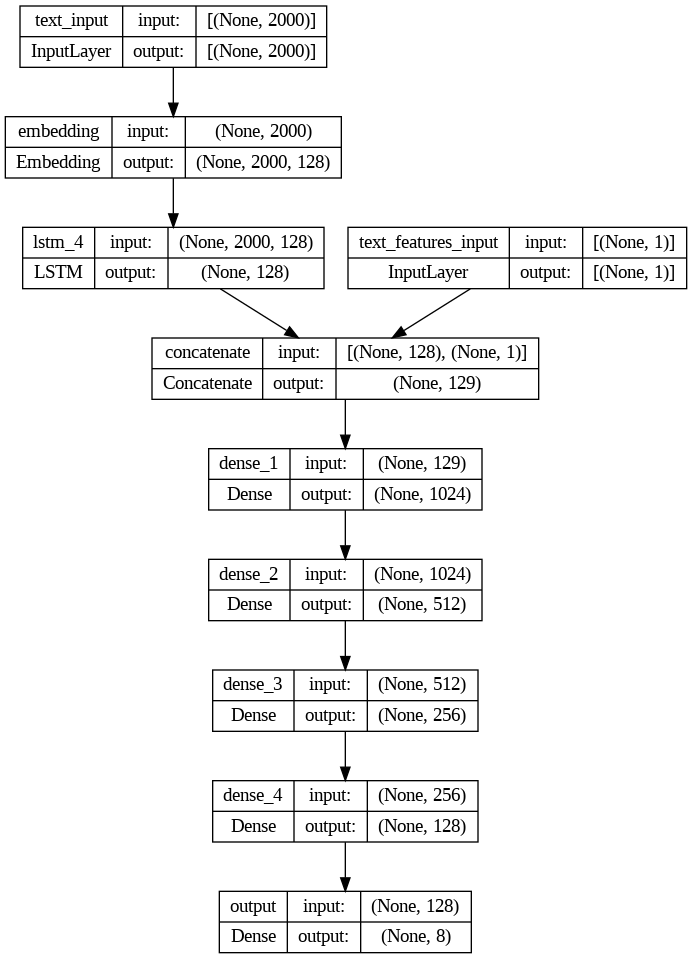

In [56]:


os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Model gecompileerd en getraind, keuze van aantal epochs uitgelegd</strong>
</div>


Voor het compileren van het model gebruiken we de sparse_categorical_crossentropy als loss. Dit doen we omdat we te maken hebben met een meervoudige classificatietaak, waarvoor deze lossfunctie geschikt is. Vervolgens kiezen we de Adam optimizer, vanwege zijn goede reputatie in de wereld van deep learning en zijn sterke leervermogen. Als metric gebruiken we accuracy, zodat we de algemene prestaties van het model goed kunnen evalueren.

In [57]:
# Model compileren
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Toon model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 2000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 2000, 128)            1280000   ['text_input[0][0]']          
                                                          0                                       
                                                                                                  
 lstm_4 (LSTM)               (None, 128)                  131584    ['embedding[0][0]']           
                                                                                                  
 text_features_input (Input  [(None, 1)]                  0         []                        

In [ ]:
#History
history = model.fit(
    {'text_input': X_train_text, 'text_features_input': X_train_text_features},
    y_train,
    epochs=20, #Was 20
    batch_size=128, #Was 128
    validation_data=({'text_input': X_val_text, 'text_features_input': X_val_text_features}, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

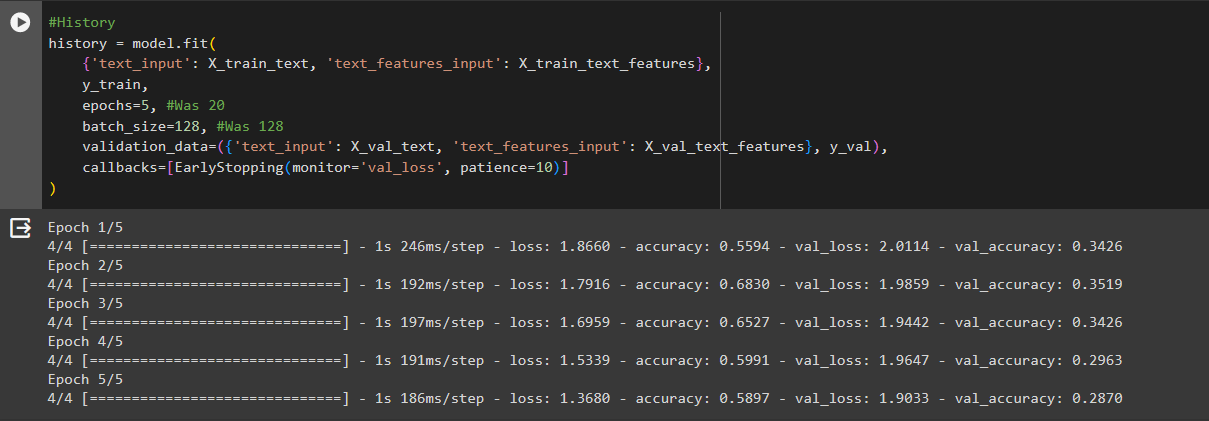

Voor het trainen van ons model hebben we gekozen voor 20 epochs. Dit aantal stelt ons in staat om snel te evalueren hoe goed het model presteert, zonder uren te hoeven wachten op resultaten. Daarnaast hebben we de batchgrootte ingesteld op 128.

De batchgrootte bepaalt het aantal voorbeelden dat in één keer wordt gebruikt om de parameters van het model bij te werken tijdens het trainen. Een grotere batchgrootte kan leiden tot snellere trainingsiteraties, maar kan ook leiden tot hoger geheugengebruik. Aan de andere kant kan een kleinere batchgrootte zorgen voor meer stabiele updates van de modelparameters en kan het model betere generalisatieprestaties behalen. We hebben gekozen voor een batchgrootte van 128 omdat dit een goed compromis biedt tussen snelheid en stabiliteit tijdens het trainen van ons model.

Verder passen we early stopping toe om te voorkomen dat ons model te lang blijft trainen terwijl de validatieloss toeneemt. We hebben de "patience" ingesteld op 10 epochs, wat betekent dat het trainingsproces stopt als er gedurende 10 opeenvolgende epochs geen verbetering wordt gezien in de validatieloss. Deze aanpak helpt overfitting te voorkomen en zorgt ervoor dat ons model goed generaliseert naar nieuwe gegevens. We hebben voor deze aanpak gekozen omdat we tijdens het testen hebben gemerkt dat het model soms na meerdere epochs van slechter presteren uiteindelijk toch een lagere loss behaalde.

In [ ]:


# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Visualiseer de trainings- en validatieloss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong> Hoofdstuk 5: Transformer voor songteksten </strong></h2>
</div>

##### Voordelen van een vooraf getraind model

Wij gebruiken hieronder een pretrained model, deze hebben wij van hugging face afgehaald, genaamd "luiz826/roberta-to-music-genre". Dit is een transfer model, specifiek de RoBERTa-model.(Luiz826/Roberta-to-music-genre · Hugging Face, z.d.)

Bij het gebruik van een vooraf getrainde modellen bespaar je tijd. Het trainen van een model kan veel tijd en rekenkracht kosten. Het is vaak getraint op een grote dataset en soms nog meerdere datasets, dit duurt vaak heel lang om te trainen. Doordat het model op een grotere dataset is getraint zal het beter presenteren. Zo is het mogelijk om met minder data en rekenkracht alsnog goede resultaten te behalen. Deze modellen worden vaak ook up-to-date gehouden en kan je profiteren van steeds betere resultaten. Een specifiek voordeel van dit model is dat het al is getraint op engelse songteksten. Dit is zeer handig, want de songteksten die wij hebben is ook engels.

# Hoofdstuk 5.1: Data Preprocessing

De maximale hoeveelheid van tokens voor dit model is 512. Hierdoor gaan wij de de songteksten in korten tot de maximale lengte

In [60]:


# Tokenizer initialiseren
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Functie om songteksten in te korten tot een maximale lengte van 512 tokens
def truncate_text(text):
    """
    Inkorten van de tekst tot een maximum aantal tokens.

    Parameters:
        text (str): De tekst die moet worden ingekort.

    Returns:
        list: Een lijst met de ingekorte tokens.
    """
    # Tokenizeren van de tekst
    tokens = tokenizer.encode(text, add_special_tokens=True)
    # Inhoud inkorten tot 512 tokens
    truncated_tokens = tokens[:512]
    return truncated_tokens


# Songteksten tokeniseren en inkorten
tokenized_lyrics = train['lyrics'].apply(truncate_text)

# Labelencoder initialiseren en genres labelen
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train['genre'])

# Controleer op de lengte van de tokens
max_len = max(len(tokens) for tokens in tokenized_lyrics)
print("Maximale lengte van tokens:", max_len)

# Controleer de labels en hun corresponderende numerieke waarden
print("Unieke labels:", set(labels))
print("Labelencoder classes:", label_encoder.classes_)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (7384 > 512). Running this sequence through the model will result in indexing errors


Maximale lengte van tokens: 512
Unieke labels: {0, 1, 2, 3, 4, 5, 6, 7}
Labelencoder classes: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [ ]:
# Tokenizer initialiseren
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Functie om songteksten in te korten tot een maximale lengte van 512 tokens
def truncate_text(text):
    """
    Tekst inkorten tot een maximum aantal tokens.

    Parameters:
        text (str): De tekst die moet worden ingekort.

    Returns:
        list: Een lijst met de ingekorte tokens.
    """
    # Tokenizeren van de tekst
    tokens = tokenizer.encode(text, add_special_tokens=True)
    # Inhoud inkorten tot 512 tokens
    truncated_tokens = tokens[:512]
    return truncated_tokens


# Songteksten tokeniseren en inkorten voor train en test data
train['tokenized_lyrics'] = train['lyrics'].apply(truncate_text)
test['tokenized_lyrics'] = test['lyrics'].apply(truncate_text)


#Hoofdstuk 5.2: Modelleren

In [ ]:

# Labelencoder initialiseren en genres labelen
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train['genre'])

# Model initialiseren
model = TFAutoModelForSequenceClassification.from_pretrained("luiz826/roberta-to-music-genre")

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(train['tokenized_lyrics'].tolist(), train_labels, test_size=0.1, random_state=42)


In [ ]:

# Padding en conversie naar numpy arrays
def convert_to_dataset(tokenized_texts, labels):
    input_ids = []
    attention_masks = []

    for text in tokenized_texts:
        input_ids.append(text + [0] * (512 - len(text)))
        attention_masks.append([1] * len(text) + [0] * (512 - len(text)))

    return np.array(input_ids), np.array(attention_masks), np.array(labels)

In [ ]:
train_input_ids, train_attention_masks, train_labels = convert_to_dataset(train_texts, train_labels)
val_input_ids, val_attention_masks, val_labels = convert_to_dataset(val_texts, val_labels)
test_input_ids, test_attention_masks, _ = convert_to_dataset(test['tokenized_lyrics'].tolist(), np.zeros(len(test)))

In [ ]:
# Functie voor het opzetten van de TF datasets
def create_tf_dataset(input_ids, attention_masks, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": input_ids, "attention_mask": attention_masks}, labels))
    return dataset.batch(batch_size)

batch_size = 8
train_dataset = create_tf_dataset(train_input_ids, train_attention_masks, train_labels, batch_size)
val_dataset = create_tf_dataset(val_input_ids, val_attention_masks, val_labels, batch_size)
test_dataset = create_tf_dataset(test_input_ids, test_attention_masks, np.zeros(len(test)), batch_size)  # Labels zijn niet nodig voor test dataset


In [ ]:
# Model compileren
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Trainen van het model met early stopping
model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=[early_stopping])

##### Keuze hyperparameters

Een batchgrootte van 8 is gekozen om geheugen te besparen en trainingstijd te optimaliseren. Bij het trainen van een neuraal netwerk is de batchgrootte het aantal voorbeelden dat in één keer wordt doorgegeven aan het netwerk. Een kleinere batchgrootte zoals 8 zorgt voor minder geheugengebruik en vereist minder berekeningen per stap tijdens het trainen. Dit kan vooral gunstig zijn bij beperkte hardwarebronnen, zoals GPU-geheugen.

De train-test split is uitgevoerd met een verhouding van 90% training en 10% validatie om overfitting te voorkomen. Een trainingsset van 90% zorgt ervoor dat het model voldoende voorbeelden heeft om te leren, terwijl de validatieset van 10% wordt gebruikt om de prestaties van het model te evalueren tijdens het trainingsproces.

Een verhouding van 90% trainingsdata en 10% validatiedata is een goede keuze om overfitting te voorkomen. Als er te weinig voorbeelden in de validatieset zitten, kan het moeilijk zijn om de algemene prestaties van het model te beoordelen. Aan de andere kant, als de validatieset te groot is, kan er te weinig trainingsdata overblijven, wat kan leiden tot een slechter presterend model. Daarom is een verhouding van 90-10% een goede balans tussen trainingsnauwkeurigheid en modelprestaties op nieuwe, niet-geziene data.

##### Fine-tuning toelichten

Allereerst worden de songteksten voorbereid en getokeniseerd met behulp van de RoBERTa-tokenizer. De tekst wordt ingekort tot een maximale lengte van 512 tokens om te voldoen aan de inputvereisten van het model. De muziekgenres worden gelabeld met behulp van een labelencoder, waarbij elk genre wordt omgezet in een numerieke waarde die het model kan begrijpen. Het pretrained RoBERTa-model wordt geladen. Dit model heeft al veel geleerd van enorme hoeveelheden tekst uit verschillende bronnen. De dataset wordt opgesplitst in een trainingsset en een validatieset, met respectievelijk 90% en 10% van de data. Dit wordt gedaan om te voorkomen dat het model overfit aan de trainingsdata. De tokenized teksten worden gepadd en omgezet naar numpy-arrays, zodat ze als input kunnen worden gebruikt voor het model. Dit omvat het toevoegen van maskers om aan te geven welke delen van de input relevant zijn. De data wordt omgezet naar TensorFlow-datasets die geschikt zijn voor training. Tijdens het fine-tunen past het model zijn gewichten aan om zich aan te passen aan de specifieke taak van muziekgenreclassificatie. Dit gebeurt door de modelparameters aan te passen aan de hand van de trainingsdata, waarbij de voorspelde output wordt vergeleken met de werkelijke labels. Na elke epoch wordt het model geëvalueerd op de validatieset om de prestaties te controleren en overfitting te voorkomen.

Door het fine-tunen op de specifieke taak van muziekgenreclassificatie kan het pretrained RoBERTa-model zich aanpassen aan de specifieke kenmerken van deze taak, waardoor het betere resultaten kan behalen dan wanneer het model niet gefinetuned zou zijn.

##### Keuze aantal epochs

De keuze voor het aantal epochs, in dit geval 10, is een belangrijk aspect van het fine-tuningproces van een neuraal netwerk. Het aantal epochs bepaalt hoe vaak het model door de volledige trainingsdata wordt getraind. Wij hebben ook early stopping toegepast, waar als de accuracy na 3 gedurende epochs niet verbeterd is stopt het trainen, dit voorkomt overfitting. Wij hebben 10 epochs gebruikt, omdat het trainen niet verder ging dan hoogst uit 5 epochs door de early stopping.d. Wij hebben ook early stopping toegepast, waar als de accuracy na 3 gedurende epochs niet verbeterd is stopt het trainen, dit voorkomt overfitting. Wij hebben 10 epochs gebruikt, omdat het trainen niet verder ging dan hoogst uit 5 epochs door de early stopping.


In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Voorspellingen op test dataset
predictions = model.predict(test_dataset)

# Evaluatie van het model op de validatieset
loss, accuracy = model.evaluate(val_dataset)

# Weergeven van het verlies en de nauwkeurigheid
print("Verlies op de validatieset:", loss)
print("Nauwkeurigheid op de validatieset:", accuracy)

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong> Hoofdstuk 6: Model naar Keuze </strong></h2>
</div>

# Hoofdstuk 6.1: Modelleren

In [ ]:
# Train data
train_audio_data = np.concatenate(list(genre_audio_data.values()))
train_labels = train['genre']

# Labels encoden
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Test data
test_audio_data = np.array(test_audio_data)

# Fft functie
def calculate_fft(data):
    """
    Bereken de Fouriergetransformeerde van de gegevens.

    Parameters:
        data (ndarray): De gegevens waarvan de Fouriergetransformeerde moet worden berekend.

    Returns:
        ndarray: De absolute waarden van de Fouriergetransformeerde.
    """
    return np.abs(fft(data))


# Fft voor train en test uitrekenen
train_audio_data_fft = np.apply_along_axis(calculate_fft, 1, train_audio_data)
test_audio_data_fft = np.apply_along_axis(calculate_fft, 1, test_audio_data)

# Model maken
def create_audio_model():
    """
    Creëer een audiomodel met behulp van een sequentiële Keras-modelarchitectuur.

    Returns:
        Sequential: Het gemaakte audiomodel.
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=(train_audio_data_fft.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    return model



audio_model = create_audio_model()

# Compile
audio_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train model
history = audio_model.fit(train_audio_data_fft, train_labels_encoded,
                          epochs=50, batch_size=64,
                          validation_split=0.1,
                          callbacks=[early_stopping])

#####Keuzes model

**Fast Fourier Transform**

Bij het verwerken van audiogegevens is het cruciaal om de frequentie informatie te benuttigen. Daarom maken wij gebruik van de FFT om de kenmerken om te zetten naar het frequentiedomein en de frequentie-informatie van de audiogegevens te extraheren.

**Model Architectuur**

Dit is een FNN audio-classificatiemodel. Bij de neuronen gebruiken wij een ReLU activatiefunctie. Deze gebruiken wij omdat het snel convergeert en het verhelpt het probleem van het verdwijnende gradiënt. Bij de output layer gebruiken wij de softmax functie. Dit zet ruwe uitvoerwaarden (logits) om naar kansen dat elk voorbeeld tot een bepaalde klasse behoort.

Wij gebruiken BatchNormalization om de inputs te normaliseren. Hierdoor is het model sneller en minder gevoelig voor de oorspronkelijke gewichten. Het zorgt er ook voor dat het model stabieler wordt tijdens het trainen door variaties in de inputgegevens te verminderen.

Wij maken ook gebruik van Dropout. Dit is een vorm van regularisatie die wordt gebruikt om overfitting te verminderen. Het voorkomt dat neuronen te sterk afhankelijk worden van elkaar door willekeurig een bepaald percentage van neuronen uit te schakelen tijdens de training.

#####Hyperparameters

Adam is een efficiënte optimizer die vaak goede resultaten oplevert bij neurale netwerken. Het past adaptieve leersnelheden toe voor elk parameter, waardoor het geschikt is voor vele soorten problemen.
Een lage learning rate van 0.0001 wordt gebruikt om het model geleidelijk te laten convergeren en om stabiele updates van de gewichten te garanderen.
Sparse Categorical Crossentropy is een geschikte loss-functie voor multi-class classificatieproblemen.
Een batchgrootte van 64 wordt gebruikt om het model efficiënt te trainen met behulp van mini-batch gradient descent.
Het trainen wordt gestopt zodra de val_accuracy niet verbetert gedurende 3 epochs, om overfitting te voorkomen en het model te besparen van onnodige training.

#####Keuze Epochs

Het aantal epochs is 50. Het is een prima groot aantal epochs om het model te trainen zonder dat het te veel wordt blootgesteld aan overfitting. De Early Stopping zorgt ervoor dat de training vroegtijdig wordt gestopt als er geen verbetering ontstaat gedurende 3 epochs. Dit voorkomt overfitting.

In [ ]:
|# Het audiomodel evalueren op de testdata
predictions = audio_model.predict(test_audio_data_fft)

# Converteer voorspellingen naar labels
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Voeg de voorspelde labels toe aan de test DataFrame
test['predicted_genre'] = predicted_labels

# Bekijk de voorspelde genres
test[['filename', 'predicted_genre']]


In [ ]:
set(predicted_labels)


In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong> Hoofdstuk 7: Bevindingen </strong></h2>
</div>

####Bevindingen

Overzicht van resultaten

| Model                        | val_accuracy |
|------------------------------|--------------|
| LSTM voor audioclips         |     0.43     |
| LSTM voor songtesksten       |     0.36     |
| Transformer voor songteksten |     0.16     |
| Model naar keuze             |     0.13     |

Het model dat het beste presteerde is LSTM voor audioclips. Het is een bidirectional LSTM-model, dit houdt in dat het model leert van de vorige layer en volgende layer. Het kijkt naar de verleden en de toekomst.
Wij hebben ook een normale LSTM-model geprobeert alleen zagen wij dat een bidirectional LSTM-model beter presteerde.



<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong> Hoofdstuk 8: Conclusie en aanbevelingen </strong></h2>
</div>

####Conslusie en Aanbevelingen

Bij het modelleren begonnen we met het inlezen van hoe de modellen die wij gebruiken in elkaar zitten. Verder hebben we gekeken hoe wij deze moeten toepassen. Ook hebben wij een EDA gemaakt, hierbij zagen wij verschillende dingen. Denk hierbij aan de kenmerken van de genre's, zoals de drum en beats, melodie en zang.

De grootste uitdagingen waar wij tegen opliepen was het verbeteren van het model. Denk hierbij aan de juiste hoeveelheid neuronen, batch normalization gebruiken, maxpooling gebruiken enz.
Advies

Het gebruik van audioclips in plaats van tekstdata biedt bedrijven een dieper inzicht in verschillende muziekgenres. Audiogegevens bevatten meer kenmerken per genre, zoals de beat, melodie en harmonieën. Door deze audioclips te analyseren, kunnen bedrijven nauwkeuriger genreclassificaties maken, aanbevelingssystemen verbeteren en trends in de muziekindustrie identificeren. Dit stelt hen in staat om hun diensten te verbeteren en hun concurrentiepositie te versterken.

Om dit systeem verder uit te bereiden zou je een grotere dataset van audioclips met verschillende genres in beschikking moeten hebben. Ook zouden er meer genres in die dataset staan, zodat het voldoende diversiteit bevat. Wij hebben niet veel feature engineering gedaan. Wij raden aan om veel kenmerken te extraheren.

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong> Hoofdstuk 9: Bronvermelding </strong></h2>
</div>

Bronnen


TextBlob: Simplified Text Processing — TextBlob 0.18.0.post0 documentation. (z.d.). https://textblob.readthedocs.io/en/dev/

Team, K. (z.d.-a). Keras documentation: Embedding layer. https://keras.io/api/layers/core_layers/embedding/

Wat is Spectrogram? (z.d.). https://emastered.com/nl/blog/what-is-spectrogram

BRON: Stukken uit de les van week 7 (LSTM_voor_timeseries_data_–_classificatie_van_audioclips, 2024)